In [1]:
#load all python packages necessary
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.optimize import fsolve
import scipy.integrate as integrate
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from itertools import combinations_with_replacement
rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = [12, 12]
from matplotlib.cm import viridis
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from math import sqrt
#Standard gravitational parameter
mu = 398600 #[km2. s−2]

In [2]:
# simulate trajectory and get our measurements, methods from Wall and Conway
# inputs are Numb_rev= number of revolution for transfer, theta2 = finl angle position,
# time_diff = the time difference to force transfer to depart from natural dynamics
# datapoints= number of measurement we want
def get_states(Numb_rev,theta2,time_diff,datapoints):
    mu = 398600

    #initialisation initial and end radiuses
    r1 = 42164
    r2 = 42164

    ecc = 0
    theta_1= 0*np.pi/2
    theta_2=theta2

    h = (mu*r1)**0.5

    r1dot= 0
    r2dot= 0

    thetadot1=(mu/r1**3)**0.5
    thetadot2=(mu/r2**3)**0.5

    #initialisation initial and end speeds
    thetad1sqr = thetadot1**2
    thetad2sqr = thetadot2**2

    #initialisation flight angles
    tang1 = r1dot/(r1*thetadot1)
    tang2 = r2dot/(r2*thetadot2)

    #initialisation of angle between the 2 positions
    Nrev = Numb_rev #number of rotation around the sun, is it always 0 for rotation around earth? 

    theta_tilda = theta_2-theta_1        
    thetaf = theta_tilda + 2*np.pi*Nrev

    theta_values = np.linspace(theta_1, thetaf, datapoints)
    circle_angles = np.linspace(0, 2*np.pi, datapoints)
    
    a=1/r1
    b=-tang1/r1
    c=1/(2*r1)*(mu/(r1**3*thetad1sqr)-1)
    #finding d via root method
    period= (2*np.pi/mu**0.5*r1**1.5)
    aimed_t= (theta_tilda/(2*np.pi))*(2*np.pi/mu**0.5*r1**1.5)+Nrev*period-time_diff     #10000
    
    def timetaken(d):
        j=0
        matrix_a = np.array([[30*thetaf**2, -10*thetaf**3, thetaf**4 ], [-48*thetaf, 18*thetaf**2, -2*thetaf**3],[20, -8*thetaf ,thetaf**2]])
        matrix_b = np.array([1/r2-(a+b*thetaf+c*thetaf**2+d*thetaf**3),-tang2/r2-(b+2*c*thetaf+3*d*thetaf**2),mu/(r2**4*thetad2sqr)-(1/r2+2*c+6*d*thetaf)])
    
        result = np.dot(matrix_a, matrix_b)
        result = (1/(2*thetaf**6))*result
        e,f,g = result
        def time(x,a,b,c,d,e,f,g):
            return ((1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))**4/mu*(1/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))+2*c+6*d*x+12*e*x**2+20*f*x**3+30*g*x**4))**0.5
    
    
        t=quad(time, 0, thetaf, args=(a,b,c,d,e,f,g))
        #print(t[0])
        return t[0]-aimed_t
    root = fsolve(timetaken, 0)
    d= root[0]
    matrix_a = np.array([[30*thetaf**2, -10*thetaf**3, thetaf**4 ], [-48*thetaf, 18*thetaf**2, -2*thetaf**3],[20, -8*thetaf ,thetaf**2]])
    matrix_b = np.array([1/r2-(a+b*thetaf+c*thetaf**2+d*thetaf**3),-tang2/r2-(b+2*c*thetaf+3*d*thetaf**2),mu/(r2**4*thetad2sqr)-(1/r2+2*c+6*d*thetaf)])
    
    result = np.dot(matrix_a, matrix_b)
    result = (1/(2*thetaf**6))*result
    e,f,g = result
    
    #get all the different states from equations in Wall and Conway paper
    r=np.zeros([len(theta_values),1])
    j=0
    for i in theta_values:
        r[j]= 1/(a+b*i+c*i**2+d*i**3+e*i**4+f*i**5+g*i**6)
        j+=1


    tangamma=np.zeros([len(theta_values),1])
    j=0
    for i in theta_values:
        tangamma[j]=-r[j]*(b+2*c*i+3*d*i**2+4*e*i**3+5*f*i**4+6*g*i**5) 
        j+=1
    
    thetadott=np.zeros([len(theta_values),1])
    j=0 
    for i in r:
        thetadott[j]=((mu/i**4)*1/(1/i+2*c+6*d*theta_values[j]+12*e*theta_values[j]**2+20*f*theta_values[j]**3+30*g*theta_values[j]**4))**0.5
        j+=1

    thetadottdot=np.zeros([len(theta_values),1])
    j=0
    for i in r:
        thetadottdot[j]=-(mu/(2*i**4))*(4*tangamma[j]/(1/i+2*c+6*d*theta_values[j]+12*e*theta_values[j]**2+20*f*theta_values[j]**3+30*g*theta_values[j]**4)+(6*d+24*e*theta_values[j]+60*f*theta_values[j]**2+120*g*theta_values[j]**3-(tangamma[j]/i))/(1/i+2*c+6*d*theta_values[j]+12*e*theta_values[j]**2+20*f*theta_values[j]**3+30*g*theta_values[j]**4)**2)
        j+=1
    
    rdott=np.zeros([len(theta_values),1])
    j=0
    for i in r:
        rdott[j]=-i**2*(b+2*c*theta_values[j]+3*d*theta_values[j]**2+4*e*theta_values[j]**3+5*f*theta_values[j]**4+6*g*theta_values[j]**5)*thetadott[j]
        j+=1
    
    rdottdot=np.zeros([len(theta_values),1])
    j=0
    for i in r:
        rdottdot[j]=2*i*tangamma[j]**2*thetadottdot[j]**2-i**2*(2*c+6*d*theta_values[j]+12*e*theta_values[j]**2+20*f*theta_values[j]**3+30*g*theta_values[j]**4)*thetadott[j]**2+i*tangamma[j]*thetadottdot[j]
        j+=1
    
    Thrust=np.zeros([len(theta_values),1])
    j=0
    for i in theta_values:
        Thrust[j]=(-mu/(2*r[j]**3*np.cos(np.arctan(tangamma[j]))))*(6*d+24*e*i+60*f*i**2+120*g*i**3-tangamma[j]/r[j])/(1/r[j]+2*c+6*d*i+12*e*i**2+20*f*i**3+30*g*i**4)**2
        j+=1
    theta=theta_values
    
    
    def ThrustVSThetadot(x):
        return abs((-mu/(2*(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))**3*np.cos(np.arctan(-(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))*(b+2*c*x+3*d*x**2+4*e*x**3+5*f*x**4+6*g*x**5)))))*(6*d+24*e*x+60*f*x**2+120*g*x**3-(-(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))*(b+2*c*x+3*d*x**2+4*e*x**3+5*f*x**4+6*g*x**5))/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6)))/(1/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))+2*c+6*d*x+12*e*x**2+20*f*x**3+30*g*x**4)**2/(((mu/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))**4)*1/(1/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))+2*c+6*d*x+12*e*x**2+20*f*x**3+30*g*x**4))**0.5))
    
    max_thrust= np.max(Thrust)
    deltaV = integrate.quad(ThrustVSThetadot, 0, thetaf)
    final_t= aimed_t
    print(aimed_t)
    
    
    def time_calc(theta_values):
        mu = 398600
        def time(x,a,b,c,d,e,f,g):
            return ((1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))**4/mu*(1/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))+2*c+6*d*x+12*e*x**2+20*f*x**3+30*g*x**4))**0.5

        j=0
        times=np.zeros(len(theta_values))
        for i in theta_values:
            t=quad(time, 0, i, args=(a,b,c,d,e,f,g))
            times[j]=t[0]
            j+=1
        return times
    timee=time_calc(theta_values)
    
    return a,b,c,d,e,f,g,r,rdott,theta,thetadott,thetadottdot,Thrust,timee,deltaV,max_thrust,final_t,period

In [3]:
#get the time vector for our measurements, input = theta vector of transfer
def time_calc(theta_values):
    mu = 398600
    def time(x,a,b,c,d,e,f,g):
        return ((1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))**4/mu*(1/(1/(a+b*x+c*x**2+d*x**3+e*x**4+f*x**5+g*x**6))+2*c+6*d*x+12*e*x**2+20*f*x**3+30*g*x**4))**0.5

    j=0
    times=np.zeros(len(theta_values))
    for i in theta_values:
        t=quad(time, 0, i, args=(a,b,c,d,e,f,g))
        times[j]=t[0]
        j+=1
    return times

In [4]:
#transform polar coordinates (r,theta) to cartesian (x,y)
def polar_to_cartesian(r,theta_values):
    j=0
    x_cart=np.zeros(len(theta_values))
    y_cart=np.zeros(len(theta_values))
    for i in r:
        x_cart[j] = i * np.cos(theta_values[j])
        y_cart[j] = i * np.sin(theta_values[j])
        j+=1
    return x_cart,y_cart

In [5]:
#draw the trajectory of our transfers
def draw_orbit_trajectories(x_values,y_values):

    plt.figure(figsize=(8, 8))
    
    #plt.plot(xorbit1, yorbit1,label='orbit 1')
    
    #plot low thrust trajectory orbit
    plt.plot(x_values, y_values,color='red', label='Trajectory orbit')
    
    plt.title('Orbit trajectories')
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.legend()
    
    plt.show()

In [6]:
omega_earth = 7.2921159e-5  # Earth's angular velocity in rad/s
# transform ECI coordinates to ECEF coordinates

def transform_to_ecef(x_eci, y_eci, t, omega, theta_eci):
    """
    Transform Cartesian coordinates from the ECI frame to the ECEF frame.
    
    Parameters:
    x_eci (np.array): x-coordinates in the ECI frame
    y_eci (np.array): y-coordinates in the ECI frame
    t (np.array): time instances
    omega (float): Earth's rotation rate (radians per time unit)
    theta_eci (float): Initial angle (radians) at t=0
    
    Returns:
    x_ecef, y_ecef: Transformed coordinates in the ECEF frame
    """
    # Ensure inputs are numpy arrays for vectorized operations
    x_eci = np.asarray(x_eci)
    y_eci = np.asarray(y_eci)
    t = np.asarray(t)
    theta_eci = np.asarray(theta_eci)
    
    # Compute theta for each time instance
    theta = theta_eci + omega * t
    
    # Precompute trigonometric functions
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    # Transform coordinates
    x_ecef = x_eci * cos_theta + y_eci * sin_theta
    y_ecef = -x_eci * sin_theta + y_eci * cos_theta
    
    return x_ecef, y_ecef

In [7]:
#builds the candidate library for our models with yin the state vector, 
#NVars the number of variables we want and polyorder the order of the polynomial we want
#function that creates the Theta matrix/candidate library
def poolDatarenewed(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = np.zeros((n, 1))
    
    # poly order 0
    yout[:, 0] = np.ones(n)
    
    # poly order 1
    for i in range(nVars):
        yout = np.append(yout, yin[:, i].reshape((yin.shape[0], 1)), axis=1)
    
    # poly orders 2 to 7
    for order in range(2, polyorder + 1):
        for combo in combinations_with_replacement(range(nVars), order):
            term = np.prod([yin[:, idx] for idx in combo], axis=0).reshape((yin.shape[0], 1))
            yout = np.append(yout, term, axis=1)
    
    return yout



#gets the Xi matrix to represent the dynamics of the problem, input are Theta= candidate library, dXdt = vector to be determined
#lamb= threshold for coefficients in Xi, n = number of states
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
#Least squares is a method that:
#In this algorithm, we start with a least-squares solution for Ξ and then threshold all coefficients
#that are smaller than some cutoff value λ. Once the indices of the remaining non-zero coefficients
#are identified, we obtain another least-squares solution for Ξ onto the remaining indices. These
#new coefficients are again thresholded using λ, and the procedure is continued until the non-zero
#coefficients converge. This algorithm is computationally efficient, and it rapidly converges to a
#sparse solution in a small number of iterations. The algorithm also benefits from simplicity, with
#a single parameter λ required to determine the degree of sparsity in Ξ.
    
#now having calculated the Least squares of all polynomial combinations, we will keep these with a lambda higher then the
#threshold value lamb, all combination with a least square value smaller are not considered to have a sparse representation
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi


In [1]:
#SINDy algorithm to determine Thrust from specified input data
#4-state model
#inputs are the 4 states, theta r thetadot rdot and thetadotdot for equation of motion,
#Polyorder= order of polynomial wantes, lamb = threshold for least squares, number_states = number of states
def predict_Manoeuvre(theta,r,thetadot,rdot,thetadotdot, PolyOrder,lamb,number_states):
    n = number_states #number of states
    X = np.stack((theta, r,thetadot,rdot), axis=1)
    #print(X.shape)
    X = np.squeeze(X, axis=2)
    x = X
    dx = np.zeros_like(x)
    LHS=(thetadotdot+2*(rdot/(r*thetadot))*thetadot**2)*r
    dx=LHS
    Theta = poolDatarenewed(x,n,PolyOrder)
    lamb = lamb
    Xi = sparsifyDynamics(Theta,dx,lamb,1)
    print(Xi)
    Thrust_sparse= np.dot(Theta,Xi)
    return Theta,Xi,Thrust_sparse

#theta model, here we we will need to only specify one of the numbers of state
def predict_Manoeuvretheta(theta,r,thetadot,rdot,thetadotdot, PolyOrder,lamb,number_states):
    n = number_states #number of states
    X = np.stack((theta, r,thetadot,rdot), axis=1)
    #print(X.shape)
    X = np.squeeze(X, axis=2)
    x = X
    dx = np.zeros_like(x)
    LHS=(thetadotdot+2*(rdot/(r*thetadot))*thetadot**2)*r
    dx=LHS
    Theta = poolDatarenewed(x,n,PolyOrder)
    lamb = lamb
    Xi = sparsifyDynamics(Theta,dx,lamb,1)
    print(Xi)
    Thrust_sparse= np.dot(Theta,Xi)
    return Theta,Xi,Thrust_sparse

In [9]:
#builds our measurement vectors with varying number of measurements
thetaval=np.linspace(0,2*np.pi,37)
j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,10000)
    #print(t.shape)
    if i == 0:
        Thrust_table=np.zeros([len(Thrust),len(thetaval)])
        time_table=np.zeros([len(Thrust),len(thetaval)])
        r_table=np.zeros([len(Thrust),len(thetaval)])
        rdot_table=np.zeros([len(Thrust),len(thetaval)])
        theta_table=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table=np.zeros([len(Thrust),len(thetaval)])
        coeff_table=np.zeros([10,len(thetaval)])
        periods_table=np.zeros([len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table[:,j]=r.reshape((10000,))
    rdot_table[:,j]=rdot.reshape((10000,))
    theta_table[:,j]=theta.reshape((10000,))
    thetadot_table[:,j]=thetadot.reshape((10000,))
    thetadotdot_table[:,j]=thetadotdot.reshape((10000,))
    Thrust_table[:,j]=Thrust.reshape((10000,))
    time_table[:,j]=t.reshape((10000,))
    coeff_table[:,j]= array
    periods_table[j]=period
    j+=1
    
j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,5000)
    if i == 0:
        Thrust_table5000=np.zeros([len(Thrust),len(thetaval)])
        r_table5000=np.zeros([len(Thrust),len(thetaval)])
        rdot_table5000=np.zeros([len(Thrust),len(thetaval)])
        theta_table5000=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table5000=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table5000=np.zeros([len(Thrust),len(thetaval)])
        coeff_table5000=np.zeros([10,len(thetaval)])
        time_table5000=np.zeros([len(Thrust),len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table5000[:,j]=r.reshape((5000,))
    rdot_table5000[:,j]=rdot.reshape((5000,))
    theta_table5000[:,j]=theta.reshape((5000,))
    thetadot_table5000[:,j]=thetadot.reshape((5000,))
    thetadotdot_table5000[:,j]=thetadotdot.reshape((5000,))
    Thrust_table5000[:,j]=Thrust.reshape((5000,))
    time_table5000[:,j]=t.reshape((5000,))
    coeff_table5000[:,j]= array
    j+=1
    

j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,2500)
    if i == 0:
        Thrust_table2500=np.zeros([len(Thrust),len(thetaval)])
        r_table2500=np.zeros([len(Thrust),len(thetaval)])
        rdot_table2500=np.zeros([len(Thrust),len(thetaval)])
        theta_table2500=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table2500=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table2500=np.zeros([len(Thrust),len(thetaval)])
        coeff_table2500=np.zeros([10,len(thetaval)])
        time_table2500=np.zeros([len(Thrust),len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table2500[:,j]=r.reshape((2500,))
    rdot_table2500[:,j]=rdot.reshape((2500,))
    theta_table2500[:,j]=theta.reshape((2500,))
    thetadot_table2500[:,j]=thetadot.reshape((2500,))
    thetadotdot_table2500[:,j]=thetadotdot.reshape((2500,))
    Thrust_table2500[:,j]=Thrust.reshape((2500,))
    time_table2500[:,j]=t.reshape((2500,))
    coeff_table2500[:,j]= array
    j+=1
    
    

j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,1000)
    if i == 0:
        Thrust_table1000=np.zeros([len(Thrust),len(thetaval)])
        r_table1000=np.zeros([len(Thrust),len(thetaval)])
        rdot_table1000=np.zeros([len(Thrust),len(thetaval)])
        theta_table1000=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table1000=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table1000=np.zeros([len(Thrust),len(thetaval)])
        coeff_table1000=np.zeros([10,len(thetaval)])
        time_table1000=np.zeros([len(Thrust),len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table1000[:,j]=r.reshape((1000,))
    rdot_table1000[:,j]=rdot.reshape((1000,))
    theta_table1000[:,j]=theta.reshape((1000,))
    thetadot_table1000[:,j]=thetadot.reshape((1000,))
    thetadotdot_table1000[:,j]=thetadotdot.reshape((1000,))
    Thrust_table1000[:,j]=Thrust.reshape((1000,))
    time_table1000[:,j]=t.reshape((1000,))
    coeff_table1000[:,j]= array
    j+=1
    
j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,500)
    if i == 0:
        Thrust_table500=np.zeros([len(Thrust),len(thetaval)])
        r_table500=np.zeros([len(Thrust),len(thetaval)])
        rdot_table500=np.zeros([len(Thrust),len(thetaval)])
        theta_table500=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table500=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table500=np.zeros([len(Thrust),len(thetaval)])
        time_table500=np.zeros([len(Thrust),len(thetaval)])
        coeff_table500=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table500[:,j]=r.reshape((500,))
    rdot_table500[:,j]=rdot.reshape((500,))
    theta_table500[:,j]=theta.reshape((500,))
    thetadot_table500[:,j]=thetadot.reshape((500,))
    thetadotdot_table500[:,j]=thetadotdot.reshape((500,))
    Thrust_table500[:,j]=Thrust.reshape((500,))
    time_table500[:,j]=t.reshape((500,))
    coeff_table500[:,j]= array
    j+=1
    

j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,250)
    if i == 0:
        Thrust_table250=np.zeros([len(Thrust),len(thetaval)])
        r_table250=np.zeros([len(Thrust),len(thetaval)])
        rdot_table250=np.zeros([len(Thrust),len(thetaval)])
        theta_table250=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table250=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table250=np.zeros([len(Thrust),len(thetaval)])
        time_table250=np.zeros([len(Thrust),len(thetaval)])
        coeff_table250=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table250[:,j]=r.reshape((250,))
    rdot_table250[:,j]=rdot.reshape((250,))
    theta_table250[:,j]=theta.reshape((250,))
    thetadot_table250[:,j]=thetadot.reshape((250,))
    thetadotdot_table250[:,j]=thetadotdot.reshape((250,))
    Thrust_table250[:,j]=Thrust.reshape((250,))
    time_table250[:,j]=t.reshape((250,))
    coeff_table250[:,j]= array
    j+=1
    
j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,100)
    if i == 0:
        Thrust_table100=np.zeros([len(Thrust),len(thetaval)])
        r_table100=np.zeros([len(Thrust),len(thetaval)])
        rdot_table100=np.zeros([len(Thrust),len(thetaval)])
        theta_table100=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table100=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table100=np.zeros([len(Thrust),len(thetaval)])
        time_table100=np.zeros([len(Thrust),len(thetaval)])
        coeff_table100=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table100[:,j]=r.reshape((100,))
    rdot_table100[:,j]=rdot.reshape((100,))
    theta_table100[:,j]=theta.reshape((100,))
    thetadot_table100[:,j]=thetadot.reshape((100,))
    thetadotdot_table100[:,j]=thetadotdot.reshape((100,))
    Thrust_table100[:,j]=Thrust.reshape((100,))
    time_table100[:,j]=t.reshape((100,))
    coeff_table100[:,j]= array
    j+=1
    
j=0
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,90)
    if i == 0:
        Thrust_table90=np.zeros([len(Thrust),len(thetaval)])
        r_table90=np.zeros([len(Thrust),len(thetaval)])
        rdot_table90=np.zeros([len(Thrust),len(thetaval)])
        theta_table90=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table90=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table90=np.zeros([len(Thrust),len(thetaval)])
        time_table90=np.zeros([len(Thrust),len(thetaval)])
        coeff_table90=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table90[:,j]=r.reshape((90,))
    rdot_table90[:,j]=rdot.reshape((90,))
    theta_table90[:,j]=theta.reshape((90,))
    thetadot_table90[:,j]=thetadot.reshape((90,))
    thetadotdot_table90[:,j]=thetadotdot.reshape((90,))
    Thrust_table90[:,j]=Thrust.reshape((90,))
    time_table90[:,j]=t.reshape((90,))
    coeff_table90[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,80)
    if i == 0:
        Thrust_table80=np.zeros([len(Thrust),len(thetaval)])
        r_table80=np.zeros([len(Thrust),len(thetaval)])
        rdot_table80=np.zeros([len(Thrust),len(thetaval)])
        theta_table80=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table80=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table80=np.zeros([len(Thrust),len(thetaval)])
        time_table80=np.zeros([len(Thrust),len(thetaval)])
        coeff_table80=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table80[:,j]=r.reshape((80,))
    rdot_table80[:,j]=rdot.reshape((80,))
    theta_table80[:,j]=theta.reshape((80,))
    thetadot_table80[:,j]=thetadot.reshape((80,))
    thetadotdot_table80[:,j]=thetadotdot.reshape((80,))
    Thrust_table80[:,j]=Thrust.reshape((80,))
    time_table80[:,j]=t.reshape((80,))
    coeff_table80[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,70)
    if i == 0:
        Thrust_table70=np.zeros([len(Thrust),len(thetaval)])
        r_table70=np.zeros([len(Thrust),len(thetaval)])
        rdot_table70=np.zeros([len(Thrust),len(thetaval)])
        theta_table70=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table70=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table70=np.zeros([len(Thrust),len(thetaval)])
        time_table70=np.zeros([len(Thrust),len(thetaval)])
        coeff_table70=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table70[:,j]=r.reshape((70,))
    rdot_table70[:,j]=rdot.reshape((70,))
    theta_table70[:,j]=theta.reshape((70,))
    thetadot_table70[:,j]=thetadot.reshape((70,))
    thetadotdot_table70[:,j]=thetadotdot.reshape((70,))
    Thrust_table70[:,j]=Thrust.reshape((70,))
    time_table70[:,j]=t.reshape((70,))
    coeff_table70[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,60)
    if i == 0:
        Thrust_table60=np.zeros([len(Thrust),len(thetaval)])
        r_table60=np.zeros([len(Thrust),len(thetaval)])
        rdot_table60=np.zeros([len(Thrust),len(thetaval)])
        theta_table60=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table60=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table60=np.zeros([len(Thrust),len(thetaval)])
        time_table60=np.zeros([len(Thrust),len(thetaval)])
        coeff_table60=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table60[:,j]=r.reshape((60,))
    rdot_table60[:,j]=rdot.reshape((60,))
    theta_table60[:,j]=theta.reshape((60,))
    thetadot_table60[:,j]=thetadot.reshape((60,))
    thetadotdot_table60[:,j]=thetadotdot.reshape((60,))
    Thrust_table60[:,j]=Thrust.reshape((60,))
    time_table60[:,j]=t.reshape((60,))
    coeff_table60[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,50)
    if i == 0:
        Thrust_table50=np.zeros([len(Thrust),len(thetaval)])
        r_table50=np.zeros([len(Thrust),len(thetaval)])
        rdot_table50=np.zeros([len(Thrust),len(thetaval)])
        theta_table50=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table50=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table50=np.zeros([len(Thrust),len(thetaval)])
        time_table50=np.zeros([len(Thrust),len(thetaval)])
        coeff_table50=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table50[:,j]=r.reshape((50,))
    rdot_table50[:,j]=rdot.reshape((50,))
    theta_table50[:,j]=theta.reshape((50,))
    thetadot_table50[:,j]=thetadot.reshape((50,))
    thetadotdot_table50[:,j]=thetadotdot.reshape((50,))
    Thrust_table50[:,j]=Thrust.reshape((50,))
    time_table50[:,j]=t.reshape((50,))
    coeff_table50[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,40)
    if i == 0:
        Thrust_table40=np.zeros([len(Thrust),len(thetaval)])
        r_table40=np.zeros([len(Thrust),len(thetaval)])
        rdot_table40=np.zeros([len(Thrust),len(thetaval)])
        theta_table40=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table40=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table40=np.zeros([len(Thrust),len(thetaval)])
        time_table40=np.zeros([len(Thrust),len(thetaval)])
        coeff_table40=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table40[:,j]=r.reshape((40,))
    rdot_table40[:,j]=rdot.reshape((40,))
    theta_table40[:,j]=theta.reshape((40,))
    thetadot_table40[:,j]=thetadot.reshape((40,))
    thetadotdot_table40[:,j]=thetadotdot.reshape((40,))
    Thrust_table40[:,j]=Thrust.reshape((40,))
    time_table40[:,j]=t.reshape((40,))
    coeff_table40[:,j]= array
    j+=1
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,30)
    if i == 0:
        Thrust_table30=np.zeros([len(Thrust),len(thetaval)])
        r_table30=np.zeros([len(Thrust),len(thetaval)])
        rdot_table30=np.zeros([len(Thrust),len(thetaval)])
        theta_table30=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table30=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table30=np.zeros([len(Thrust),len(thetaval)])
        time_table30=np.zeros([len(Thrust),len(thetaval)])
        coeff_table30=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table30[:,j]=r.reshape((30,))
    rdot_table30[:,j]=rdot.reshape((30,))
    theta_table30[:,j]=theta.reshape((30,))
    thetadot_table30[:,j]=thetadot.reshape((30,))
    thetadotdot_table30[:,j]=thetadotdot.reshape((30,))
    Thrust_table30[:,j]=Thrust.reshape((30,))
    time_table30[:,j]=t.reshape((30,))
    coeff_table30[:,j]= array
    j+=1
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,20)
    if i == 0:
        Thrust_table20=np.zeros([len(Thrust),len(thetaval)])
        r_table20=np.zeros([len(Thrust),len(thetaval)])
        rdot_table20=np.zeros([len(Thrust),len(thetaval)])
        theta_table20=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table20=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table20=np.zeros([len(Thrust),len(thetaval)])
        time_table20=np.zeros([len(Thrust),len(thetaval)])
        coeff_table20=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table20[:,j]=r.reshape((20,))
    rdot_table20[:,j]=rdot.reshape((20,))
    theta_table20[:,j]=theta.reshape((20,))
    thetadot_table20[:,j]=thetadot.reshape((20,))
    thetadotdot_table20[:,j]=thetadotdot.reshape((20,))
    Thrust_table20[:,j]=Thrust.reshape((20,))
    time_table20[:,j]=t.reshape((20,))
    coeff_table20[:,j]= array
    j+=1
    
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,10)
    if i == 0:
        Thrust_table10=np.zeros([len(Thrust),len(thetaval)])
        r_table10=np.zeros([len(Thrust),len(thetaval)])
        rdot_table10=np.zeros([len(Thrust),len(thetaval)])
        theta_table10=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table10=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table10=np.zeros([len(Thrust),len(thetaval)])
        time_table10=np.zeros([len(Thrust),len(thetaval)])
        coeff_table10=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table10[:,j]=r.reshape((10,))
    rdot_table10[:,j]=rdot.reshape((10,))
    theta_table10[:,j]=theta.reshape((10,))
    thetadot_table10[:,j]=thetadot.reshape((10,))
    thetadotdot_table10[:,j]=thetadotdot.reshape((10,))
    Thrust_table10[:,j]=Thrust.reshape((10,))
    time_table10[:,j]=t.reshape((10,))
    coeff_table10[:,j]= array
    j+=1
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,5)
    if i == 0:
        Thrust_table5=np.zeros([len(Thrust),len(thetaval)])
        r_table5=np.zeros([len(Thrust),len(thetaval)])
        rdot_table5=np.zeros([len(Thrust),len(thetaval)])
        theta_table5=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table5=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table5=np.zeros([len(Thrust),len(thetaval)])
        time_table5=np.zeros([len(Thrust),len(thetaval)])
        coeff_table5=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table5[:,j]=r.reshape((5,))
    rdot_table5[:,j]=rdot.reshape((5,))
    theta_table5[:,j]=theta.reshape((5,))
    thetadot_table5[:,j]=thetadot.reshape((5,))
    thetadotdot_table5[:,j]=thetadotdot.reshape((5,))
    Thrust_table5[:,j]=Thrust.reshape((5,))
    time_table5[:,j]=t.reshape((5,))
    coeff_table5[:,j]= array
    j+=1
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,4)
    if i == 0:
        Thrust_table4=np.zeros([len(Thrust),len(thetaval)])
        r_table4=np.zeros([len(Thrust),len(thetaval)])
        rdot_table4=np.zeros([len(Thrust),len(thetaval)])
        theta_table4=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table4=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table4=np.zeros([len(Thrust),len(thetaval)])
        time_table4=np.zeros([len(Thrust),len(thetaval)])
        coeff_table4=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table4[:,j]=r.reshape((4,))
    rdot_table4[:,j]=rdot.reshape((4,))
    theta_table4[:,j]=theta.reshape((4,))
    thetadot_table4[:,j]=thetadot.reshape((4,))
    thetadotdot_table4[:,j]=thetadotdot.reshape((4,))
    Thrust_table4[:,j]=Thrust.reshape((4,))
    time_table4[:,j]=t.reshape((4,))
    coeff_table4[:,j]= array
    j+=1
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,3)
    if i == 0:
        Thrust_table3=np.zeros([len(Thrust),len(thetaval)])
        r_table3=np.zeros([len(Thrust),len(thetaval)])
        rdot_table3=np.zeros([len(Thrust),len(thetaval)])
        theta_table3=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table3=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table3=np.zeros([len(Thrust),len(thetaval)])
        time_table3=np.zeros([len(Thrust),len(thetaval)])
        coeff_table3=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table3[:,j]=r.reshape((3,))
    rdot_table3[:,j]=rdot.reshape((3,))
    theta_table3[:,j]=theta.reshape((3,))
    thetadot_table3[:,j]=thetadot.reshape((3,))
    thetadotdot_table3[:,j]=thetadotdot.reshape((3,))
    Thrust_table3[:,j]=Thrust.reshape((3,))
    time_table3[:,j]=t.reshape((3,))
    coeff_table3[:,j]= array
    j+=1
    
    
    
j=0    
for i in thetaval:
    a,b,c,d,e,f,g,r,rdot,theta,thetadot,thetadotdot,Thrust,t,DeltaV,maxT,finalt,period=get_states(5,i,10000,2)
    if i == 0:
        Thrust_table2=np.zeros([len(Thrust),len(thetaval)])
        r_table2=np.zeros([len(Thrust),len(thetaval)])
        rdot_table2=np.zeros([len(Thrust),len(thetaval)])
        theta_table2=np.zeros([len(Thrust),len(thetaval)])
        thetadot_table2=np.zeros([len(Thrust),len(thetaval)])
        thetadotdot_table2=np.zeros([len(Thrust),len(thetaval)])
        time_table2=np.zeros([len(Thrust),len(thetaval)])
        coeff_table2=np.zeros([10,len(thetaval)])
    
    array=np.array([a,b,c,d,e,f,g,DeltaV[0],maxT,finalt])
    r_table2[:,j]=r.reshape((2,))
    rdot_table2[:,j]=rdot.reshape((2,))
    theta_table2[:,j]=theta.reshape((2,))
    thetadot_table2[:,j]=thetadot.reshape((2,))
    thetadotdot_table2[:,j]=thetadotdot.reshape((2,))
    Thrust_table2[:,j]=Thrust.reshape((2,))
    time_table2[:,j]=t.reshape((2,))
    coeff_table2[:,j]= array
    j+=1

420818.09150762623
423211.5253493353
425604.9591910443
427998.3930327533
430391.82687446236
432785.2607161714
435178.69455788046
437572.12839958945
439965.5622412985
442358.99608300754
444752.4299247166
447145.86376642564
449539.2976081346
451932.7314498437
454326.1652915527
456719.59913326177
459113.03297497076
461506.4668166798
463899.90065838885
466293.3345000979
468686.76834180695
471080.20218351594
473473.636025225
475867.06986693403
478260.5037086431
480653.9375503521
483047.3713920611
485440.80523377017
487834.2390754792
490227.67291718826
492621.1067588973
495014.5406006063
497407.97444231535
499801.40828402434
502194.8421257334
504588.27596744243
506981.7098091515
420818.09150762623
423211.5253493353
425604.9591910443
427998.3930327533
430391.82687446236
432785.2607161714
435178.69455788046
437572.12839958945
439965.5622412985
442358.99608300754
444752.4299247166
447145.86376642564
449539.2976081346
451932.7314498437
454326.1652915527
456719.59913326177
459113.03297497076
4615

442358.99608300754
444752.4299247166
447145.86376642564
449539.2976081346
451932.7314498437
454326.1652915527
456719.59913326177
459113.03297497076
461506.4668166798
463899.90065838885
466293.3345000979
468686.76834180695
471080.20218351594
473473.636025225
475867.06986693403
478260.5037086431
480653.9375503521
483047.3713920611
485440.80523377017
487834.2390754792
490227.67291718826
492621.1067588973
495014.5406006063
497407.97444231535
499801.40828402434
502194.8421257334
504588.27596744243
506981.7098091515
420818.09150762623
423211.5253493353
425604.9591910443
427998.3930327533
430391.82687446236
432785.2607161714
435178.69455788046
437572.12839958945
439965.5622412985
442358.99608300754
444752.4299247166
447145.86376642564
449539.2976081346
451932.7314498437
454326.1652915527
456719.59913326177
459113.03297497076
461506.4668166798
463899.90065838885
466293.3345000979
468686.76834180695
471080.20218351594
473473.636025225
475867.06986693403
478260.5037086431
480653.9375503521
48304

In [10]:
# Create the BIG tables for theta, rdot, and thetadot assembling all numbers of measurements vectors
rBIG_table=[r_table,r_table5000,r_table2500,r_table1000,r_table500,r_table250,r_table100,r_table90,
            r_table80,r_table70,r_table60,r_table50,r_table40,r_table30,r_table20,r_table10,r_table5,r_table4,
            r_table3,r_table2
           ]
thetaBIG_table = [
    theta_table, theta_table5000, theta_table2500, theta_table1000, theta_table500, theta_table250,
    theta_table100, theta_table90, theta_table80, theta_table70, theta_table60, theta_table50,
    theta_table40, theta_table30, theta_table20, theta_table10, theta_table5, theta_table4,
    theta_table3, theta_table2
]

rdotBIG_table = [
    rdot_table, rdot_table5000, rdot_table2500, rdot_table1000, rdot_table500, rdot_table250,
    rdot_table100, rdot_table90, rdot_table80, rdot_table70, rdot_table60, rdot_table50,
    rdot_table40, rdot_table30, rdot_table20, rdot_table10, rdot_table5, rdot_table4,
    rdot_table3, rdot_table2
]

thetadotBIG_table = [
    thetadot_table, thetadot_table5000, thetadot_table2500, thetadot_table1000, thetadot_table500, thetadot_table250,
    thetadot_table100, thetadot_table90, thetadot_table80, thetadot_table70, thetadot_table60, thetadot_table50,
    thetadot_table40, thetadot_table30, thetadot_table20, thetadot_table10, thetadot_table5, thetadot_table4,
    thetadot_table3, thetadot_table2
]

thetadotdotBIG_table = [
    thetadotdot_table, thetadotdot_table5000, thetadotdot_table2500, thetadotdot_table1000, thetadotdot_table500, thetadotdot_table250,
    thetadotdot_table100, thetadotdot_table90, thetadotdot_table80, thetadotdot_table70, thetadotdot_table60, thetadotdot_table50,
    thetadotdot_table40, thetadotdot_table30, thetadotdot_table20, thetadotdot_table10, thetadotdot_table5, thetadotdot_table4,
    thetadotdot_table3, thetadotdot_table2
]

ThrustBIG_table = [
    Thrust_table, Thrust_table5000, Thrust_table2500, Thrust_table1000, Thrust_table500, Thrust_table250,
    Thrust_table100, Thrust_table90, Thrust_table80, Thrust_table70, Thrust_table60, Thrust_table50,
    Thrust_table40, Thrust_table30, Thrust_table20, Thrust_table10, Thrust_table5, Thrust_table4,
    Thrust_table3, Thrust_table2
]

timeBIG_table = [time_table, time_table5000, time_table2500, time_table1000, time_table500, time_table250, 
                 time_table100, time_table90, time_table80, time_table70, time_table60, time_table50, 
                 time_table40, time_table30, time_table20, time_table10, time_table5, time_table4, 
                 time_table3, time_table2]


# Convert the BIG tables to NumPy arrays
rBIG_tablearr=np.array(rBIG_table)
thetaBIG_tablearr = np.array(thetaBIG_table)
rdotBIG_tablearr = np.array(rdotBIG_table)
thetadotBIG_tablearr = np.array(thetadotBIG_table)
thetadotdotBIG_tablearr = np.array(thetadotdotBIG_table)
ThrustBIG_tablearr = np.array(ThrustBIG_table)


In [12]:
x_cart=np.zeroes=np.zeros(r_table5000.shape)
y_cart=np.zeroes=np.zeros(r_table5000.shape)
for i in range(len(r_table5000[0,:])):
    x_cart[:,i],y_cart[:,i]=polar_to_cartesian(r_table5000[:,i],theta_table5000[:,i])

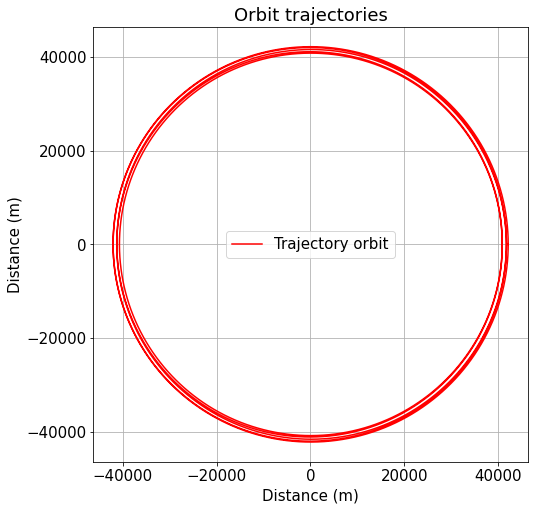

In [13]:
draw_orbit_trajectories(x_cart[:,0],y_cart[:,0])

[ 0.00000000e+00 -3.57071482e-01 -1.42825086e+00 ...  5.46552078e+02
  5.93927910e+02  6.40565902e+02] [    0.            51.52210795   103.03677287 ... -7432.24948143
 -7377.12561498 -7321.70176315]


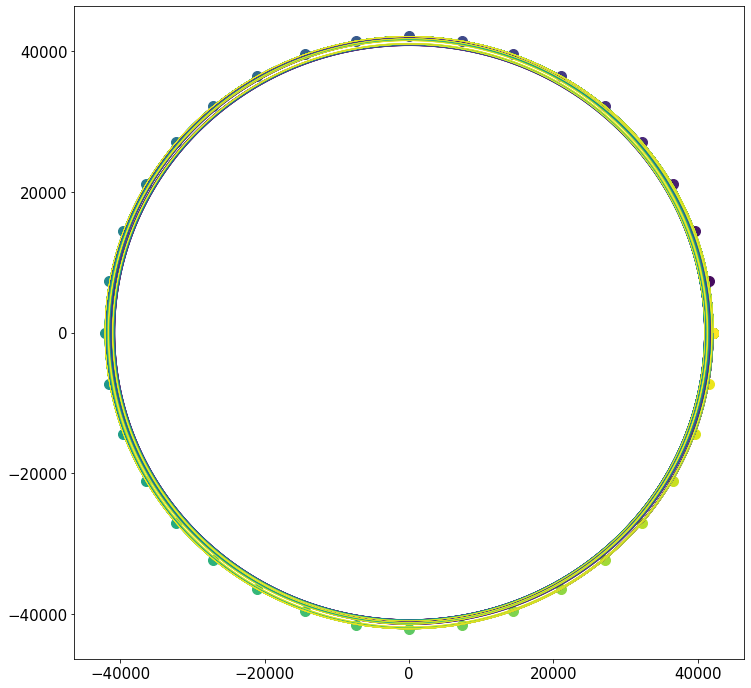

In [14]:
x_ecef,y_ecef=transform_to_ecef(x_cart[:,36],y_cart[:,36],time_table5000[:,36],omega_earth)
x_ecef10,y_ecef10=transform_to_ecef(x_cart[:,1],y_cart[:,1],time_table5000[:,1],omega_earth)
print(x_cart[:,36]-x_cart[:,1],y_cart[:,36]-y_cart[:,1])
colors = viridis(np.linspace(0, 1, len(thetaval)))
for i in range(len(thetaval)):
    plt.plot(x_cart[:,i],y_cart[:,i],color=colors[i], linewidth=0.3)
    plt.scatter(x_cart[0,i], y_cart[0,i],color=colors[i],s=100)
    plt.scatter(x_cart[-1,i], y_cart[-1,i],color=colors[i],s=100)
plt.savefig("allmanoeuvres.pdf")
#plt.plot(x_cart[:,36],y_cart[:,36],color="blue", linewidth=0.3)

#plt.scatter(x_cart[0,1], y_cart[0,1],color="red")
#plt.scatter(x_cart[-1,1], y_cart[-1,1],color="red")

#plt.scatter(x_cart[0,30], y_cart[0,30],color="blue")
#plt.scatter(x_cart[-1,30], y_cart[-1,30],color="blue")


Text(0, 0.5, 'Y (ECEF) [km]')

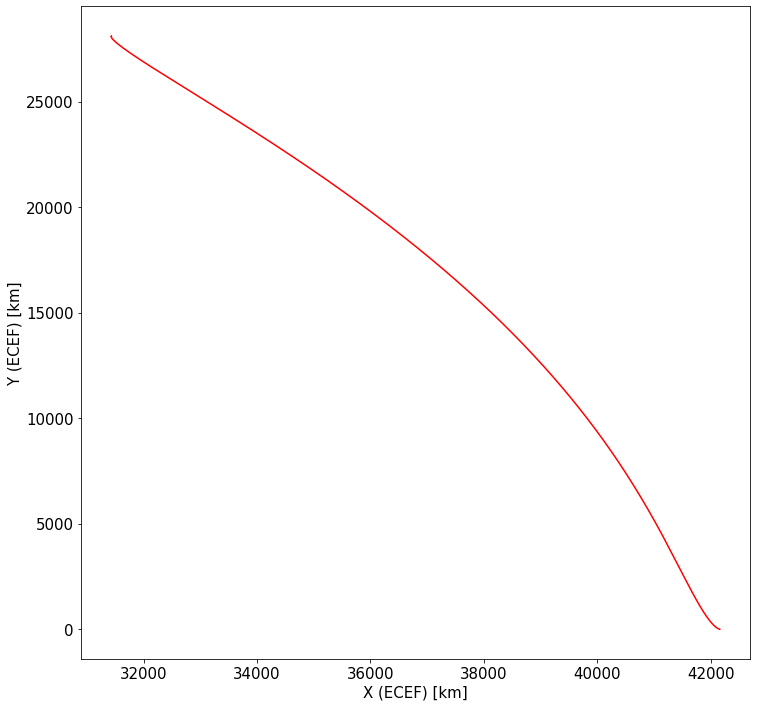

In [16]:
plt.plot(x_ecef, y_ecef, label='ECEF Frame', color='r')
plt.xlabel('X (ECEF) [km]')
plt.ylabel('Y (ECEF) [km]')

In [17]:
#Builds the Thrust vector for each phase shift for each number of measurements
#Builds XI vector for each phase shift for each number of measurements
#Builds the RMSE vector for thrust measurements for each phase shift for each number of measurements

#thrust estimation 4 state model
theta=theta.reshape((len(theta),1))
RMSEBIG_table=[]
XIBIG_table=[]
Thrust_sparseBIG_table=[]
for k in range(len(rBIG_tablearr)):
    print(k)
    j=0
    if k>4:
        la=6.3e-10
    else:
        la=3e-10
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   2,la,4)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([15,len(thetaval)])
        print(i)
        XI_table[:,i]=xi1.reshape([15,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))
        print(ThrustBIG_tablearr[k][:,i].shape,Thrust_sparse.shape)
        #RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_table.append(RMSE_table)
    XIBIG_table.append(XI_table)
    Thrust_sparseBIG_table.append(Thrust_sparse_table)
    print(k)

0
[[ 0.00000000e+00]
 [ 2.21061621e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60380539e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.40959136e-09]
 [ 0.00000000e+00]
 [-1.11663652e-08]
 [-3.04918723e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0
(10000,) (10000, 1)
[[ 0.00000000e+00]
 [ 2.14980334e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60022294e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.35444668e-09]
 [ 0.00000000e+00]
 [-1.09202456e-08]
 [-3.03947150e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
1
(10000,) (10000, 1)
[[ 0.00000000e+00]
 [ 2.09098684e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.59667688e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.30087743e-09]
 [ 0.00000000e+00]
 [-1.06808684e-08]
 [-3.02986219e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
2
(10000,) (10000, 1)
[[ 0.00000000e+00]
 [ 2.03409066e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00

34
(10000,) (10000, 1)
[[ 0.00000000e+00]
 [ 9.04044893e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.49700796e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.15137265e-09]
 [ 0.00000000e+00]
 [-5.46513982e-09]
 [-2.76282810e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
35
(10000,) (10000, 1)
[[ 0.00000000e+00]
 [ 8.83189558e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.49443455e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.12949256e-09]
 [ 0.00000000e+00]
 [-5.36414348e-09]
 [-2.75600950e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
36
(10000,) (10000, 1)
0
1
[[ 0.00000000e+00]
 [ 2.21129613e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60414442e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.40865323e-09]
 [ 0.00000000e+00]
 [-1.11698386e-08]
 [-3.05001886e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0
(5000,) (5000, 1)
[[ 0.00000000e+00]
 [ 2.15046455e-09]
 [ 0.000000

31
(5000,) (5000, 1)
[[ 0.00000000e+00]
 [ 9.70551831e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.50515397e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.21979211e-09]
 [ 0.00000000e+00]
 [-5.78452661e-09]
 [-2.78437481e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
32
(5000,) (5000, 1)
[[ 0.00000000e+00]
 [ 9.47848100e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.50251043e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.19627015e-09]
 [ 0.00000000e+00]
 [-5.67612646e-09]
 [-2.77735885e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
33
(5000,) (5000, 1)
[[ 0.00000000e+00]
 [ 9.25778689e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.49989013e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.17331446e-09]
 [ 0.00000000e+00]
 [-5.57025337e-09]
 [-2.77040851e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
34
(5000,) (5000, 1)
[[ 0.00000000e+00]
 [ 9.04323019e-10]
 [ 0.00000000e+00]
 

24
(1000,) (1000, 1)
[[ 0.00000000e+00]
 [ 1.15196957e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.52672339e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.39730751e-09]
 [ 0.00000000e+00]
 [-6.63696081e-09]
 [-2.84123484e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
25
(1000,) (1000, 1)
[[ 0.00000000e+00]
 [ 1.12410994e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.52389684e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.36939939e-09]
 [ 0.00000000e+00]
 [-6.50837168e-09]
 [-2.83370402e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
26
(1000,) (1000, 1)
[[ 0.00000000e+00]
 [ 1.09705489e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.52109591e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.34218715e-09]
 [ 0.00000000e+00]
 [-6.38288131e-09]
 [-2.82624597e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
27
(1000,) (1000, 1)
[[ 0.00000000e+00]
 [ 1.07077744e-09]
 [ 0.00000000e+00]
 

[[-3.07846248e-08]
 [ 1.88644821e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.61532948e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.07197891e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
7
(90,) (90, 1)
[[-3.01293274e-08]
 [ 1.83647159e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.61180444e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.06248782e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
8
(90,) (90, 1)
[[-2.94913731e-08]
 [ 1.78807535e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60831416e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.05309719e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
9
(90,) (90, 1)
[[-2.88702140e-08]
 [ 1.74120149e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60485812e-04]

[[-3.09227613e-08]
 [ 1.88483374e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.64061556e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.13302879e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
8
(50,) (50, 1)
[[-3.02680110e-08]
 [ 1.83516326e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.63697569e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.12325988e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
9
(50,) (50, 1)
[[-2.96304981e-08]
 [ 1.78705525e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.63337162e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.11359392e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
10
(50,) (50, 1)
[[-2.90096812e-08]
 [ 1.74045267e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.62980283e-04

[[ 3.02913382e-05]
 [-5.36280457e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.65756593e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.37098783e-03]
 [-7.44877969e-08]
 [ 0.00000000e+00]
 [-9.85965806e-06]
 [ 8.43514506e-08]
 [ 0.00000000e+00]
 [ 2.91968007e+01]
 [ 7.25130938e-05]]
35
(20,) (20, 1)
[[ 2.99685574e-05]
 [-5.28091978e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.69063363e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.25831096e-03]
 [-7.30049306e-08]
 [ 0.00000000e+00]
 [-9.75453302e-06]
 [ 8.48202001e-08]
 [ 0.00000000e+00]
 [ 2.93799061e+01]
 [ 7.21753548e-05]]
36
(20,) (20, 1)
14
15
[[ 3.49277196e-05]
 [-7.37490121e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.31491349e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.01557921e-02]
 [-1.47403863e-07]
 [ 0.00000000e+00]
 [-1.13756886e-05]
 [ 2.06802034e-08]
 [ 0.00000000e+00]
 [ 6.44002419e+00]
 [ 7.66464028e-05]]
0
(10,) (10, 1)
[[ 3.44844820e-05]
 [-7.24080601e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.33993

In [19]:

#thrust estimation 4 state model
theta=theta.reshape((len(theta),1))
RMSEBIG_tabletheta=[]
XIBIG_tabletheta=[]
Thrust_sparseBIG_tabletheta=[]
for k in range(len(rBIG_tablearr)):
    print(k)
    j=0
    la=3e-13
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   5,la,1)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([6,len(thetaval)])
        print(i)
        XI_table[:,i]=xi1.reshape([6,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        #RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tabletheta.append(RMSE_table)
    XIBIG_tabletheta.append(XI_table)
    Thrust_sparseBIG_tabletheta.append(Thrust_sparse_table)
    print(k)

0
[[-5.23614113e-08]
 [ 2.42501608e-08]
 [-2.75067561e-08]
 [ 3.29033818e-09]
 [-1.29231905e-10]
 [ 1.64543172e-12]]
0
[[-5.12231441e-08]
 [ 2.36110322e-08]
 [-2.68729275e-08]
 [ 3.19856594e-09]
 [-1.24948578e-10]
 [ 1.58210523e-12]]
1
[[-5.01158386e-08]
 [ 2.29922804e-08]
 [-2.62573115e-08]
 [ 3.10985003e-09]
 [-1.20829981e-10]
 [ 1.52154900e-12]]
2
[[-4.90384864e-08]
 [ 2.23931456e-08]
 [-2.56592820e-08]
 [ 3.02407230e-09]
 [-1.16868914e-10]
 [ 1.46362744e-12]]
3
[[-4.79901172e-08]
 [ 2.18129002e-08]
 [-2.50782380e-08]
 [ 2.94111977e-09]
 [-1.13058527e-10]
 [ 1.40821227e-12]]
4
[[-4.69697975e-08]
 [ 2.12508476e-08]
 [-2.45136021e-08]
 [ 2.86088442e-09]
 [-1.09392305e-10]
 [ 1.35518214e-12]]
5
[[-4.59766284e-08]
 [ 2.07063205e-08]
 [-2.39648201e-08]
 [ 2.78326293e-09]
 [-1.05864047e-10]
 [ 1.30442217e-12]]
6
[[-4.50097451e-08]
 [ 2.01786794e-08]
 [-2.34313591e-08]
 [ 2.70815643e-09]
 [-1.02467851e-10]
 [ 1.25582362e-12]]
7
[[-4.40683140e-08]
 [ 1.96673118e-08]
 [-2.29127074e-08]
 [ 2.

2
[[-4.90156951e-08]
 [ 2.23788670e-08]
 [-2.56565992e-08]
 [ 3.02386228e-09]
 [-1.16861681e-10]
 [ 1.46353685e-12]]
3
[[-4.79677107e-08]
 [ 2.17989389e-08]
 [-2.50756290e-08]
 [ 2.94091665e-09]
 [-1.13051570e-10]
 [ 1.40812561e-12]]
4
[[-4.69477672e-08]
 [ 2.12371949e-08]
 [-2.45110646e-08]
 [ 2.86068793e-09]
 [-1.09385611e-10]
 [ 1.35509921e-12]]
5
[[-4.59549659e-08]
 [ 2.06929678e-08]
 [-2.39623516e-08]
 [ 2.78307282e-09]
 [-1.05857605e-10]
 [ 1.30434280e-12]]
6
[[-4.49884421e-08]
 [ 2.01656187e-08]
 [-2.34289575e-08]
 [ 2.70797246e-09]
 [-1.02461651e-10]
 [ 1.25574762e-12]]
7
[[-4.40473626e-08]
 [ 1.96545350e-08]
 [-2.29103706e-08]
 [ 2.63529225e-09]
 [-9.91921286e-11]
 [ 1.20921071e-12]]
8
[[-4.31309255e-08]
 [ 1.91591297e-08]
 [-2.24060989e-08]
 [ 2.56494165e-09]
 [-9.60436875e-11]
 [ 1.16463448e-12]]
9
[[-4.22383577e-08]
 [ 1.86788401e-08]
 [-2.19156696e-08]
 [ 2.49683396e-09]
 [-9.30112294e-11]
 [ 1.12192650e-12]]
10
[[-4.13689146e-08]
 [ 1.82131263e-08]
 [-2.14386280e-08]
 [ 2

[[-2.68005320e-08]
 [ 1.07554232e-08]
 [-1.35892479e-08]
 [ 1.39478076e-09]
 [-4.64453083e-11]
 [ 4.99740872e-13]]
33
[[-2.63088655e-08]
 [ 1.05169361e-08]
 [-1.33268241e-08]
 [ 1.36194482e-09]
 [-4.51434104e-11]
 [ 4.83462970e-13]]
34
[[-2.58285046e-08]
 [ 1.02848622e-08]
 [-1.30707219e-08]
 [ 1.33003256e-09]
 [-4.38838919e-11]
 [ 4.67788240e-13]]
35
[[-2.53591380e-08]
 [ 1.00589992e-08]
 [-1.28207589e-08]
 [ 1.29901381e-09]
 [-4.26651833e-11]
 [ 4.52691655e-13]]
36
4
5
[[-5.20592203e-08]
 [ 2.40570235e-08]
 [-2.74698094e-08]
 [ 3.28739595e-09]
 [-1.29128859e-10]
 [ 1.64411969e-12]]
0
[[-5.09261403e-08]
 [ 2.34222588e-08]
 [-2.68370151e-08]
 [ 3.19572188e-09]
 [-1.24849520e-10]
 [ 1.58085095e-12]]
1
[[-4.98239039e-08]
 [ 2.28077485e-08]
 [-2.62223989e-08]
 [ 3.10710034e-09]
 [-1.20734736e-10]
 [ 1.52034964e-12]]
2
[[-4.87515064e-08]
 [ 2.22127368e-08]
 [-2.56253360e-08]
 [ 3.02141334e-09]
 [-1.16777316e-10]
 [ 1.46248029e-12]]
3
[[-4.77079806e-08]
 [ 2.16365001e-08]
 [-2.50452267e-08]

[[-2.78177845e-08]
 [ 1.12189276e-08]
 [-1.43682019e-08]
 [ 1.49585693e-09]
 [-5.05230805e-11]
 [ 5.51382720e-13]]
30
[[-2.72979724e-08]
 [ 1.09655634e-08]
 [-1.40868093e-08]
 [ 1.46015100e-09]
 [-4.90872134e-11]
 [ 5.33173490e-13]]
31
[[-2.67903144e-08]
 [ 1.07191296e-08]
 [-1.38122912e-08]
 [ 1.42546343e-09]
 [-4.76987327e-11]
 [ 5.15648316e-13]]
32
[[-2.62944700e-08]
 [ 1.04794043e-08]
 [-1.35444467e-08]
 [ 1.39176047e-09]
 [-4.63558593e-11]
 [ 4.98778422e-13]]
33
[[-2.58101098e-08]
 [ 1.02461735e-08]
 [-1.32830815e-08]
 [ 1.35900967e-09]
 [-4.50568892e-11]
 [ 4.82536372e-13]]
34
[[-2.53369155e-08]
 [ 1.00192313e-08]
 [-1.30280079e-08]
 [ 1.32717977e-09]
 [-4.38001894e-11]
 [ 4.66895999e-13]]
35
[[-2.48745785e-08]
 [ 9.79837910e-09]
 [-1.27790446e-08]
 [ 1.29624068e-09]
 [-4.25841951e-11]
 [ 4.51832344e-13]]
36
9
10
[[-5.12118708e-08]
 [ 2.35084156e-08]
 [-2.73643050e-08]
 [ 3.27897470e-09]
 [-1.28833672e-10]
 [ 1.64036126e-12]]
0
[[-5.00933247e-08]
 [ 2.28860401e-08]
 [-2.67344630e

[[-3.83958449e-08]
 [ 1.67238371e-08]
 [-2.11934610e-08]
 [ 2.41326481e-09]
 [-8.95176126e-11]
 [ 1.07413223e-12]]
11
[[-3.75968221e-08]
 [ 1.63039028e-08]
 [-2.07358447e-08]
 [ 2.34995220e-09]
 [-8.67236833e-11]
 [ 1.03518772e-12]]
12
[[-3.68184871e-08]
 [ 1.58966900e-08]
 [-2.02905538e-08]
 [ 2.28862346e-09]
 [-8.40309668e-11]
 [ 9.97848652e-13]]
13
[[-3.60602004e-08]
 [ 1.55017485e-08]
 [-1.98571910e-08]
 [ 2.22920641e-09]
 [-8.14352941e-11]
 [ 9.62040960e-13]]
14
[[-3.53213454e-08]
 [ 1.51186465e-08]
 [-1.94353739e-08]
 [ 2.17163184e-09]
 [-7.89326885e-11]
 [ 9.27694342e-13]]
15
[[-3.46013270e-08]
 [ 1.47469693e-08]
 [-1.90247343e-08]
 [ 2.11583342e-09]
 [-7.65193557e-11]
 [ 8.94742068e-13]]
16
[[-3.38995720e-08]
 [ 1.43863189e-08]
 [-1.86249176e-08]
 [ 2.06174751e-09]
 [-7.41916746e-11]
 [ 8.63120777e-13]]
17
[[-3.32155272e-08]
 [ 1.40363133e-08]
 [-1.82355824e-08]
 [ 2.00931308e-09]
 [-7.19461883e-11]
 [ 8.32770291e-13]]
18
[[-3.25486585e-08]
 [ 1.36965854e-08]
 [-1.78563997e-08]

In [23]:
#definition of our 2 models functions
def Thrusttheta(theta,XI):
    return np.dot(XI,[1,theta,theta**2,theta**3,theta**4,theta**5])
def Thrust4state(theta,r,thetadot,rdot,XI):
    return np.dot(XI,[1, theta, r, thetadot, rdot, theta**2, theta*r, theta*thetadot, theta*rdot, r**2, r*thetadot, r*rdot, thetadot**2, thetadot*rdot, rdot**2])


#definition for derivative of the states
def statedevthetapoly(y,t,mu,XIII):
    r,theta,rdot,thetadot = y
    dydt = [rdot, thetadot, r*thetadot**2 - mu/r**2,-2*(rdot/(thetadot*r))*thetadot**2+Thrusttheta(theta,XIII)/r]
    return dydt
def statedevtheta4(y,t,mu,XIII):
    r,theta,rdot,thetadot = y
    dydt = [rdot, thetadot, r*thetadot**2 - mu/r**2,-2*(rdot/(thetadot*r))*thetadot**2+Thrust4state(theta,r,thetadot,rdot,XIII)/r]
    return dydt


#propragate the orbit with the thrust models we obtain from SINDy
pospred=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_table[k][:,i]
        soltheta[:,:,i] = odeint(statedevtheta4, y0, time_table[:,i], args=(mu, XIII)) 
    pospred.append(soltheta)
    
    
pospredtheta=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tabletheta[k][:,i]
        soltheta[:,:,i] = odeint(statedevthetapoly, y0, time_table[:,i], args=(mu, XIII)) 
    pospredtheta.append(soltheta)

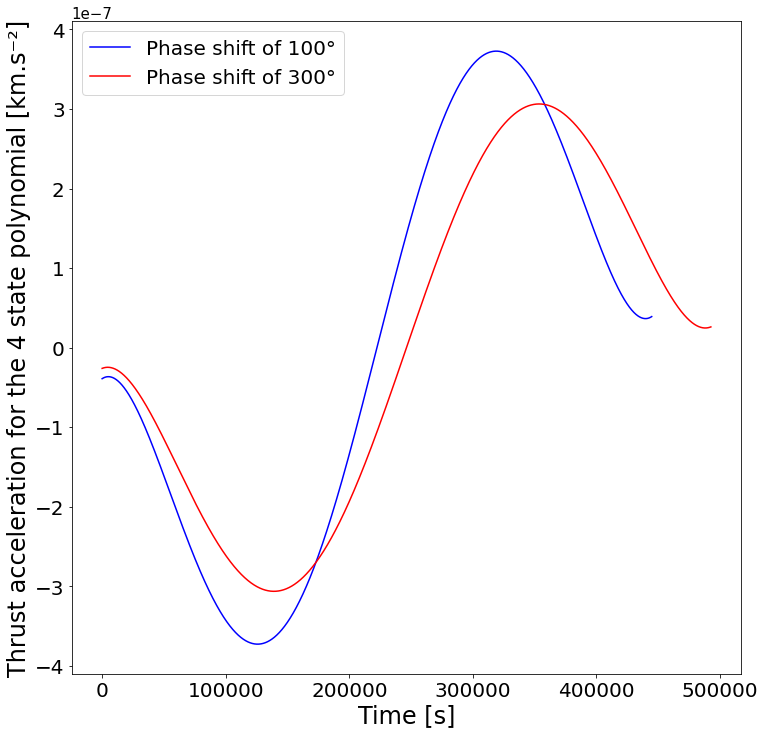

In [24]:
#plots for 2 different thrust profiles
plt.plot(time_table[:,10], Thrust_table[:,10], label="Phase shift of 100°", color="blue")
plt.plot(time_table[:,30], Thrust_table[:,30], label="Phase shift of 300°", color="red")

# Set axis labels with larger font size
plt.xlabel("Time [s]", fontsize=24)
plt.ylabel("Thrust acceleration for the 4 state polynomial [km.s⁻²]", fontsize=24)

# Increase the font size of the ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set the legend
plt.legend(fontsize=20)

# Save the figure with higher DPI
plt.savefig("thrustprofilecomp.png", dpi=300)

# Display the plot
plt.show()


# NOISE GENERATIONNNNNNNN

In [2]:
#definition for functions switching from polar to cartesian and then back from cartesian to polar
def polar_to_cartesian(r, theta, rdot, thetadot):
    r=np.array(r)
    theta = np.array(theta)
    rdot = np.array(rdot)
    thetadot = np.array(thetadot)
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    xdot = rdot * np.cos(theta) - r * thetadot * np.sin(theta)
    ydot = rdot * np.sin(theta) + r * thetadot * np.cos(theta)
    return x, y, xdot, ydot

def cartesian_to_polar(x, y, xdot, ydot):
    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    xdot = np.array(xdot)
    ydot = np.array(ydot)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    rdot = (x * xdot + y * ydot) / r
    thetadot = (x * ydot - xdot * y) / r**2
    return r, theta, rdot, thetadot

#d ef of the function to generate noise from the data (with mean = mean of noise, std_dev = its standard deviation,
# and theta = theta vector)
def Noisydata(mean,std_dev,theta):
    data=theta
    noise = np.random.normal(mean, std_dev, data.shape)
    noisydata=data+noise
    return noisydata
XBIG_table=[]
YBIG_table=[]
XdotBIG_table=[]
YdotBIG_table=[]
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        if i == 0:
            X = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            Y = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            Xdot = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            Ydot = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
        X[:,i], Y[:,i], Xdot[:,i], Ydot[:,i] = polar_to_cartesian(rBIG_tablearr[k][:,i],thetaBIG_tablearr[k][:,i],
                                                                  rdotBIG_tablearr[k][:,i],thetadotBIG_tablearr[k][:,i])
    XBIG_table.append(X)
    YBIG_table.append(Y)
    XdotBIG_table.append(Xdot)
    YdotBIG_table.append(Ydot)
    
    

XBIG_tablenoisylow=[]
XBIG_tablenoisymid=[]
XBIG_tablenoisyhigh=[]

YBIG_tablenoisylow=[]
YBIG_tablenoisymid=[]
YBIG_tablenoisyhigh=[]

XdotBIG_tablenoisylow=[]
XdotBIG_tablenoisymid=[]
XdotBIG_tablenoisyhigh=[]

YdotBIG_tablenoisylow=[]
YdotBIG_tablenoisymid=[]
YdotBIG_tablenoisyhigh=[]

#the 3 different noise environments standard deviation
lownoisevel=1e-4 #km.s-1
midnoisevel=1e-3
highnoisevel=1e-2

#generate thw noise on the Cartesian coordinates measurements for the two models
#convert to cartesian coordinates and add noise
for k in range(len(rBIG_tablearr)):
    xnoiselow=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ynoiselow=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    xdotnoiselow=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ydotnoiselow=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    xnoisemid=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ynoisemid=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    xdotnoisemid=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ydotnoisemid=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    xnoisehigh=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ynoisehigh=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    xdotnoisehigh=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    ydotnoisehigh=np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
    for i in range(len(thetaval)):
# #low level noise
        xnoiselow=Noisydata(0,0.5,XBIG_table[k])
        ynoiselow=Noisydata(0,0.5,YBIG_table[k])
        xdotnoiselow=Noisydata(0,lownoisevel,XdotBIG_table[k])
        ydotnoiselow=Noisydata(0,lownoisevel,YdotBIG_table[k])
# #mid level noise
        xnoisemid=Noisydata(0,5,XBIG_table[k])
        ynoisemid=Noisydata(0,5,YBIG_table[k])
        xdotnoisemid=Noisydata(0,midnoisevel,XdotBIG_table[k])
        ydotnoisemid=Noisydata(0,midnoisevel,YdotBIG_table[k])
# #high level noise
        xnoisehigh=Noisydata(0,10,XBIG_table[k])
        ynoisehigh=Noisydata(0,10,YBIG_table[k])
        xdotnoisehigh=Noisydata(0,highnoisevel,XdotBIG_table[k])
        ydotnoisehigh=Noisydata(0,highnoisevel,YdotBIG_table[k])
    
    
    XBIG_tablenoisylow.append(xnoiselow)
    XBIG_tablenoisymid.append(xnoisemid)
    XBIG_tablenoisyhigh.append(xnoisehigh)
    
    YBIG_tablenoisylow.append(ynoiselow)
    YBIG_tablenoisymid.append(ynoisemid)
    YBIG_tablenoisyhigh.append(ynoisehigh)
    
    XdotBIG_tablenoisylow.append(xdotnoiselow)
    XdotBIG_tablenoisymid.append(xdotnoisemid)
    XdotBIG_tablenoisyhigh.append(xdotnoisehigh)
    
    YdotBIG_tablenoisylow.append(ydotnoiselow)
    YdotBIG_tablenoisymid.append(ydotnoisemid)
    YdotBIG_tablenoisyhigh.append(ydotnoisehigh)
    
    

rBIG_tablenoisylow=[]
rBIG_tablenoisymid=[]
rBIG_tablenoisyhigh=[]

thetaBIG_tablenoisylow_wrapped=[]
thetaBIG_tablenoisymid_wrapped=[]
thetaBIG_tablenoisyhigh_wrapped=[]

thetaBIG_tablenoisylow=[]
thetaBIG_tablenoisymid=[]
thetaBIG_tablenoisyhigh=[]

rdotBIG_tablenoisylow=[]
rdotBIG_tablenoisymid=[]
rdotBIG_tablenoisyhigh=[]

thetadotBIG_tablenoisylow=[]
thetadotBIG_tablenoisymid=[]
thetadotBIG_tablenoisyhigh=[]
#convert back to polar
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        if i == 0:
            rn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetan = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            rdotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetadotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
        rn[:,i], thetan[:,i], rdotn[:,i], thetadotn[:,i] = cartesian_to_polar(XBIG_tablenoisylow[k][:,i],YBIG_tablenoisylow[k][:,i],
                                                                              XdotBIG_tablenoisylow[k][:,i],YdotBIG_tablenoisylow[k][:,i])
    rBIG_tablenoisylow.append(rn)
    thetaBIG_tablenoisylow_wrapped.append(thetan)
    rdotBIG_tablenoisylow.append(rdotn)
    thetadotBIG_tablenoisylow.append(thetadotn)
    
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        if i == 0:
            rn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetan = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            rdotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetadotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
        rn[:,i], thetan[:,i], rdotn[:,i], thetadotn[:,i] = cartesian_to_polar(XBIG_tablenoisymid[k][:,i],YBIG_tablenoisymid[k][:,i],
                                                                              XdotBIG_tablenoisymid[k][:,i],YdotBIG_tablenoisymid[k][:,i])
    rBIG_tablenoisymid.append(rn)
    thetaBIG_tablenoisymid_wrapped.append(thetan)
    rdotBIG_tablenoisymid.append(rdotn)
    thetadotBIG_tablenoisymid.append(thetadotn)
    
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        if i == 0:
            rn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetan = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            rdotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
            thetadotn = np.zeros([len(rBIG_tablearr[k]),len(thetaval)])
        rn[:,i], thetan[:,i], rdotn[:,i], thetadotn[:,i] = cartesian_to_polar(XBIG_tablenoisyhigh[k][:,i],YBIG_tablenoisyhigh[k][:,i],
                                                                              XdotBIG_tablenoisyhigh[k][:,i],YdotBIG_tablenoisyhigh[k][:,i])
    rBIG_tablenoisyhigh.append(rn)
    thetaBIG_tablenoisyhigh_wrapped.append(thetan)
    rdotBIG_tablenoisyhigh.append(rdotn)
    thetadotBIG_tablenoisyhigh.append(thetadotn)
    
    
    
## Manually adjusting the theta vector. From the transition it gives us back values between -2pi and 2pi
## However we need to unfold the theta vector from 0 to essentially infinity
# Function to convert negative values to positive values using the formula
def convert_negative_values(arr):
    for idx, i in enumerate(arr):
        if i < 0:
            arr[idx] = 2 * np.pi - abs(i)
            
            
def adjust_array_with_print(array, threshold=1e-12):#threshold=1e-10):
    # Convert the input to a NumPy array if it is not already
    array = np.array(array)
    
    # Identify values below the threshold
    below_threshold = np.abs(array) < threshold
    
    negative_below_threshold = array < 0
    # Print values below the threshold
    #if np.any(below_threshold):
        #print("Values below the threshold detected and set to 0:")
        #print(array[below_threshold])
    
    # Set values below the threshold to 0
    array[negative_below_threshold & below_threshold] = 0

    return array  # Ensure the modified array is returned

# Loop through the arrays and apply the function
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        thetaBIG_tablenoisyhigh_wrapped[k][:, i] = adjust_array_with_print(thetaBIG_tablenoisyhigh_wrapped[k][:, i], 5e-4)#e-3
        thetaBIG_tablenoisylow_wrapped[k][:, i] = adjust_array_with_print(thetaBIG_tablenoisylow_wrapped[k][:, i], 5e-4)
        thetaBIG_tablenoisymid_wrapped[k][:, i] = adjust_array_with_print(thetaBIG_tablenoisymid_wrapped[k][:, i], 5e-4)

#Convert negative values in each array
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        convert_negative_values(thetaBIG_tablenoisyhigh_wrapped[k][:,i])
        convert_negative_values(thetaBIG_tablenoisylow_wrapped[k][:,i])
        convert_negative_values(thetaBIG_tablenoisymid_wrapped[k][:,i])
    
# Initialize lists of lists to store the indices for each range
indices_2pi_4pi = [[[] for _ in range(len(thetaval))] for _ in range(len(rBIG_tablearr))]
indices_4pi_6pi = [[[] for _ in range(len(thetaval))] for _ in range(len(rBIG_tablearr))]
indices_6pi_8pi = [[[] for _ in range(len(thetaval))] for _ in range(len(rBIG_tablearr))]
indices_8pi_10pi = [[[] for _ in range(len(thetaval))] for _ in range(len(rBIG_tablearr))]
indices_10pi_12pi = [[[] for _ in range(len(thetaval))] for _ in range(len(rBIG_tablearr))]

# Iterate through the array and save the indices of the numbers that satisfy each condition
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        for idx, value in enumerate(thetaBIG_tablearr[k][:, i]):
            if 2 * np.pi < value < 4 * np.pi:
                indices_2pi_4pi[k][i].append(idx)
            elif 4 * np.pi < value < 6 * np.pi:
                indices_4pi_6pi[k][i].append(idx)
            elif 6 * np.pi < value < 8 * np.pi:
                indices_6pi_8pi[k][i].append(idx)
            elif 8 * np.pi < value < 10 * np.pi:
                indices_8pi_10pi[k][i].append(idx)
            elif 10 * np.pi < value < 12 * np.pi:
                indices_10pi_12pi[k][i].append(idx)
                
thetaBIG_tablenoisylow=thetaBIG_tablenoisylow_wrapped
thetaBIG_tablenoisymid=thetaBIG_tablenoisymid_wrapped
thetaBIG_tablenoisyhigh=thetaBIG_tablenoisyhigh_wrapped
# Append 2pi, 4pi, 6pi, 8pi, and 10pi to the values at the respective indices
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        for idx in indices_2pi_4pi[k][i]:
            thetaBIG_tablenoisylow[k][:, i][idx] += 2 * np.pi
        for idx in indices_4pi_6pi[k][i]:
            thetaBIG_tablenoisylow[k][:, i][idx] += 4 * np.pi
        for idx in indices_6pi_8pi[k][i]:
            thetaBIG_tablenoisylow[k][:, i][idx] += 6 * np.pi
        for idx in indices_8pi_10pi[k][i]:
            thetaBIG_tablenoisylow[k][:, i][idx] += 8 * np.pi
        for idx in indices_10pi_12pi[k][i]:
            thetaBIG_tablenoisylow[k][:, i][idx] += 10 * np.pi

            
            
            # Append 2pi, 4pi, 6pi, 8pi, and 10pi to the values at the respective indices
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        for idx in indices_2pi_4pi[k][i]:
            thetaBIG_tablenoisymid[k][:, i][idx] += 2 * np.pi
        for idx in indices_4pi_6pi[k][i]:
            thetaBIG_tablenoisymid[k][:, i][idx] += 4 * np.pi
        for idx in indices_6pi_8pi[k][i]:
            thetaBIG_tablenoisymid[k][:, i][idx] += 6 * np.pi
        for idx in indices_8pi_10pi[k][i]:
            thetaBIG_tablenoisymid[k][:, i][idx] += 8 * np.pi
        for idx in indices_10pi_12pi[k][i]:
            thetaBIG_tablenoisymid[k][:, i][idx] += 10 * np.pi
            
            
            

# Append 2pi, 4pi, 6pi, 8pi, and 10pi to the values at the respective indices
for k in range(len(rBIG_tablearr)):
    for i in range(len(thetaval)):
        for idx in indices_2pi_4pi[k][i]:
            thetaBIG_tablenoisyhigh[k][idx, i] += 2 * np.pi
        for idx in indices_4pi_6pi[k][i]:
            thetaBIG_tablenoisyhigh[k][idx, i] += 4 * np.pi
        for idx in indices_6pi_8pi[k][i]:
            thetaBIG_tablenoisyhigh[k][idx, i] += 6 * np.pi
        for idx in indices_8pi_10pi[k][i]:
            thetaBIG_tablenoisyhigh[k][idx, i] += 8 * np.pi
        for idx in indices_10pi_12pi[k][i]:
            thetaBIG_tablenoisyhigh[k][idx, i] += 10 * np.pi
# def adjust_values(values):
#     adjusted = np.copy(values)
#     for k in range(len(values)):
#         for i in range(len(thetaval)):
#             for j in range(len(values[k])):
#                 if 2 * np.pi < values[k] [j, i] < 4 * np.pi:
#                     adjusted[k] [j, i] += 2 * np.pi
#                 elif 4 * np.pi < values[k] [j, i] < 6 * np.pi:
#                     adjusted[k] [j, i] += 4 * np.pi
#                 elif 6 * np.pi < values[k] [j, i] < 8 * np.pi:
#                     adjusted[k] [j, i] += 6 * np.pi
#                 elif 8 * np.pi < values[k] [j, i] < 10 * np.pi:
#                     adjusted[k] [j, i] += 8 * np.pi
#                 elif 10 * np.pi < values[k] [j, i] < 12 * np.pi:
#                     adjusted[k] [j, i] += 10 * np.pi
#     return adjusted

# # Adjust the values for each noisy wrapped array
# thetaBIG_tablenoisylow=adjust_values(thetaBIG_tablenoisylow_wrapped)
# thetaBIG_tablenoisymid=adjust_values(thetaBIG_tablenoisymid_wrapped)
# thetaBIG_tablenoisyhigh=adjust_values(thetaBIG_tablenoisyhigh_wrapped)
        



NameError: name 'rBIG_tablearr' is not defined

In [30]:
#4states 2nd degree polynomial with noise thrust estimations
theta=theta.reshape((len(theta),1))
RMSEBIG_tablelownoise=[]
XIBIG_tablelownoise=[]
Thrust_sparseBIG_tablelownoise=[]
for k in range(len(rBIG_tablearr)):
    print(str(k)+"low")
    j=0
    if k<4:
        la=6.3e-10
    else:
        la=3e-10
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   2,la,4)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([15,len(thetaval)])
        XI_table[:,i]=xi1.reshape([15,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablelownoise.append(RMSE_table)
    XIBIG_tablelownoise.append(XI_table)
    Thrust_sparseBIG_tablelownoise.append(Thrust_sparse_table)
    
RMSEBIG_tablemidnoise=[]
XIBIG_tablemidnoise=[]
Thrust_sparseBIG_tablemidnoise=[]
for k in range(len(rBIG_tablearr)):
    print(str(k)+"mid")
    j=0
    if k>4:
        la=3e-9
    else:
        la=3e-10
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   2,la,4)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([15,len(thetaval)])
        XI_table[:,i]=xi1.reshape([15,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablemidnoise.append(RMSE_table)
    XIBIG_tablemidnoise.append(XI_table)
    Thrust_sparseBIG_tablemidnoise.append(Thrust_sparse_table)
    
    
    
RMSEBIG_tablehighnoise=[]
XIBIG_tablehighnoise=[]
Thrust_sparseBIG_tablehighnoise=[]
for k in range(len(rBIG_tablearr)):
    #print(str(k)+"high")
    j=0
    if k>4:
        la=6.3e-10
    else:
        la=6.3e-10
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   2,la,4)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([15,len(thetaval)])
        XI_table[:,i]=xi1.reshape([15,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablehighnoise.append(RMSE_table)
    XIBIG_tablehighnoise.append(XI_table)
    Thrust_sparseBIG_tablehighnoise.append(Thrust_sparse_table)

0low
[[ 0.00000000e+00]
 [ 1.54387254e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.46013580e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.75375828e-09]
 [ 0.00000000e+00]
 [-7.78055028e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 2.07971763e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.56445585e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.25400277e-09]
 [ 0.00000000e+00]
 [-1.05791426e-08]
 [-2.95290017e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 2.07090105e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.58386880e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.64970416e-09]
 [ 0.00000000e+00]
 [-1.06847945e-08]
 [-2.99991669e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.96216514e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.55854286e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0

[[ 0.00000000e+00]
 [ 9.81592831e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.45495736e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.44356719e-09]
 [ 0.00000000e+00]
 [-5.73009619e-09]
 [-2.66211161e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 9.62778621e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.45861940e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 5.85964896e-09]
 [ 0.00000000e+00]
 [-5.76390336e-09]
 [-2.67498851e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 9.10196669e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.44926021e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.27396574e-09]
 [ 0.00000000e+00]
 [-5.32997000e-09]
 [-2.64708970e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 8.96912647e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.44666802e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.0000

[[ 0.00000000e+00]
 [ 1.24919449e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.48170819e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.48200654e-09]
 [ 0.00000000e+00]
 [-7.13400225e-09]
 [-2.73569592e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.14623202e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.49529546e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.21867623e-09]
 [ 0.00000000e+00]
 [-6.52107119e-09]
 [-2.76417866e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.60934653e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.54932171e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.60646253e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.60676448e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.25859166e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.52321274e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.52252939e-08]
 [ 0.00000000e+00]
 [-7.37428509e-09]
 [-2.84145401e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.18842638e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.43003156e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.47894138e-09]
 [ 0.00000000e+00]
 [-6.62605245e-09]
 [-2.60648551e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.27654802e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.62313748e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.

[[ 0.00000000e+00]
 [ 9.38782998e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.32585420e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.78841278e-09]
 [ 0.00000000e+00]
 [-5.67428296e-09]
 [-2.35697188e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.60172272e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.56136659e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[ 0.00000000e+00]
 [ 1.01202306e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.61224343e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.18765008e-09]
 [ 0.00000000e+00]
 [-5.69117981e-09]
 [-3.04030620e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 9.10776568e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.48573766e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.

[[-2.00912779e-05]
 [ 4.09527624e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.22277604e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.59427010e-03]
 [ 1.00968535e-07]
 [ 0.00000000e+00]
 [ 6.52595600e-06]
 [-6.81988999e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.87465675e-05]]
[[-1.61437629e-05]
 [ 3.29353635e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.95363238e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.49545749e-03]
 [ 7.30087742e-08]
 [ 0.00000000e+00]
 [ 5.24285578e-06]
 [-6.18813947e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.78470583e-05]]
[[-3.31972114e-05]
 [ 3.77828297e-07]
 [ 0.00000000e+00]
 [-1.03600084e-01]
 [ 3.03053374e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.16010563e-03]
 [ 3.83602570e-08]
 [ 0.00000000e+00]
 [ 1.32486638e-05]
 [-6.33953668e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.87907952e-05]]
[[-6.89249658e-05]
 [ 3.94671052e-07]
 [ 4.05357991e-10]
 [-1.33107806e-07]
 [ 3.14953703e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.3912

[[ 3.66523863e-05]
 [ 3.17717658e-07]
 [-4.41327055e-10]
 [ 0.00000000e+00]
 [ 3.56532199e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.34589684e-03]
 [-1.12280659e-08]
 [ 0.00000000e+00]
 [-5.87372532e-06]
 [-7.57905103e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.36286133e-05]]
[[-7.56223417e-05]
 [ 7.26592380e-07]
 [ 0.00000000e+00]
 [-2.48434093e-01]
 [ 5.48441122e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.95666480e-03]
 [ 1.21132584e-07]
 [ 0.00000000e+00]
 [ 3.04865236e-05]
 [-1.20350906e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.43757268e-05]]
[[ 2.21129867e-05]
 [ 8.58255183e-07]
 [-5.65095893e-10]
 [ 0.00000000e+00]
 [ 6.32487229e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.17631197e-02]
 [-1.45778605e-08]
 [ 0.00000000e+00]
 [ 5.55164316e-07]
 [-1.39308560e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.34739094e-04]]
[[-2.37662166e-05]
 [ 4.32072415e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.03066110e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.9112

[[ 3.19725276e-05]
 [ 6.16654250e-07]
 [-5.41206908e-10]
 [ 0.00000000e+00]
 [ 5.46665409e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.44613484e-03]
 [-4.43520955e-08]
 [ 0.00000000e+00]
 [-2.98314833e-06]
 [-1.19793078e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.71374306e-05]]
[[ 5.87966868e-05]
 [ 5.24426431e-07]
 [-7.15344945e-10]
 [ 1.36444021e-06]
 [ 4.62800438e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.19113289e-03]
 [-1.52329482e-07]
 [ 0.00000000e+00]
 [-9.31453859e-06]
 [-9.92891498e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 9.62015991e-05]]
[[-4.10580642e-05]
 [ 7.06959611e-07]
 [ 0.00000000e+00]
 [-1.10614299e-02]
 [ 5.76119922e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.68388012e-03]
 [-4.00572099e-08]
 [ 0.00000000e+00]
 [ 1.36120905e-05]
 [-1.26333097e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 5.45863075e-05]]
[[-3.21952451e-05]
 [ 5.73140201e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 5.81521838e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.8480

 [0.00000000e+00]]
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.4568896e-10]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
[[-9.72530261e-04]
 [ 0.00000000e+00]
 [ 7.80219420e-09]
 [-6.78334199e-08]
 [-1.41677515e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.09303419e-04]
 [ 1.18614443e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.14787445e-06]]
18low
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.05021408e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]

[[ 2.50102567e-06]
 [ 5.98209947e-06]
 [-2.34990081e-09]
 [ 0.00000000e+00]
 [ 2.28193374e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.20893930e-02]
 [-9.87666278e-08]
 [ 0.00000000e+00]
 [ 3.14331172e-05]
 [-5.17743388e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.39977543e-04]]
[[-1.66948434e-06]
 [ 5.58651340e-06]
 [-2.17515519e-09]
 [ 0.00000000e+00]
 [ 2.16378565e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.66603122e-02]
 [-1.26474537e-08]
 [ 0.00000000e+00]
 [ 3.03901555e-05]
 [-4.90829664e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.50440015e-04]]
[[ 3.70071212e-06]
 [ 5.87043186e-06]
 [-2.34172600e-09]
 [ 0.00000000e+00]
 [ 2.31227181e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.05557527e-02]
 [-8.21986376e-08]
 [ 0.00000000e+00]
 [ 3.09292186e-05]
 [-5.24973287e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.46585145e-04]]
[[ 6.45535705e-06]
 [ 5.76773972e-06]
 [-2.37619917e-09]
 [ 0.00000000e+00]
 [ 2.30391659e-03]
 [ 3.25697393e-10]
 [ 0.00000000e+00]
 [-7.9293

[[ 1.26298318e-06]
 [ 4.60916911e-06]
 [-2.07733689e-09]
 [ 0.00000000e+00]
 [ 2.55811244e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.32514891e-02]
 [-2.87241571e-07]
 [ 0.00000000e+00]
 [ 2.80971707e-05]
 [-5.80999617e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.53857987e-06]
 [-2.04473353e-09]
 [ 0.00000000e+00]
 [ 2.52795525e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.22831666e-02]
 [-3.05076627e-07]
 [ 0.00000000e+00]
 [ 2.80612271e-05]
 [-5.73736408e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 9.14889072e-07]
 [ 4.52571619e-06]
 [-2.05644579e-09]
 [ 0.00000000e+00]
 [ 2.54819035e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.21068938e-02]
 [-2.73818260e-07]
 [ 0.00000000e+00]
 [ 2.79237828e-05]
 [-5.78524484e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 1.99247067e-06]
 [ 4.45689956e-06]
 [-2.04330301e-09]
 [ 0.00000000e+00]
 [ 2.55427831e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.1161

[[ 3.67261299e-07]
 [ 4.92029126e-06]
 [-2.14251103e-09]
 [ 0.00000000e+00]
 [ 2.49437904e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.75196544e-02]
 [-1.53585705e-07]
 [ 0.00000000e+00]
 [ 2.92818484e-05]
 [-5.66677844e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.06235118e-04]]
[[ 2.17745359e-06]
 [ 4.83414866e-06]
 [-2.12993934e-09]
 [ 0.00000000e+00]
 [ 2.48743849e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.63382245e-02]
 [-1.06692174e-07]
 [ 0.00000000e+00]
 [ 2.85202531e-05]
 [-5.65348063e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.19259907e-04]]
[[-2.24216035e-06]
 [ 4.83283171e-06]
 [-2.10535609e-09]
 [ 0.00000000e+00]
 [ 2.49807317e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.63210002e-02]
 [-2.38466208e-08]
 [ 0.00000000e+00]
 [ 2.96198608e-05]
 [-5.67957921e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.67809884e-04]]
[[-2.03559102e-06]
 [ 4.73563788e-06]
 [-2.07392719e-09]
 [ 0.00000000e+00]
 [ 2.49483888e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.4986

[[-9.93853993e-05]
 [ 2.50866815e-06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.10886325e-03]
 [-1.71671920e-09]
 [ 0.00000000e+00]
 [-3.36230987e-02]
 [-9.83681338e-07]
 [ 0.00000000e+00]
 [ 3.23108996e-05]
 [-2.42729289e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.10840583e-04]]
[[-2.60848754e-06]
 [ 4.70652479e-06]
 [-1.95145981e-09]
 [ 0.00000000e+00]
 [ 2.19073807e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.45830599e-02]
 [-3.03718249e-07]
 [ 0.00000000e+00]
 [ 2.76282072e-05]
 [-4.95941832e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 3.56508369e-07]
 [ 5.18266452e-06]
 [-2.19270016e-09]
 [ 0.00000000e+00]
 [ 2.45911912e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.11198966e-02]
 [-4.10638610e-08]
 [ 0.00000000e+00]
 [ 2.99736333e-05]
 [-5.59184492e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.93170301e-04]]
[[-3.00232209e-06]
 [ 5.07629066e-06]
 [-2.13127000e-09]
 [ 0.00000000e+00]
 [ 2.42615745e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.9660

[[-7.58643034e-06]
 [ 5.54222998e-06]
 [-2.19877161e-09]
 [ 0.00000000e+00]
 [ 2.39855082e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.60537958e-02]
 [-9.67077193e-08]
 [ 0.00000000e+00]
 [ 3.26411639e-05]
 [-5.44870163e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.01776158e-04]]
[[-6.80352010e-06]
 [ 5.41052986e-06]
 [-2.16325127e-09]
 [ 0.00000000e+00]
 [ 2.38653690e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.42427056e-02]
 [-5.48760465e-08]
 [ 0.00000000e+00]
 [ 3.18984677e-05]
 [-5.42501599e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.07832272e-04]]
[[-2.30323143e-07]
 [ 5.43857606e-06]
 [-2.23928622e-09]
 [ 0.00000000e+00]
 [ 2.40995995e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.46279359e-02]
 [-5.29695496e-08]
 [ 0.00000000e+00]
 [ 3.08020755e-05]
 [-5.47673807e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.55278150e-04]]
[[-8.88168598e-07]
 [ 5.29994248e-06]
 [-2.19189740e-09]
 [ 0.00000000e+00]
 [ 2.39363536e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.2733

[[-2.33725379e-04]
 [ 0.00000000e+00]
 [ 5.21721067e-09]
 [ 2.78766069e+00]
 [ 4.79241927e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.95163363e-07]
 [ 0.00000000e+00]
 [-6.16435223e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.78040700e-03]]
[[-2.56956843e-04]
 [ 2.86799337e-06]
 [ 5.62599443e-09]
 [ 4.06590739e+00]
 [ 1.01162316e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.94130119e-02]
 [ 2.22602856e-07]
 [ 0.00000000e+00]
 [-8.99783671e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.56330287e-04]]
[[-5.70678941e-05]
 [ 2.48726581e-06]
 [ 0.00000000e+00]
 [ 5.57273097e-01]
 [ 9.34618451e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.41958243e-02]
 [ 3.20169897e-07]
 [ 0.00000000e+00]
 [ 5.38620057e-06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.49622233e-04]]
[[ 2.11855377e-04]
 [ 2.36737053e-06]
 [-5.73582449e-09]
 [-2.48119964e+00]
 [ 1.02440590e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.2551

[[-7.73970897e-05]
 [ 5.93815229e-06]
 [ 0.00000000e+00]
 [ 1.40136395e+00]
 [ 9.91557599e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.14970657e-02]
 [-6.52231786e-09]
 [ 0.00000000e+00]
 [-8.03949608e-06]
 [-1.63657646e-07]
 [ 0.00000000e+00]
 [-4.00834601e+01]
 [ 5.27518973e-06]]
[[-9.89571627e-05]
 [ 5.99710810e-06]
 [ 0.00000000e+00]
 [ 1.27374234e+00]
 [ 1.76626192e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.22812503e-02]
 [-4.52168721e-07]
 [ 0.00000000e+00]
 [ 1.99614665e-06]
 [-4.34480085e-08]
 [ 0.00000000e+00]
 [ 2.35543761e+00]
 [ 2.15173731e-04]]
[[-4.91290361e-05]
 [ 5.67946425e-06]
 [ 0.00000000e+00]
 [ 1.53275766e+00]
 [-3.24458182e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.79337007e-02]
 [ 4.23244543e-07]
 [ 0.00000000e+00]
 [-2.03567872e-05]
 [ 2.85668756e-08]
 [ 0.00000000e+00]
 [ 2.91868254e+01]
 [-2.52057764e-04]]
[[-8.77075337e-05]
 [ 5.62682246e-06]
 [ 0.00000000e+00]
 [ 1.24832002e+00]
 [ 2.50585439e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.7186

[[ 3.54181440e-04]
 [ 3.69807202e-06]
 [-1.39279781e-08]
 [-8.00281365e+00]
 [-1.11021745e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.07797057e-02]
 [-3.71928610e-07]
 [ 0.00000000e+00]
 [ 2.65647561e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.64630884e+01]
 [-9.28696672e-04]]
[[-4.90758512e-03]
 [-4.12707245e-05]
 [ 4.80514088e-08]
 [ 4.36284628e-02]
 [-3.26441688e-02]
 [ 5.68342750e-08]
 [ 0.00000000e+00]
 [ 5.40811701e-01]
 [ 1.70778304e-04]
 [ 0.00000000e+00]
 [ 9.34701039e-04]
 [ 6.99610394e-07]
 [ 0.00000000e+00]
 [-2.50767896e-04]
 [-5.62070117e-02]]
[[-8.53654937e-04]
 [ 2.90117966e-06]
 [ 4.97145070e-09]
 [-1.32786764e-04]
 [ 4.23446083e-03]
 [ 4.32683490e-09]
 [ 0.00000000e+00]
 [-4.16927432e-02]
 [ 1.10748043e-05]
 [ 0.00000000e+00]
 [ 2.09394072e-04]
 [-1.04957028e-07]
 [ 0.00000000e+00]
 [ 1.47644657e-06]
 [-2.97559614e-03]]
[[-1.68259512e-03]
 [-1.89903969e-06]
 [ 1.82266398e-08]
 [ 1.50296207e+00]
 [ 3.52019346e-04]
 [-1.03854582e-08]
 [ 0.00000000e+00]
 [ 3.1183

[[ 4.81955151e-06]
 [ 5.62046280e-06]
 [-2.21936977e-09]
 [ 0.00000000e+00]
 [ 5.91861093e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.73232401e-02]
 [-2.50096478e-08]
 [ 0.00000000e+00]
 [ 2.89555041e-05]
 [-1.07473430e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 3.44810998e-06]
 [ 5.53738929e-06]
 [-2.18462891e-09]
 [ 0.00000000e+00]
 [ 5.84878931e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.61910632e-02]
 [-3.62825246e-08]
 [ 0.00000000e+00]
 [ 2.89309459e-05]
 [-1.05766325e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 4.19937226e-06]
 [ 5.46741081e-06]
 [-2.18237360e-09]
 [ 0.00000000e+00]
 [ 5.61704184e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.52233478e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.86482196e-05]
 [-1.00301775e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 8.86712633e-07]
 [ 5.42504782e-06]
 [-2.14408686e-09]
 [ 0.00000000e+00]
 [ 5.68400760e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.4642

[[ 0.00000000e+00]
 [ 4.02423696e-06]
 [-1.80183070e-09]
 [ 0.00000000e+00]
 [ 4.70422178e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.53651648e-02]
 [-4.37037147e-08]
 [ 0.00000000e+00]
 [ 2.47848996e-05]
 [-7.77165239e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 3.99209473e-06]
 [-1.79376162e-09]
 [ 0.00000000e+00]
 [ 4.96105929e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.49191876e-02]
 [-6.54999198e-09]
 [ 0.00000000e+00]
 [ 2.46736435e-05]
 [-8.41530829e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 3.97182704e-06]
 [-1.79405092e-09]
 [ 0.00000000e+00]
 [ 4.88610425e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.46405718e-02]
 [ 1.11277213e-09]
 [ 0.00000000e+00]
 [ 2.46768904e-05]
 [-8.23550449e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 3.90918532e-06]
 [-1.77222534e-09]
 [ 0.00000000e+00]
 [ 4.97559992e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.3781

[[ 0.00000000e+00]
 [ 4.41043232e-06]
 [-1.90477523e-09]
 [ 0.00000000e+00]
 [ 4.81336849e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.06775838e-02]
 [-2.31863544e-08]
 [ 0.00000000e+00]
 [ 2.61992493e-05]
 [-8.05237382e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.33394578e-06]
 [-1.87846783e-09]
 [ 0.00000000e+00]
 [ 4.88367357e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.96231066e-02]
 [-6.26395010e-09]
 [ 0.00000000e+00]
 [ 2.58358586e-05]
 [-8.23161814e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.30368375e-06]
 [-1.87482645e-09]
 [ 0.00000000e+00]
 [ 4.90150699e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.92065047e-02]
 [-3.76812280e-08]
 [ 0.00000000e+00]
 [ 2.57864285e-05]
 [-8.26624848e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.24719843e-06]
 [-1.85991200e-09]
 [ 0.00000000e+00]
 [ 4.85679398e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.8436

[[ 0.00000000e+00]
 [ 4.52899797e-06]
 [-1.79278907e-09]
 [ 0.00000000e+00]
 [ 4.89074197e-04]
 [-7.90159196e-10]
 [ 0.00000000e+00]
 [-6.19591065e-02]
 [-2.37370881e-08]
 [ 0.00000000e+00]
 [ 2.46495798e-05]
 [-8.27878520e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[-2.50905912e-07]
 [ 4.60982334e-06]
 [-1.93681781e-09]
 [ 0.00000000e+00]
 [ 5.52458471e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.34335618e-02]
 [-1.02318456e-08]
 [ 0.00000000e+00]
 [ 2.67298619e-05]
 [-9.79435346e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.65619486e-05]]
[[ 0.00000000e+00]
 [ 4.60393052e-06]
 [-1.94426800e-09]
 [ 0.00000000e+00]
 [ 5.17898456e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.33436604e-02]
 [-3.05642037e-08]
 [ 0.00000000e+00]
 [ 2.67460680e-05]
 [-8.93356916e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.55277657e-06]
 [-1.93149409e-09]
 [ 0.00000000e+00]
 [ 5.03894522e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.2641

[[ 0.00000000e+00]
 [ 4.69218882e-06]
 [-1.98356178e-09]
 [ 0.00000000e+00]
 [ 4.67728694e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.45412306e-02]
 [-8.61711507e-08]
 [ 0.00000000e+00]
 [ 2.72804634e-05]
 [-7.68236171e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.60803730e-06]
 [-1.96612307e-09]
 [ 0.00000000e+00]
 [ 5.41893865e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.33863632e-02]
 [-1.22942693e-07]
 [ 0.00000000e+00]
 [ 2.70342649e-05]
 [-9.48418153e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.60198843e-06]
 [-1.97112327e-09]
 [ 0.00000000e+00]
 [ 4.85958945e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.33046641e-02]
 [-6.11899322e-09]
 [ 0.00000000e+00]
 [ 2.71051735e-05]
 [-8.17123924e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[-1.82784292e-06]
 [ 4.39814184e-06]
 [-1.87570885e-09]
 [ 0.00000000e+00]
 [ 5.43786109e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.0516

[[ 0.00000000e+00]
 [ 4.33736193e-06]
 [-1.89035826e-09]
 [ 0.00000000e+00]
 [ 5.94363525e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.96523222e-02]
 [-1.20063275e-08]
 [ 0.00000000e+00]
 [ 2.59983457e-05]
 [-1.07793099e-08]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.17487465e-06]
 [-1.85342420e-09]
 [ 0.00000000e+00]
 [ 4.70020763e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.74359767e-02]
 [ 4.21882934e-08]
 [ 0.00000000e+00]
 [ 2.54824000e-05]
 [-7.79809564e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.04214831e-06]
 [-1.76040547e-09]
 [ 0.00000000e+00]
 [ 3.46564559e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.56517321e-02]
 [-4.15604252e-08]
 [ 0.00000000e+00]
 [ 2.42458392e-05]
 [-4.77652047e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 4.09788670e-06]
 [-1.80673527e-09]
 [ 0.00000000e+00]
 [ 5.20585775e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.6387

[[-1.21496136e-04]
 [ 5.05400401e-06]
 [ 9.70214190e-10]
 [ 1.68325374e+00]
 [-3.64466176e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.95090105e-02]
 [-1.46370035e-07]
 [ 0.00000000e+00]
 [-1.36313612e-05]
 [ 5.10795943e-08]
 [ 0.00000000e+00]
 [ 2.23827116e+01]
 [ 1.44683732e-04]]
[[-3.01086645e-04]
 [ 5.03231428e-06]
 [ 5.38373285e-09]
 [ 4.18577123e+00]
 [-4.21962108e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.92589183e-02]
 [ 7.27240477e-07]
 [ 0.00000000e+00]
 [-7.50780878e-05]
 [ 5.98270571e-08]
 [ 0.00000000e+00]
 [ 2.50429568e+01]
 [-1.57741152e-04]]
[[ 5.05312298e-05]
 [ 5.10672667e-06]
 [-3.12199583e-09]
 [-5.27571287e-01]
 [-5.52781410e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.02167216e-02]
 [-9.80447590e-07]
 [ 0.00000000e+00]
 [ 3.89531949e-05]
 [ 7.63356139e-08]
 [ 0.00000000e+00]
 [ 3.37483982e+01]
 [ 3.45239864e-04]]
[[-1.16503353e-04]
 [ 5.21753232e-06]
 [ 0.00000000e+00]
 [ 9.93936392e-01]
 [-4.88307191e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.1665

[[-8.60300455e-04]
 [ 6.15221530e-06]
 [ 1.89932564e-08]
 [ 1.16981468e+01]
 [-1.55729709e-03]
 [-3.98849611e-09]
 [ 0.00000000e+00]
 [-8.27381677e-02]
 [-1.66696299e-07]
 [ 0.00000000e+00]
 [-2.58114727e-04]
 [ 1.82401927e-08]
 [ 0.00000000e+00]
 [ 1.26768876e+01]
 [ 1.56787477e-04]]
[[-9.07319949e-05]
 [ 5.75346375e-06]
 [ 0.00000000e+00]
 [ 1.38170501e+00]
 [-7.82660500e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.89459066e-02]
 [ 1.36156097e-06]
 [ 0.00000000e+00]
 [-3.29361461e-06]
 [ 1.09822711e-07]
 [ 0.00000000e+00]
 [ 4.53566172e+01]
 [-4.05300297e-04]]
[[-5.25647921e-04]
 [ 5.46641970e-06]
 [ 1.03558418e-08]
 [ 6.95002784e+00]
 [-1.00439991e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.51067560e-02]
 [ 1.04468178e-06]
 [ 0.00000000e+00]
 [-1.35829305e-04]
 [ 1.39814469e-07]
 [ 0.00000000e+00]
 [ 5.84695180e+01]
 [-4.03612691e-04]]
[[-6.13170040e-04]
 [ 5.87958066e-06]
 [ 1.28170460e-08]
 [ 8.16288205e+00]
 [-4.70065264e-03]
 [-3.26229110e-09]
 [ 0.00000000e+00]
 [-7.9287

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.59068777e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.85224779e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.33571206e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000

In [31]:
#orbit propagation 4-state model with noise
pospredlownoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablelownoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevtheta4, y0, time_table[:,i], args=(mu, XIII)) 
    pospredlownoise.append(soltheta)
    
pospredmidnoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablemidnoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevtheta4, y0, time_table[:,i], args=(mu, XIII)) 
    pospredmidnoise.append(soltheta)
    
    
pospredhighnoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablehighnoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevtheta4, y0, time_table[:,i], args=(mu, XIII)) 
    pospredhighnoise.append(soltheta)

C:\Users\trist\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [32]:
#theta polynomial thrust estimations with noise
theta=theta.reshape((len(theta),1))
RMSEBIG_tablethetalownoise=[]
XIBIG_tablethetalownoise=[]
Thrust_sparseBIG_tablethetalownoise=[]
for k in range(len(rBIG_tablearr)):
    print(k)
    j=0
    la=3e-13
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisylow[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   5,la,1)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([6,len(thetaval)])
        XI_table[:,i]=xi1.reshape([6,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablethetalownoise.append(RMSE_table)
    XIBIG_tablethetalownoise.append(XI_table)
    Thrust_sparseBIG_tablethetalownoise.append(Thrust_sparse_table)
    
RMSEBIG_tablethetamidnoise=[]
XIBIG_tablethetamidnoise=[]
Thrust_sparseBIG_tablethetamidnoise=[]
for k in range(len(rBIG_tablearr)):
    print(k)
    j=0
    la=3e-13
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisymid[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   5,la,1)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([6,len(thetaval)])
        XI_table[:,i]=xi1.reshape([6,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablethetamidnoise.append(RMSE_table)
    XIBIG_tablethetamidnoise.append(XI_table)
    Thrust_sparseBIG_tablethetamidnoise.append(Thrust_sparse_table)
    
    
    
RMSEBIG_tablethetahighnoise=[]
XIBIG_tablethetahighnoise=[]
Thrust_sparseBIG_tablethetahighnoise=[]
for k in range(len(rBIG_tablearr)):
    print(k)
    j=0
    la=3e-13
    for i in range(len(thetaval)):
        Theta1,xi1,Thrust_sparse=predict_Manoeuvre(thetaBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   rdotBIG_tablenoisyhigh[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   thetadotdotBIG_tablearr[k][:,i].reshape((len(thetaBIG_tablearr[k]),1)),
                                                   5,la,1)
        if i ==0:
            RMSE_table=np.zeros([len(thetaval),1])
            Thrust_sparse_table=np.zeros([len(Thrust_sparse),len(thetaval)])
            XI_table=np.zeros([6,len(thetaval)])
        XI_table[:,i]=xi1.reshape([6,])
        Thrust_sparse_table[:,j]=Thrust_sparse.reshape((len(thetaBIG_tablearr[k]),))

        RMSE_val=(np.mean((ThrustBIG_tablearr[k][:,i]-Thrust_sparse)**2))**0.5
        RMSE_val = sqrt(mean_squared_error(ThrustBIG_tablearr[k][:,i], Thrust_sparse))
        RMSE_table[j,0]=RMSE_val
        j+=1
    RMSEBIG_tablethetahighnoise.append(RMSE_table)
    XIBIG_tablethetahighnoise.append(XI_table)
    Thrust_sparseBIG_tablethetahighnoise.append(Thrust_sparse_table)

0
[[-5.35194545e-08]
 [ 2.46686684e-08]
 [-2.75748587e-08]
 [ 3.29602315e-09]
 [-1.29445906e-10]
 [ 1.64829787e-12]]
[[-5.11438029e-08]
 [ 2.40235143e-08]
 [-2.69617853e-08]
 [ 3.20538286e-09]
 [-1.25168263e-10]
 [ 1.58461580e-12]]
[[-5.15034482e-08]
 [ 2.32956711e-08]
 [-2.62562739e-08]
 [ 3.10731837e-09]
 [-1.20697142e-10]
 [ 1.51955308e-12]]
[[-4.91805585e-08]
 [ 2.24547759e-08]
 [-2.56398968e-08]
 [ 3.02073636e-09]
 [-1.16708876e-10]
 [ 1.46118393e-12]]
[[-4.81411825e-08]
 [ 2.21624158e-08]
 [-2.51646609e-08]
 [ 2.94935445e-09]
 [-1.13382667e-10]
 [ 1.41263754e-12]]
[[-4.69943115e-08]
 [ 2.12288544e-08]
 [-2.44855607e-08]
 [ 2.85810132e-09]
 [-1.09297662e-10]
 [ 1.35410395e-12]]
[[-4.76474488e-08]
 [ 2.14847181e-08]
 [-2.40802693e-08]
 [ 2.79087668e-09]
 [-1.06085034e-10]
 [ 1.30668766e-12]]
[[-4.54295419e-08]
 [ 1.99999777e-08]
 [-2.33930567e-08]
 [ 2.70574202e-09]
 [-1.02400150e-10]
 [ 1.25504918e-12]]
[[-4.44676946e-08]
 [ 2.00278747e-08]
 [-2.29932684e-08]
 [ 2.64220895e-09]
 [

[[-2.55118173e-08]
 [ 9.63288046e-09]
 [-1.27379915e-08]
 [ 1.29408049e-09]
 [-4.25536687e-11]
 [ 4.51901992e-13]]
2
[[-5.48453629e-08]
 [ 2.56985887e-08]
 [-2.77494519e-08]
 [ 3.30609400e-09]
 [-1.29643999e-10]
 [ 1.64897227e-12]]
[[-4.79653793e-08]
 [ 2.10418633e-08]
 [-2.63552982e-08]
 [ 3.15779800e-09]
 [-1.23573942e-10]
 [ 1.56544454e-12]]
[[-5.13381127e-08]
 [ 2.28783715e-08]
 [-2.61990731e-08]
 [ 3.10433206e-09]
 [-1.20619347e-10]
 [ 1.51868866e-12]]
[[-4.75428812e-08]
 [ 2.18736201e-08]
 [-2.55995263e-08]
 [ 3.02090838e-09]
 [-1.16786440e-10]
 [ 1.46277340e-12]]
[[-4.82733024e-08]
 [ 2.30610589e-08]
 [-2.54201641e-08]
 [ 2.97066679e-09]
 [-1.14078851e-10]
 [ 1.42049497e-12]]
[[-4.99138241e-08]
 [ 2.20140019e-08]
 [-2.45335389e-08]
 [ 2.85733716e-09]
 [-1.09163668e-10]
 [ 1.35144498e-12]]
[[-4.38296446e-08]
 [ 1.94871694e-08]
 [-2.37140750e-08]
 [ 2.76232580e-09]
 [-1.05117788e-10]
 [ 1.29491871e-12]]
[[-4.32666267e-08]
 [ 1.95233284e-08]
 [-2.33576533e-08]
 [ 2.70431795e-09]
 [

[[-3.87897552e-08]
 [ 1.52713416e-08]
 [-2.34791255e-08]
 [ 2.79425012e-09]
 [-1.07620275e-10]
 [ 1.33876135e-12]]
[[-2.65572559e-08]
 [ 1.22436079e-08]
 [-2.29338698e-08]
 [ 2.73159919e-09]
 [-1.04726008e-10]
 [ 1.29507348e-12]]
[[-2.95060793e-08]
 [ 1.47826539e-08]
 [-2.25579964e-08]
 [ 2.64082657e-09]
 [-1.00167942e-10]
 [ 1.22771705e-12]]
[[-4.19686876e-08]
 [ 1.81180160e-08]
 [-2.30247093e-08]
 [ 2.66653529e-09]
 [-1.00730725e-10]
 [ 1.23174560e-12]]
[[-3.80312298e-08]
 [ 1.36490816e-08]
 [-2.14708452e-08]
 [ 2.50802481e-09]
 [-9.46232996e-11]
 [ 1.15255914e-12]]
[[-3.92279883e-08]
 [ 1.39364102e-08]
 [-2.13259604e-08]
 [ 2.47643566e-09]
 [-9.30026990e-11]
 [ 1.12808690e-12]]
[[-4.28592829e-08]
 [ 1.91389421e-08]
 [-2.18344453e-08]
 [ 2.47632185e-09]
 [-9.19800563e-11]
 [ 1.10696417e-12]]
[[-4.77974943e-08]
 [ 2.25439443e-08]
 [-2.20304165e-08]
 [ 2.46118989e-09]
 [-9.06798860e-11]
 [ 1.08411299e-12]]
[[-3.38739495e-08]
 [ 1.88276547e-08]
 [-2.12578099e-08]
 [ 2.37902318e-09]
 [-8

[[-4.53882291e-08]
 [ 2.35685441e-08]
 [-1.55139342e-08]
 [ 1.50813037e-09]
 [-4.93894220e-11]
 [ 5.28176640e-13]]
[[-2.56881833e-08]
 [ 1.06692525e-08]
 [-1.36342813e-08]
 [ 1.40170347e-09]
 [-4.67593911e-11]
 [ 5.04302468e-13]]
[[-1.81146921e-08]
 [ 9.77207521e-09]
 [-1.31233218e-08]
 [ 1.33811413e-09]
 [-4.42630592e-11]
 [ 4.73412193e-13]]
[[-9.53763920e-09]
 [ 2.52309041e-09]
 [-1.15407780e-08]
 [ 1.21607953e-09]
 [-4.04227122e-11]
 [ 4.31319135e-13]]
11
[[-1.78512215e-08]
 [ 1.99254290e-08]
 [-2.84634719e-08]
 [ 3.44254167e-09]
 [-1.36150561e-10]
 [ 1.74656521e-12]]
[[-4.58806052e-08]
 [ 1.59866192e-08]
 [-2.48027008e-08]
 [ 3.00501035e-09]
 [-1.17777482e-10]
 [ 1.49100941e-12]]
[[-4.95320928e-08]
 [ 1.87216869e-08]
 [-2.53782971e-08]
 [ 3.04435319e-09]
 [-1.18755176e-10]
 [ 1.49805818e-12]]
[[-4.55995841e-08]
 [ 2.78436183e-08]
 [-2.71115306e-08]
 [ 3.13738391e-09]
 [-1.20445692e-10]
 [ 1.50348651e-12]]
[[-4.21058151e-08]
 [ 1.92867255e-08]
 [-2.49813879e-08]
 [ 2.95662516e-09]
 

[[-3.39684399e-08]
 [-3.98295723e-09]
 [-1.61027453e-08]
 [ 1.98191427e-09]
 [-7.48720885e-11]
 [ 9.01747538e-13]]
[[-3.82496214e-08]
 [-3.12239060e-09]
 [-1.26944205e-08]
 [ 1.47658556e-09]
 [-5.22885263e-11]
 [ 5.87789616e-13]]
[[-2.24934791e-08]
 [-3.91710977e-09]
 [-1.60034410e-08]
 [ 1.93223403e-09]
 [-7.18331272e-11]
 [ 8.52580869e-13]]
[[-4.05822100e-08]
 [-3.64014678e-09]
 [-1.49489693e-08]
 [ 1.80433330e-09]
 [-6.65383375e-11]
 [ 7.80774502e-13]]
[[-2.44749070e-08]
 [-3.60103926e-09]
 [-1.48659596e-08]
 [ 1.76696516e-09]
 [-6.44928224e-11]
 [ 7.50593784e-13]]
[[-1.42315842e-08]
 [-3.23976919e-09]
 [-1.34435790e-08]
 [ 1.58181525e-09]
 [-5.71110617e-11]
 [ 6.56821022e-13]]
[[-3.46265863e-08]
 [-3.20263554e-09]
 [-1.33541164e-08]
 [ 1.60344701e-09]
 [-5.89103011e-11]
 [ 6.89266057e-13]]
[[-5.29093865e-08]
 [-2.83948384e-09]
 [-1.18988632e-08]
 [ 1.38575882e-09]
 [-4.90736993e-11]
 [ 5.51969942e-13]]
[[-3.27092384e-08]
 [-2.83618545e-09]
 [-1.19482777e-08]
 [ 1.36011574e-09]
 [-4

[[-5.14181879e-08]
 [ 2.43009011e-08]
 [-2.66847317e-08]
 [ 3.16216058e-09]
 [-1.23178165e-10]
 [ 1.55608087e-12]]
[[-3.25463198e-08]
 [ 1.34509546e-08]
 [-2.48177484e-08]
 [ 3.01947946e-09]
 [-1.18252721e-10]
 [ 1.49400680e-12]]
[[-7.23294674e-08]
 [ 3.65970090e-08]
 [-2.77702468e-08]
 [ 3.14993930e-09]
 [-1.20092497e-10]
 [ 1.49270145e-12]]
[[-4.82696277e-08]
 [ 1.91710789e-08]
 [-2.44000092e-08]
 [ 2.89263442e-09]
 [-1.11746191e-10]
 [ 1.39639348e-12]]
[[-4.90947048e-08]
 [ 2.86186478e-08]
 [-2.62150115e-08]
 [ 3.00144681e-09]
 [-1.14286015e-10]
 [ 1.41594592e-12]]
[[-4.52710724e-08]
 [ 2.25699723e-08]
 [-2.43099705e-08]
 [ 2.79902771e-09]
 [-1.06057809e-10]
 [ 1.30377764e-12]]
[[-4.33482505e-08]
 [ 2.18934349e-08]
 [-2.39864154e-08]
 [ 2.76136215e-09]
 [-1.04445146e-10]
 [ 1.28084941e-12]]
[[-2.68982484e-08]
 [ 7.73202202e-09]
 [-2.07921595e-08]
 [ 2.48052378e-09]
 [-9.41870858e-11]
 [ 1.14993151e-12]]
[[-4.23629834e-08]
 [ 2.15224632e-08]
 [-2.28426800e-08]
 [ 2.59355467e-09]
 [-9

[[-7.23620837e-09]
 [-1.18230470e-10]
 [-1.11916262e-08]
 [ 1.18906112e-09]
 [-3.94223612e-11]
 [ 4.18516755e-13]]
2
[[-7.90252061e-08]
 [ 3.67525303e-08]
 [-2.93336150e-08]
 [ 3.40399368e-09]
 [-1.32468377e-10]
 [ 1.68068020e-12]]
[[-5.93517363e-08]
 [ 3.16452168e-08]
 [-2.82452859e-08]
 [ 3.31139070e-09]
 [-1.29379382e-10]
 [ 1.64597095e-12]]
[[-4.34144723e-08]
 [ 1.39848127e-08]
 [-2.37120609e-08]
 [ 2.87113468e-09]
 [-1.11984607e-10]
 [ 1.40868890e-12]]
[[-2.16048321e-08]
 [ 1.50693035e-08]
 [-2.42716127e-08]
 [ 2.91822100e-09]
 [-1.13607794e-10]
 [ 1.42912528e-12]]
[[-4.89058584e-08]
 [ 2.39293913e-08]
 [-2.47873540e-08]
 [ 2.87460801e-09]
 [-1.09799096e-10]
 [ 1.35980292e-12]]
[[-2.88880338e-08]
 [ 1.38063823e-08]
 [-2.30806454e-08]
 [ 2.74189038e-09]
 [-1.05072063e-10]
 [ 1.29851069e-12]]
[[-4.26756174e-08]
 [ 2.09605508e-08]
 [-2.46174109e-08]
 [ 2.85154727e-09]
 [-1.08144806e-10]
 [ 1.32813200e-12]]
[[-6.42013816e-08]
 [ 2.64476846e-08]
 [-2.43315057e-08]
 [ 2.77356873e-09]
 [

[[-5.65493943e-08]
 [ 6.60328555e-09]
 [-2.32610511e-08]
 [ 2.91855658e-09]
 [-1.14753710e-10]
 [ 1.43928466e-12]]
[[ 1.01162492e-07]
 [-3.56668183e-08]
 [-1.80579412e-08]
 [ 2.55120910e-09]
 [-1.02821649e-10]
 [ 1.30576787e-12]]
[[-7.64566383e-08]
 [ 6.32467343e-08]
 [-3.47085046e-08]
 [ 3.73988312e-09]
 [-1.40170571e-10]
 [ 1.72982805e-12]]
[[-4.66853102e-08]
 [ 6.05452977e-08]
 [-3.68823378e-08]
 [ 4.06556165e-09]
 [-1.55698823e-10]
 [ 1.96893955e-12]]
[[-8.58860619e-09]
 [-8.73874189e-09]
 [-1.76826378e-08]
 [ 2.34919487e-09]
 [-9.40905956e-11]
 [ 1.19719450e-12]]
[[-1.57869633e-07]
 [ 7.89485295e-08]
 [-3.34509099e-08]
 [ 3.36024535e-09]
 [-1.20487032e-10]
 [ 1.43533606e-12]]
[[ 4.76736116e-08]
 [-2.25155293e-08]
 [-1.73316465e-08]
 [ 2.38033158e-09]
 [-9.58901866e-11]
 [ 1.22304820e-12]]
[[-1.95570042e-07]
 [ 1.02677990e-07]
 [-3.74549713e-08]
 [ 3.68732896e-09]
 [-1.31810963e-10]
 [ 1.57055370e-12]]
[[-4.59920579e-08]
 [ 4.62299374e-08]
 [-3.13391688e-08]
 [ 3.35855010e-09]
 [-1

[[ 1.31202664e-07]
 [-1.02458980e-07]
 [ 7.25063308e-09]
 [-8.74716563e-11]
 [-1.16577242e-12]
 [ 0.00000000e+00]]
[[-6.54924110e-08]
 [-3.41696056e-08]
 [-7.02816368e-09]
 [ 1.17193994e-09]
 [-4.64334340e-11]
 [ 5.58322776e-13]]
[[ 1.14735055e-07]
 [-6.97457704e-08]
 [-3.34497760e-09]
 [ 9.46289259e-10]
 [-3.95116898e-11]
 [ 4.79357678e-13]]
[[-4.04077045e-08]
 [ 1.79328166e-08]
 [-1.49947427e-08]
 [ 1.48506710e-09]
 [-4.86783833e-11]
 [ 5.17591388e-13]]
[[ 1.67371059e-07]
 [-8.55124004e-08]
 [-1.04544840e-09]
 [ 7.96548669e-10]
 [-3.46902466e-11]
 [ 4.19303780e-13]]
[[-2.76473966e-08]
 [-1.36526159e-08]
 [-9.31289686e-09]
 [ 1.15906704e-09]
 [-4.10023804e-11]
 [ 4.51987650e-13]]
[[ 2.34828362e-10]
 [-6.60043714e-08]
 [ 3.25169354e-09]
 [ 5.87400309e-11]
 [-2.77374361e-12]
 [ 0.00000000e+00]]
[[-2.91445879e-09]
 [-4.89827570e-08]
 [ 2.18894700e-09]
 [ 7.40149516e-11]
 [-2.78936022e-12]
 [ 0.00000000e+00]]
[[-7.24562169e-08]
 [-3.53083480e-09]
 [-1.05864472e-08]
 [ 1.25750910e-09]
 [-4

[[ 1.53188875e-07]
 [-8.42553391e-12]
 [-1.40468328e-10]
 [-8.57211129e-10]
 [ 6.36832108e-11]
 [-1.13462828e-12]]
[[ 6.87226958e-09]
 [-9.37526975e-12]
 [-8.36242986e-11]
 [-5.12591294e-10]
 [ 4.59793095e-11]
 [-9.10973766e-13]]
[[ 2.21684390e-07]
 [-3.73956112e-12]
 [-2.65333319e-10]
 [-1.63612458e-09]
 [ 1.20181139e-10]
 [-2.11199534e-12]]
[[-1.46121712e-07]
 [-1.07003671e-11]
 [-9.46258081e-11]
 [-5.86112224e-10]
 [ 5.09258077e-11]
 [-9.75037724e-13]]
[[ 2.05793032e-07]
 [ 2.76755201e-11]
 [-1.41014250e-10]
 [-8.78297546e-10]
 [ 6.94348553e-11]
 [-1.26665485e-12]]
[[-1.21087684e-07]
 [ 0.00000000e+00]
 [-1.20631793e-09]
 [ 1.96625014e-10]
 [-4.57110658e-12]
 [ 0.00000000e+00]]
[[-1.68606362e-07]
 [-5.71938121e-12]
 [-5.13499269e-11]
 [-3.22888245e-10]
 [ 2.93549910e-11]
 [-5.71813524e-13]]
[[ 2.02290483e-07]
 [-1.76235273e-11]
 [-2.06597013e-10]
 [-1.30666692e-09]
 [ 9.64776631e-11]
 [-1.69093765e-12]]
[[-6.70108700e-08]
 [-1.75366134e-11]
 [-1.59062904e-10]
 [-1.01095964e-09]
 [ 7

[[ 7.80278662e-08]
 [-1.24129199e-08]
 [-2.38149469e-08]
 [ 3.11021612e-09]
 [-1.24446547e-10]
 [ 1.59137158e-12]]
[[-1.06602086e-07]
 [ 1.01412310e-07]
 [-4.50007691e-08]
 [ 4.74902723e-09]
 [-1.80028805e-10]
 [ 2.27296683e-12]]
[[-1.34380933e-07]
 [ 7.74492430e-08]
 [-3.55349332e-08]
 [ 3.73195768e-09]
 [-1.38426350e-10]
 [ 1.69834381e-12]]
[[-5.81242581e-08]
 [ 4.14382007e-08]
 [-2.98667716e-08]
 [ 3.28798489e-09]
 [-1.23158763e-10]
 [ 1.51427601e-12]]
[[-1.10479534e-07]
 [ 7.48410706e-08]
 [-3.47912184e-08]
 [ 3.60124650e-09]
 [-1.32155617e-10]
 [ 1.60729468e-12]]
[[-5.26272528e-08]
 [ 1.77702599e-08]
 [-2.21862616e-08]
 [ 2.51049190e-09]
 [-9.20930378e-11]
 [ 1.08492289e-12]]
[[-5.26554399e-08]
 [ 2.18510743e-08]
 [-2.38216765e-08]
 [ 2.74656629e-09]
 [-1.04233881e-10]
 [ 1.28505767e-12]]
[[-2.32854094e-07]
 [ 1.27768379e-07]
 [-4.22379355e-08]
 [ 4.00678320e-09]
 [-1.41429191e-10]
 [ 1.68056969e-12]]
[[ 1.10949138e-08]
 [-1.76347810e-08]
 [-1.55283372e-08]
 [ 2.02264480e-09]
 [-7

[[ 2.25072232e-07]
 [-1.38792061e-07]
 [ 1.03214589e-08]
 [-2.13497360e-10]
 [ 8.48638421e-13]
 [ 0.00000000e+00]]
2
[[-5.84556197e-08]
 [ 1.52046876e-08]
 [-2.55430368e-08]
 [ 3.02422796e-09]
 [-1.15085559e-10]
 [ 1.41046424e-12]]
[[ 1.54681288e-07]
 [-8.64402103e-08]
 [-5.09478343e-09]
 [ 1.30297648e-09]
 [-5.46802869e-11]
 [ 6.70759902e-13]]
[[-3.48786933e-07]
 [ 2.00638989e-07]
 [-5.86485256e-08]
 [ 5.56214647e-09]
 [-2.00451825e-10]
 [ 2.44085818e-12]]
[[ 1.26115741e-07]
 [-7.64448382e-08]
 [-1.02190465e-08]
 [ 2.10294530e-09]
 [-9.48749281e-11]
 [ 1.29441096e-12]]
[[-5.07635599e-08]
 [ 9.48551732e-08]
 [-4.18254350e-08]
 [ 4.25658419e-09]
 [-1.55740770e-10]
 [ 1.89865484e-12]]
[[ 1.26430497e-07]
 [-1.59875270e-07]
 [ 9.42795863e-09]
 [ 4.43556566e-10]
 [-3.62166733e-11]
 [ 5.61118840e-13]]
[[ 8.64634003e-09]
 [ 2.39364272e-08]
 [-3.06303467e-08]
 [ 3.66236764e-09]
 [-1.45727044e-10]
 [ 1.89900082e-12]]
[[ 2.10061492e-08]
 [ 2.21348766e-08]
 [-2.30332198e-08]
 [ 2.49872421e-09]
 [

[[ 2.39211343e-07]
 [-1.59365688e-07]
 [ 1.25540947e-08]
 [-3.11900241e-10]
 [ 2.22079063e-12]
 [ 0.00000000e+00]]
[[-4.04732196e-07]
 [ 8.96471303e-08]
 [-1.78302782e-08]
 [ 1.34230838e-09]
 [-3.84622879e-11]
 [ 3.71748113e-13]]
4
[[-6.19355155e-07]
 [ 3.80982138e-07]
 [-8.82108250e-08]
 [ 7.77714901e-09]
 [-2.81389601e-10]
 [ 3.56202455e-12]]
[[-3.62335185e-07]
 [ 2.72690287e-07]
 [-7.28563751e-08]
 [ 6.99509407e-09]
 [-2.66671572e-10]
 [ 3.50400692e-12]]
[[-2.36994664e-07]
 [ 1.87060459e-07]
 [-6.33340357e-08]
 [ 6.27483882e-09]
 [-2.31923546e-10]
 [ 2.88951320e-12]]
[[-3.35433701e-07]
 [-1.31714998e-07]
 [ 3.36335889e-08]
 [-2.69912693e-09]
 [ 9.40258828e-11]
 [-1.19868424e-12]]
[[-2.43202860e-07]
 [ 6.13743331e-08]
 [-2.16691784e-08]
 [ 2.44662438e-09]
 [-9.71454674e-11]
 [ 1.25474262e-12]]
[[-3.29954936e-07]
 [ 5.27518872e-08]
 [-3.47441545e-08]
 [ 4.28927768e-09]
 [-1.78814895e-10]
 [ 2.44074989e-12]]
[[-3.30953221e-07]
 [ 1.23959038e-07]
 [-4.21073709e-08]
 [ 3.99994784e-09]
 [

[[ 7.90987039e-08]
 [ 5.26562528e-07]
 [-1.51751369e-07]
 [ 1.33277926e-08]
 [-4.53821986e-10]
 [ 5.28277854e-12]]
[[-1.23697234e-06]
 [ 1.51325516e-06]
 [-3.56874505e-07]
 [ 3.01391521e-08]
 [-1.04131298e-09]
 [ 1.25951823e-11]]
[[-2.63117077e-08]
 [-5.74417793e-07]
 [ 1.47987454e-07]
 [-1.25216623e-08]
 [ 4.32199772e-10]
 [-5.24208113e-12]]
[[-3.66197582e-07]
 [ 4.53280796e-07]
 [-1.11817862e-07]
 [ 8.15067412e-09]
 [-2.22842516e-10]
 [ 1.98735713e-12]]
[[-1.49687844e-06]
 [ 8.75233998e-07]
 [-1.83436237e-07]
 [ 1.51622388e-08]
 [-5.24267858e-10]
 [ 6.38011861e-12]]
[[-9.18764275e-07]
 [ 9.68432480e-07]
 [-2.40725622e-07]
 [ 2.05120959e-08]
 [-7.09278324e-10]
 [ 8.63122453e-12]]
[[ 2.00882989e-07]
 [ 6.62080687e-08]
 [-2.00352863e-08]
 [ 1.24689187e-09]
 [-2.16180254e-11]
 [ 0.00000000e+00]]
[[ 5.64324361e-07]
 [-4.80699746e-07]
 [ 7.00211875e-08]
 [-4.13744936e-09]
 [ 1.10921903e-10]
 [-1.12578428e-12]]
[[ 1.20024402e-07]
 [-8.42468792e-08]
 [ 4.71082274e-09]
 [ 1.58387075e-11]
 [-2

[[ 2.08174017e-06]
 [-9.87219728e-07]
 [ 1.58588860e-07]
 [-1.12889110e-08]
 [ 3.76623031e-10]
 [-4.72605918e-12]]
[[ 4.45658415e-07]
 [-1.27157826e-06]
 [ 2.45359109e-07]
 [-1.68382723e-08]
 [ 4.82896027e-10]
 [-4.89324026e-12]]
[[ 1.07953898e-06]
 [-9.85771937e-07]
 [ 1.45939101e-07]
 [-9.28983909e-09]
 [ 2.80773683e-10]
 [-3.24698562e-12]]
[[ 1.93498747e-07]
 [-7.27587370e-07]
 [ 1.64789760e-07]
 [-1.29589341e-08]
 [ 4.28141213e-10]
 [-5.07450787e-12]]
[[ 8.14212018e-08]
 [-5.12732755e-07]
 [ 1.30455966e-07]
 [-1.07649146e-08]
 [ 3.63267721e-10]
 [-4.36031828e-12]]
[[ 2.99068731e-07]
 [ 1.03190565e-06]
 [-2.53886027e-07]
 [ 2.05292501e-08]
 [-6.88428862e-10]
 [ 8.25639419e-12]]
[[ 8.94101877e-07]
 [-1.02920840e-07]
 [-3.54364702e-08]
 [ 4.59240334e-09]
 [-1.81248327e-10]
 [ 2.35537992e-12]]
[[ 6.52200726e-07]
 [-8.38714181e-07]
 [ 1.44039440e-07]
 [-9.58455883e-09]
 [ 2.86510938e-10]
 [-3.20750731e-12]]
[[ 1.90387280e-06]
 [-7.49010436e-07]
 [ 7.97299699e-08]
 [-3.04773639e-09]
 [ 3

 [-6.72028729e-12]]
[[ 1.51389287e-06]
 [-4.11418493e-11]
 [-3.89921353e-10]
 [-2.59022426e-09]
 [ 1.83128472e-10]
 [-3.12373427e-12]]
[[ 1.68442223e-06]
 [ 3.57684016e-10]
 [-2.26388635e-10]
 [-1.51315019e-09]
 [ 7.34888385e-11]
 [-8.44112870e-13]]
[[-3.38361032e-07]
 [-1.99411971e-11]
 [-1.90816426e-10]
 [-1.28012320e-09]
 [ 8.13826069e-11]
 [-1.30898797e-12]]
[[-9.20075874e-08]
 [ 3.38232452e-10]
 [ 2.29344114e-09]
 [ 1.64707770e-10]
 [-6.34756396e-12]
 [ 0.00000000e+00]]
[[ 5.11414003e-08]
 [ 2.66507415e-11]
 [ 2.57361699e-10]
 [ 1.74156133e-09]
 [-1.39383939e-10]
 [ 2.48291373e-12]]
[[-3.34409130e-06]
 [-1.43039301e-09]
 [ 6.14503783e-10]
 [ 4.18587369e-09]
 [-2.56569942e-10]
 [ 3.89195524e-12]]
[[-8.63414623e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
18
[[-1.69212547e-06]
 [-1.54553457e-11]
 [-9.32489091e-11]
 [-5.25367982e-10]
 [-2.35077345e-09]
 [ 1.51509865e-10]]
[[ 1.66140221e-06]
 [ 5.09643947e-10]
 [-4.17697413e-13]


In [33]:
#orbit propagation of theta model with noise
pospredthetalownoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablethetalownoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevthetapoly, y0, time_table[:,i], args=(mu, XIII)) 
    pospredthetalownoise.append(soltheta)
    
pospredthetamidnoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablethetamidnoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevthetapoly, y0, time_table[:,i], args=(mu, XIII)) 
    pospredthetamidnoise.append(soltheta)
    
    
pospredthetahighnoise=[]
for k in range(len(rBIG_tablearr)):
    soltheta=np.zeros([len(r_table[:,0]),4,len(thetaval)])
    for i in range(len(thetaval)):
        y0=[r_table[0,i],theta_table[0,i],rdot_table[0,i],thetadot_table[0,i]]
        XIII=XIBIG_tablethetahighnoise[k][:,i]
        soltheta[:,:,i] = odeint(statedevthetapoly, y0, time_table[:,i], args=(mu, XIII)) 
    pospredthetahighnoise.append(soltheta)
    

In [34]:
#RMSE location for 0 noise of both models
#4-state
#RMSErposition
RMSErposition=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospred[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErposition.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetaposition=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospred[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetaposition.append(RMSE_table)
    
#thetapolynomial
#RMSErposition
RMSErpositiontheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredtheta[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErpositiontheta.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetapositiontheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredtheta[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetapositiontheta.append(RMSE_table)

        

In [36]:
#thrust estimations
#4-state
Thrustreproduced4states=[]
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrust4state(thetaBIG_tablearr[0][j,i],rBIG_tablearr[0][j,i],
                                 thetadotBIG_table[0][j,i],rdotBIG_table[0][j,i],XIBIG_table[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproduced4states.append(thrustiarr)
#theta model
Thrustreproducedtheta=[]
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrusttheta(thetaBIG_tablearr[0][j,i],XIBIG_tabletheta[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproducedtheta.append(thrustiarr)

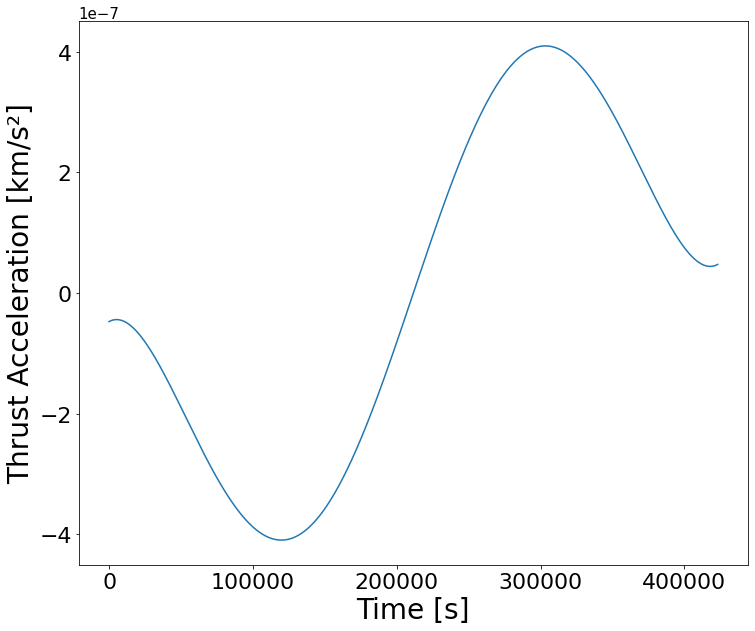

In [37]:
# Thrust profile
plt.figure(figsize=(12, 10))  # Set the figure size

# Plot the data
plt.plot(time_table[:, 1], ThrustBIG_tablearr[0][:, 1], label='Thrust Acceleration')

# Set axis labels
plt.xlabel('Time [s]', fontsize=28)  # X-axis label
plt.ylabel('Thrust Acceleration [km/s²]', fontsize=28)  # Y-axis label8

# Customize tick parameters
plt.tick_params(axis='both', labelsize=22)
plt.savefig("thrustprof.png")

In [38]:
#thrust estimations of 4 state model for all noise levels
Thrustreproduced4statesnoisylow=[]
Thrustreproduced4statesnoisymid=[]
Thrustreproduced4statesnoisyhigh=[]
    
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrust4state(thetaBIG_tablenoisylow[0][j,i],rBIG_tablenoisylow[0][j,i],
                                 thetadotBIG_tablenoisylow[0][j,i],rdotBIG_tablenoisylow[0][j,i],XIBIG_tablelownoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproduced4statesnoisylow.append(thrustiarr)
    
    
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrust4state(thetaBIG_tablenoisymid[0][j,i],rBIG_tablenoisymid[0][j,i],
                                 thetadotBIG_tablenoisymid[0][j,i],rdotBIG_tablenoisymid[0][j,i],XIBIG_tablemidnoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproduced4statesnoisymid.append(thrustiarr)
    
    
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrust4state(thetaBIG_tablenoisyhigh[0][j,i],rBIG_tablenoisyhigh[0][j,i],
                                 thetadotBIG_tablenoisyhigh[0][j,i],rdotBIG_tablenoisyhigh[0][j,i],XIBIG_tablehighnoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproduced4statesnoisyhigh.append(thrustiarr)

#thrust estimations of theta model for all noise levels
Thrustreproducedthetanoisylow=[]
Thrustreproducedthetanoisymid=[]
Thrustreproducedthetanoisyhigh=[]
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrusttheta(thetaBIG_tablenoisylow[0][j,i],XIBIG_tablethetalownoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproducedthetanoisylow.append(thrustiarr)
    

for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrusttheta(thetaBIG_tablenoisymid[0][j,i],XIBIG_tablethetamidnoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproducedthetanoisymid.append(thrustiarr)
    
    
for k in range(len(rBIG_tablearr)):
    thrustiarr=np.zeros(rBIG_tablearr[0].shape)
    for i in range(len(thetaval)):
        for j in range(len(rBIG_tablearr[0][:,i])):
            thrusti=Thrusttheta(thetaBIG_tablenoisyhigh[0][j,i],XIBIG_tablethetahighnoise[k][:,i])
            thrustiarr[j,i]=thrusti
    Thrustreproducedthetanoisyhigh.append(thrustiarr)

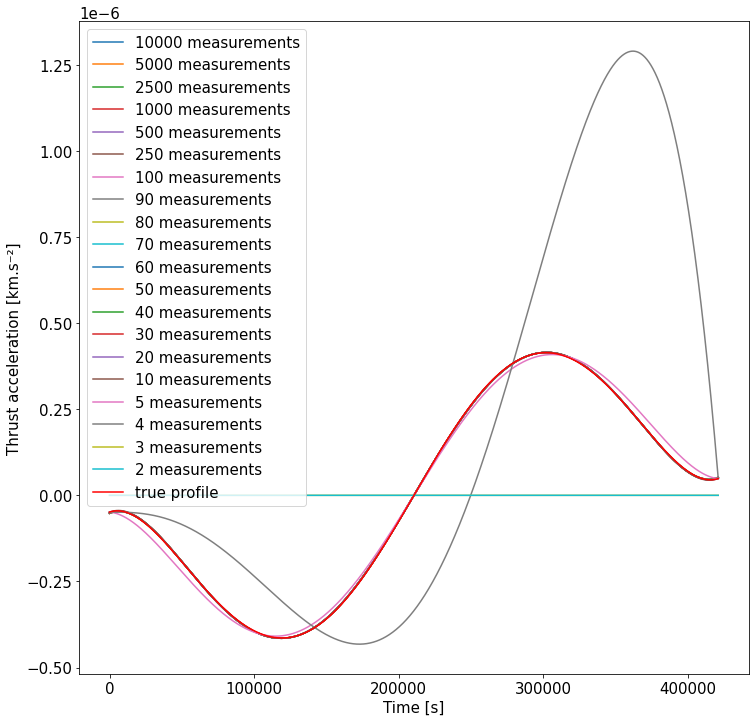

In [41]:
#thrust profile for theta model for each measurement number
for k in range(len(thetaBIG_tablearr)):
    plt.plot(time_table[:,0],Thrustreproducedtheta[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("thrustthetapoly.pdf")
plt.show()



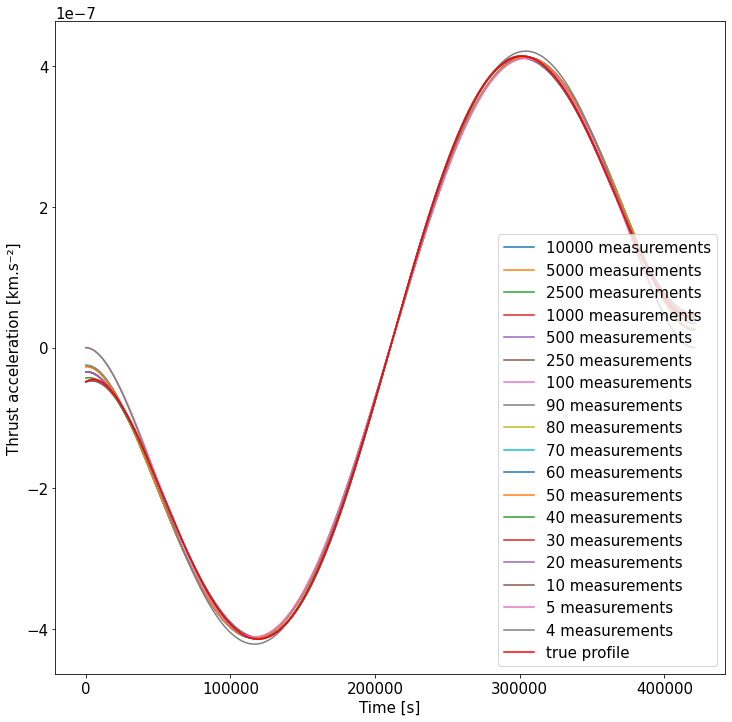

In [42]:
#thrust profile for 4 state model for each measurement number
for k in range(len(thetaBIG_tablearr)-2):
    plt.plot(time_table[:,0],Thrustreproduced4states[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("thrust4statepolynomial.pdf")
plt.show()

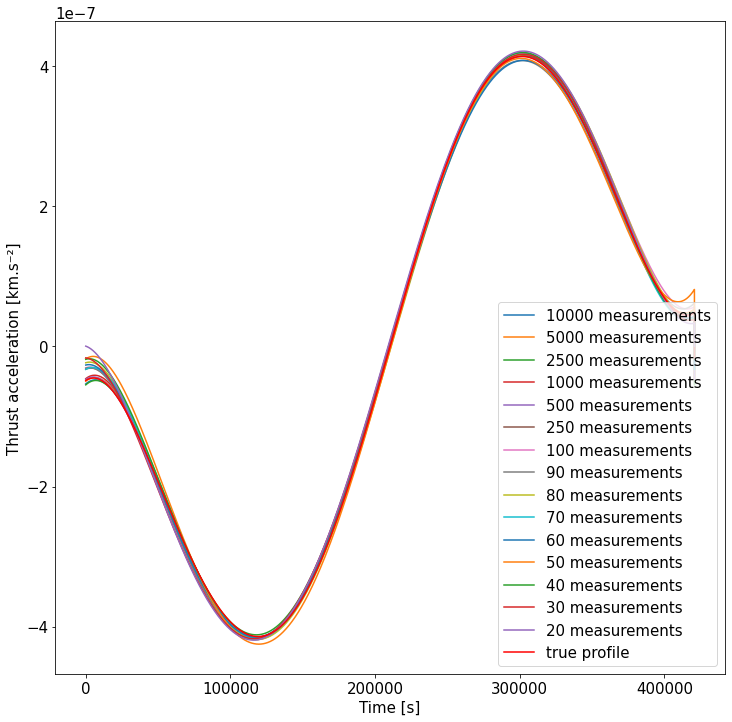

In [43]:
#thrust profile theta model with low noise for each measurement
for k in range(len(thetaBIG_tablearr)-5):
    plt.plot(time_table[:,0],Thrustreproducedthetanoisylow[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("lownoisythetathrust.pdf")
plt.show()

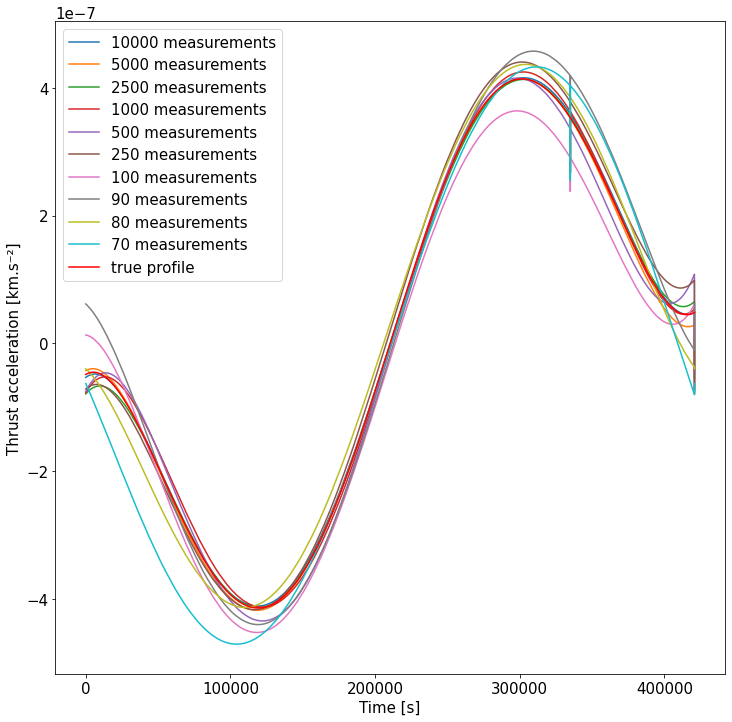

In [45]:
#thrust profile theta model with mid noise for each measurement
for k in range(len(thetaBIG_tablearr)-10):
    plt.plot(time_table[:,0],Thrustreproducedthetanoisymid[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("midnoisythetathrust.pdf")
plt.show()

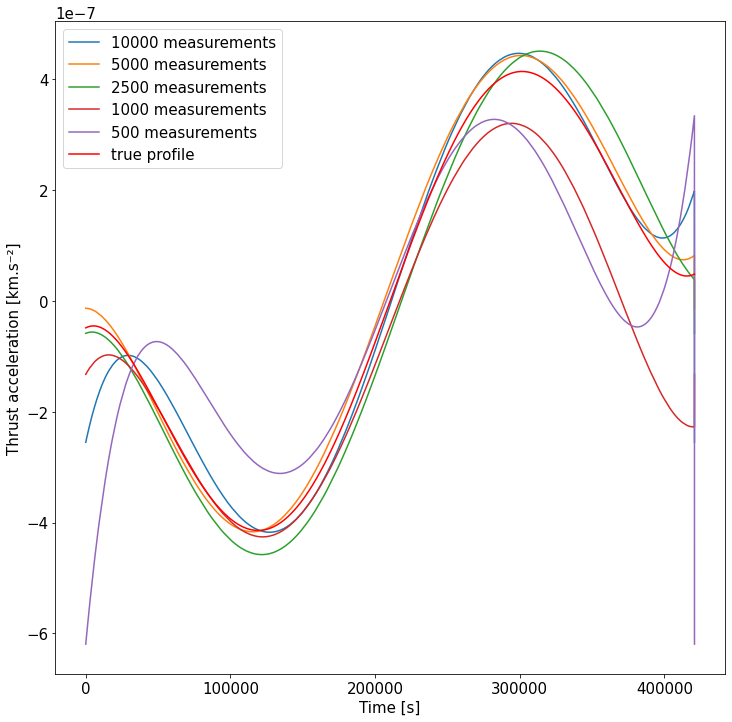

In [46]:
#thrust profile theta model with high noise for each measurement
for k in range(len(thetaBIG_tablearr)-15):
    plt.plot(time_table[:,0],Thrustreproducedthetanoisyhigh[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("highnoisythetathrust.pdf")
plt.show()

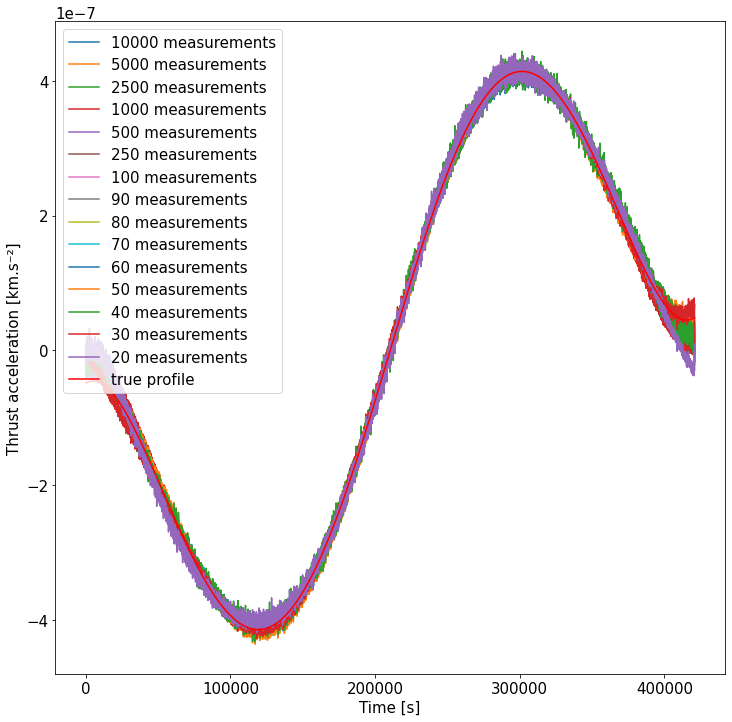

In [47]:
#thrust profile 4-state model with low noise for each measurement
for k in range(len(thetaBIG_tablearr)-5):
    plt.plot(time_table[:,0],Thrustreproduced4statesnoisylow[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("lownoisy4statethrust.pdf")
plt.show()

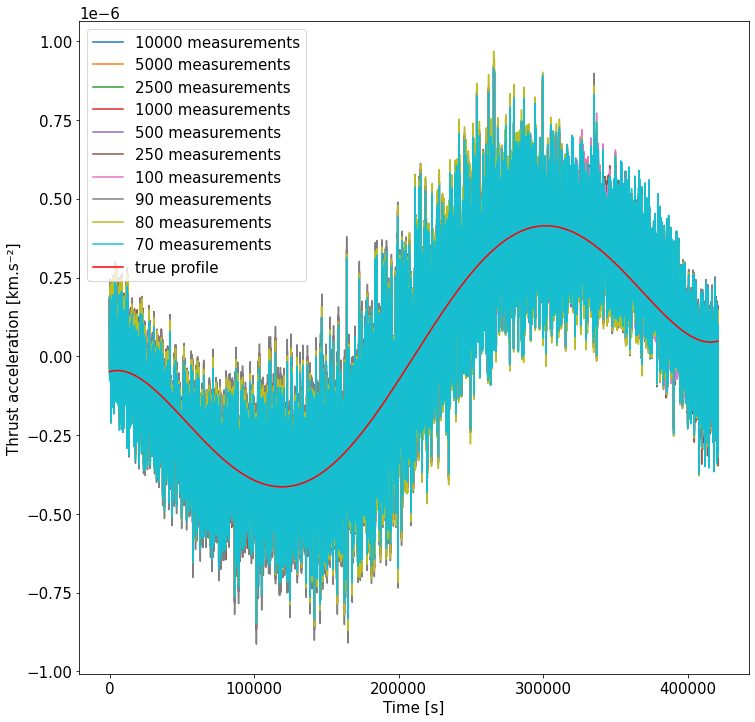

In [48]:
#thrust profile 4-state model with mid noise for each measurement
for k in range(len(thetaBIG_tablearr)-10):
    plt.plot(time_table[:,0],Thrustreproduced4statesnoisymid[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("midnoisy4statethrust.pdf")
plt.show()

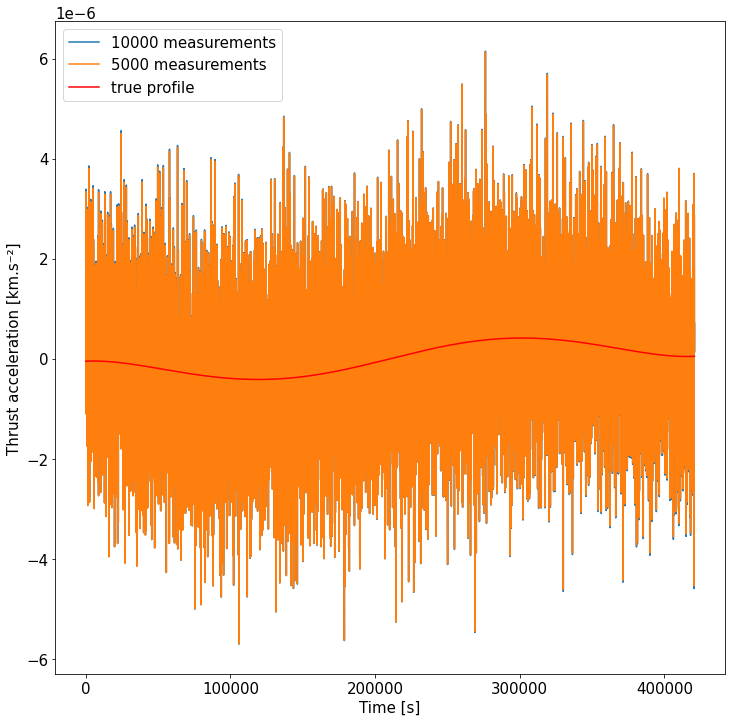

In [49]:
#thrust profile 4-state model with high noise for each measurement
for k in range(len(thetaBIG_tablearr)-18):
    plt.plot(time_table[:,0],Thrustreproduced4statesnoisyhigh[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.savefig("highnoisy4statethrust.pdf")
plt.show()

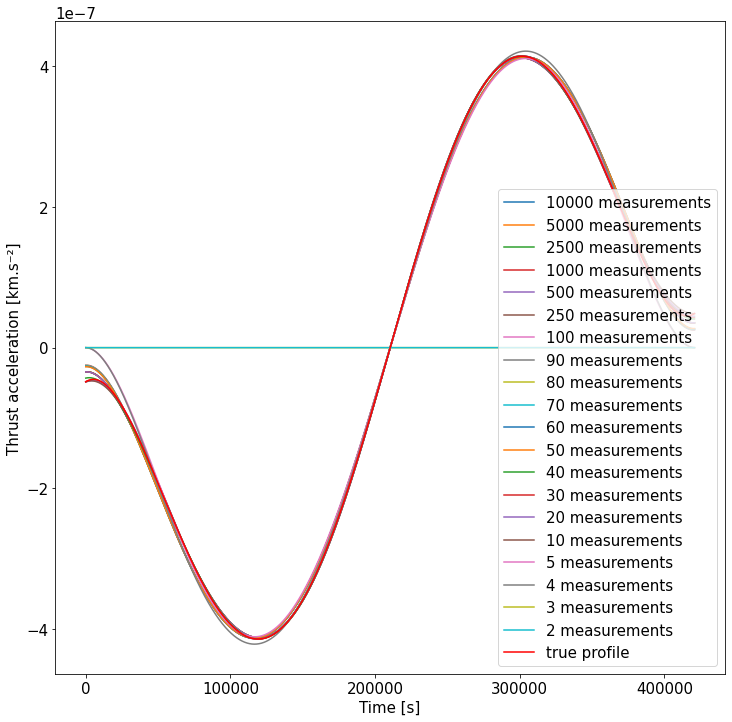

In [50]:
for k in range(len(thetaBIG_tablearr)):
    plt.plot(time_table[:,0],Thrustreproduced4states[k][:,0],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
plt.xlabel('Time [s]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
    
plt.plot(time_table[:,0],Thrust_table[:,0],label="true profile",color="red")
plt.legend()
plt.show()

In [51]:
####LOW NOISE
#RMSErposition calculation for 4 state model, only low environment give sensible data
RMSErpositionnoisylow=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredlownoise[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErpositionnoisylow.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetapositionnoisylow=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredlownoise[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetapositionnoisylow.append(RMSE_table)
    
# ##################MID NOISEEEEE  
# #RMSErposition
# RMSErpositionnoisymid=[]
# for k in range(len(rBIG_tablearr)):
#     RMSE_table=np.zeros([len(thetaval),1])
#     for i in range(len(thetaval)):
#         RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredmidnoise[k][:,0,i]))
#         RMSE_table[i,0]=RMSE_val
#     RMSErpositionnoisymid.append(RMSE_table)
    
# #RMSEthetaposition   
# RMSEthetapositionnoisymid=[]
# for k in range(len(rBIG_tablearr)):
#     RMSE_table=np.zeros([len(thetaval),1])
#     for i in range(len(thetaval)):
#         RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredmidnoise[k][:,1,i]))
#         RMSE_table[i,0]=RMSE_val
#     RMSEthetapositionnoisymid.append(RMSE_table)
    
# ############################HIGH NOISEEEEEEE
# RMSErposition
# RMSErpositionnoisyhigh=[]
# for k in range(len(rBIG_tablearr)):
#     RMSE_table=np.zeros([len(thetaval),1])
#     for i in range(len(thetaval)):
#         RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredhighnoise[k][:,0,i]))
#         RMSE_table[i,0]=RMSE_val
#     RMSErpositionnoisyhigh.append(RMSE_table)
    
# RMSEthetaposition   
# RMSEthetapositionnoisyhigh=[]
# for k in range(len(rBIG_tablearr)):
#     RMSE_table=np.zeros([len(thetaval),1])
#     for i in range(len(thetaval)):
#         RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredhighnoise[k][:,1,i]))
#         RMSE_table[i,0]=RMSE_val
#     RMSEthetapositionnoisyhigh.append(RMSE_table)

In [52]:
####LOW NOISE
#RMSErposition for theta model
RMSErpositionnoisylowtheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredthetalownoise[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErpositionnoisylowtheta.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetapositionnoisylowtheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredthetalownoise[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetapositionnoisylowtheta.append(RMSE_table)
    
    
    
##################MID NOISEEEEE  
#RMSErposition
RMSErpositionnoisymidtheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredthetamidnoise[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErpositionnoisymidtheta.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetapositionnoisymidtheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredthetamidnoise[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetapositionnoisymidtheta.append(RMSE_table)
    
    
    
#############################HIGH NOISEEEEEEE
#RMSErposition
RMSErpositionnoisyhightheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(rBIG_tablearr[0][:,i], pospredthetahighnoise[k][:,0,i]))
        RMSE_table[i,0]=RMSE_val
    RMSErpositionnoisyhightheta.append(RMSE_table)
    
#RMSEthetaposition   
RMSEthetapositionnoisyhightheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(thetaBIG_tablearr[0][:,i], pospredthetahighnoise[k][:,1,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEthetapositionnoisyhightheta.append(RMSE_table)

In [3]:
#RMSE Thrust calculation for zero noise 4 state model
RMSEThrust4state=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproduced4states[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrust4state.append(RMSE_table)

    
#RMSE Thrust calculation for zero noise theta model
RMSEThrusttheta=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproducedtheta[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrusttheta.append(RMSE_table)

NameError: name 'rBIG_tablearr' is not defined

In [54]:
#RMSE Thrust calculation for low mid and high noise 4 state model
RMSEThrust4statenoisylow=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproduced4statesnoisylow[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrust4statenoisylow.append(RMSE_table)
    
RMSEThrust4statenoisymid=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproduced4statesnoisymid[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrust4statenoisymid.append(RMSE_table)
    
RMSEThrust4statenoisyhigh=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproduced4statesnoisyhigh[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrust4statenoisyhigh.append(RMSE_table)
    
#RMSE Thrust calculation for low mid and high noise theta model 
RMSEThrustthetanoisylow=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproducedthetanoisylow[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrustthetanoisylow.append(RMSE_table)
    
RMSEThrustthetanoisymid=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproducedthetanoisymid[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrustthetanoisymid.append(RMSE_table)
    
    
RMSEThrustthetanoisyhigh=[]
for k in range(len(rBIG_tablearr)):
    RMSE_table=np.zeros([len(thetaval),1])
    for i in range(len(thetaval)):
        RMSE_val = sqrt(mean_squared_error(Thrust_table[:,i], Thrustreproducedthetanoisyhigh[k][:,i]))
        RMSE_table[i,0]=RMSE_val
    RMSEThrustthetanoisyhigh.append(RMSE_table)

# Initial plots see below for more specific and accurate plots

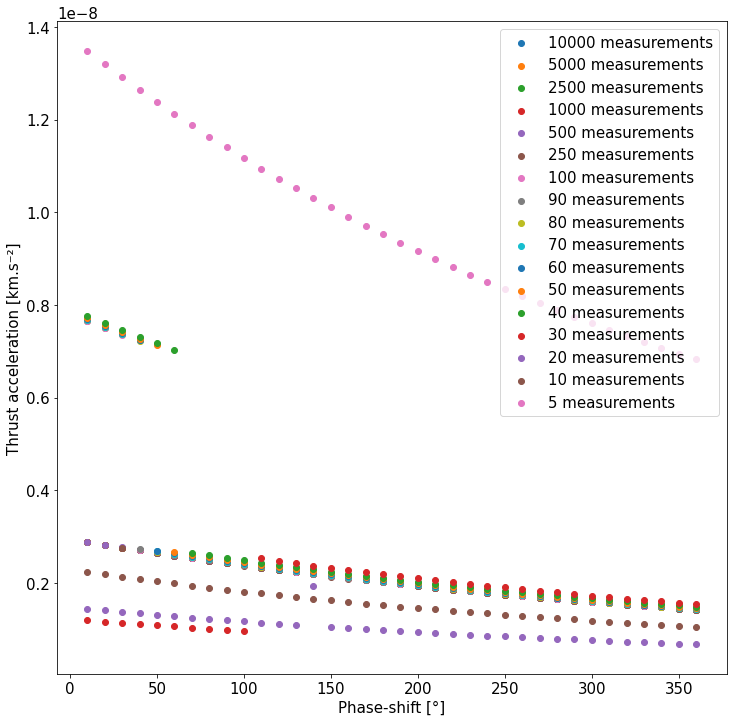

In [55]:
theta_deg=np.linspace(10,360,36)
for k in range(len(thetaBIG_tablearr)-3):
    plt.scatter(theta_deg,RMSEThrust4state[k][1:],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
    
plt.xlabel('Phase-shift [°]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.legend()
plt.savefig("thrust4state.pdf")
plt.show()



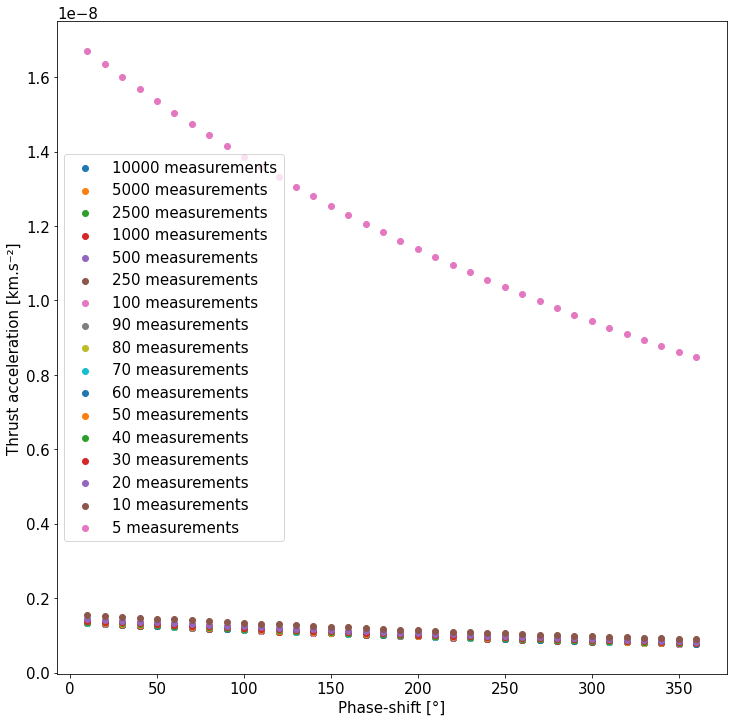

In [56]:
for k in range(len(thetaBIG_tablearr)-3):
    plt.scatter(theta_deg,RMSEThrusttheta[k][1:],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
plt.legend()
plt.xlabel('Phase-shift [°]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.savefig("thetathrust.pdf")
plt.show()

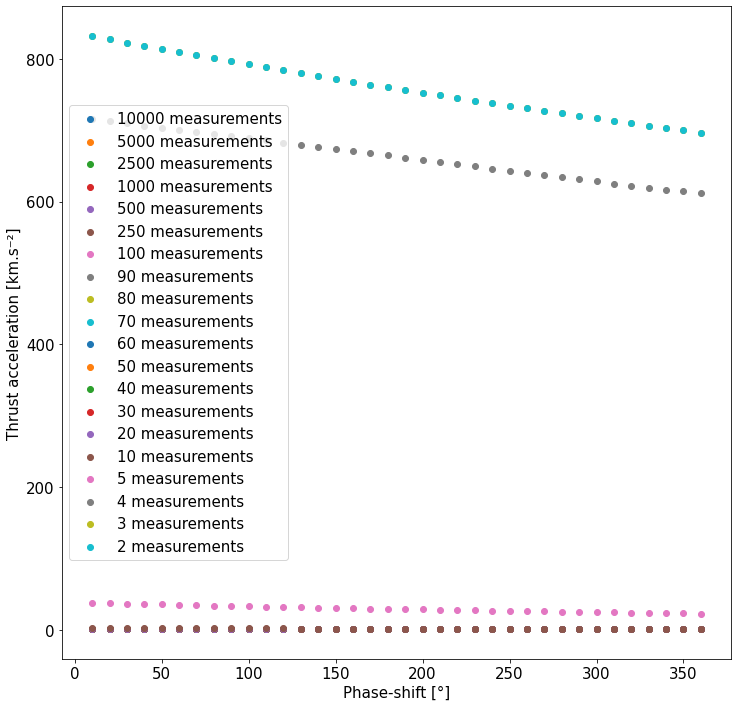

In [57]:
for k in range(len(thetaBIG_tablearr)):
    plt.scatter(theta_deg,RMSErpositiontheta[k][1:],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
plt.legend()
plt.xlabel('Phase-shift [°]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.show()

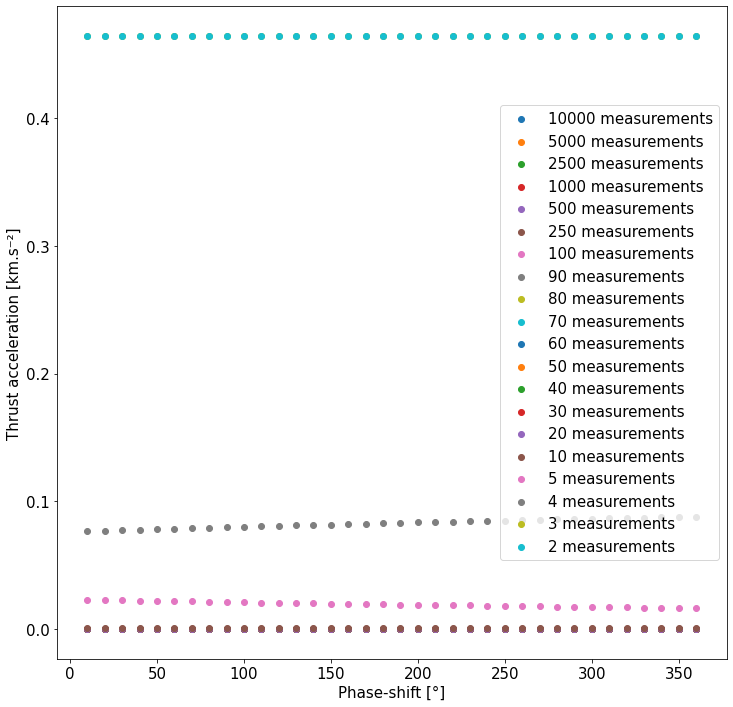

In [58]:
for k in range(len(thetaBIG_tablearr)):
    plt.scatter(theta_deg,RMSEthetapositiontheta[k][1:],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
plt.legend()
plt.xlabel('Phase-shift [°]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.show()

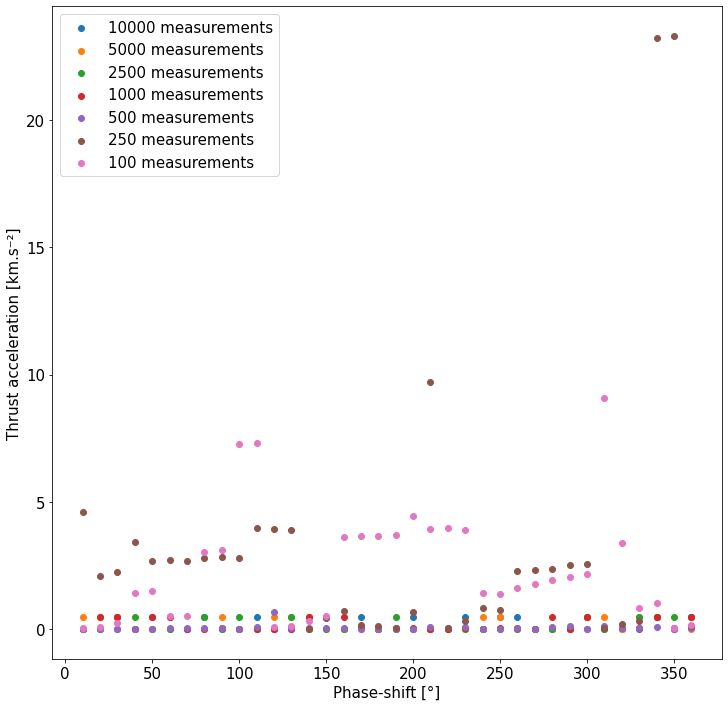

In [59]:
for k in range(7):#len(thetaBIG_tablearr)):
    plt.scatter(theta_deg,RMSEthetapositionnoisylow[k][1:],label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
plt.legend()
plt.xlabel('Phase-shift [°]')  # Replace with your desired title
plt.ylabel('Thrust acceleration [km.s⁻²]')  # Replace with your desired title
plt.show()

No handles with labels found to put in legend.


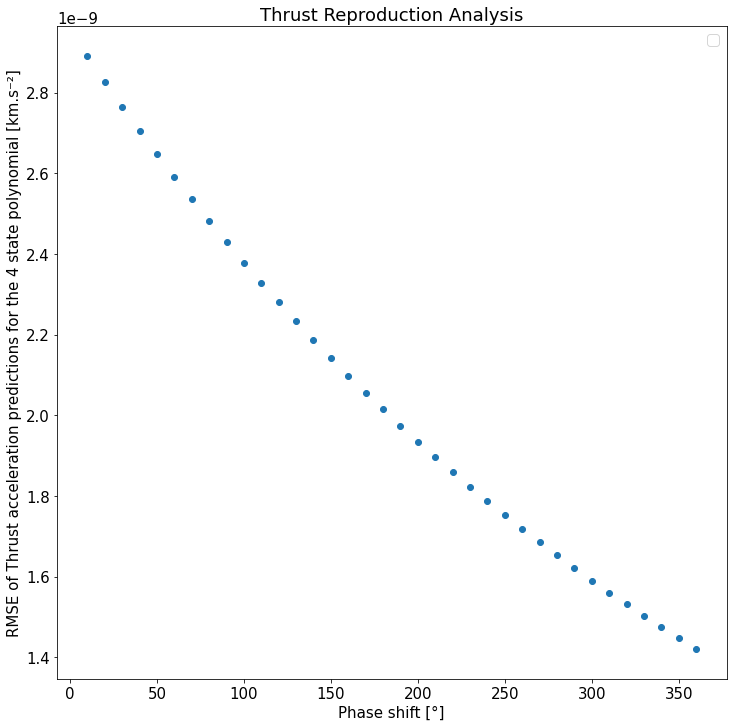

In [60]:
#thrust RMSE with phase angle for 4-state
plt.scatter(theta_deg,RMSEThrust4state[0][1:])
plt.xlabel("Phase shift [°]")  # Set x-axis label
plt.ylabel("RMSE of Thrust acceleration predictions for the 4 state polynomial [km.s⁻²]")  # Set y-axis label
plt.title("Thrust Reproduction Analysis")  # Optional: add a title to the plot
plt.legend()  # Add a legend to the plot

# Save the plot to a file
plt.savefig("thrustreprod4state.png", dpi=300)  # Save the plot with a specified DPI for better quality

# Display the plot
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


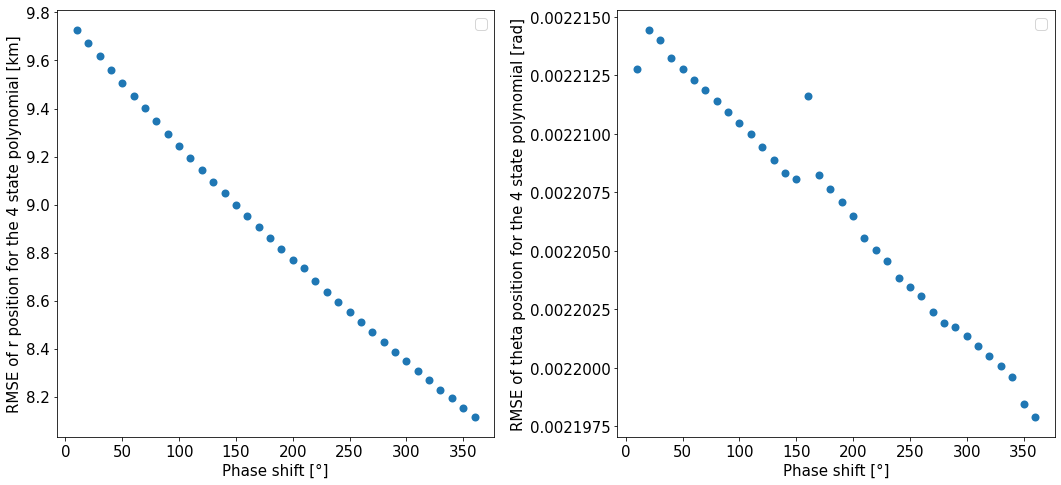

In [61]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 7))


ax1.scatter(theta_deg, RMSErposition[0][1:], linewidth=2)
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the 4 state polynomial [km]")
ax1.legend()


ax2.scatter(theta_deg[::-1], RMSEthetaposition[0][1:], linewidth=2)
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the 4 state polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpred4statebasic.png", dpi=300)

# Display the plot
plt.show()

No handles with labels found to put in legend.


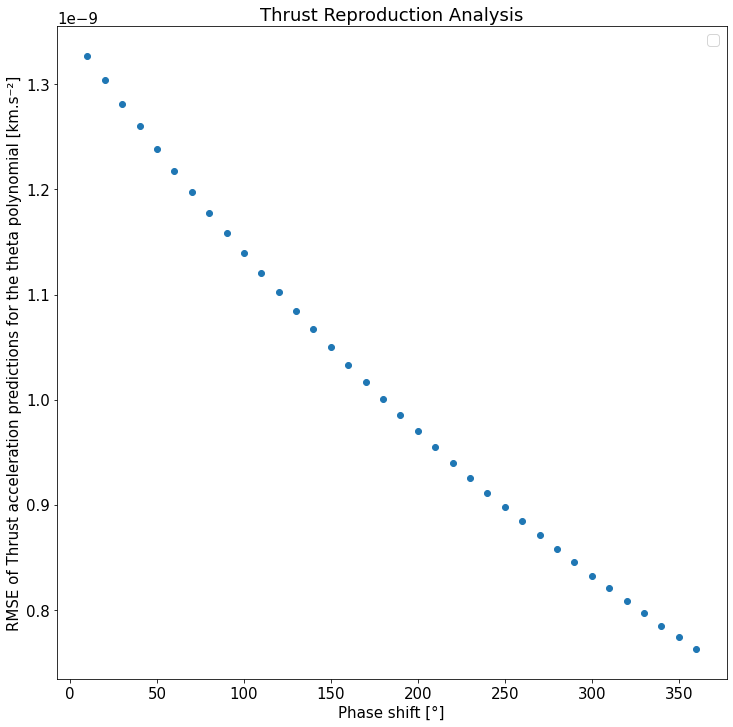

In [62]:
plt.scatter(theta_deg,RMSEThrusttheta[0][1:])
plt.xlabel("Phase shift [°]")  # Set x-axis label
plt.ylabel("RMSE of Thrust acceleration predictions for the theta polynomial [km.s⁻²]")  # Set y-axis label
plt.title("Thrust Reproduction Analysis")  # Optional: add a title to the plot
plt.legend()  # Add a legend to the plot

# Save the plot to a file
plt.savefig("thrustreprodtheta.png", dpi=300)  # Save the plot with a specified DPI for better quality

# Display the plot
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


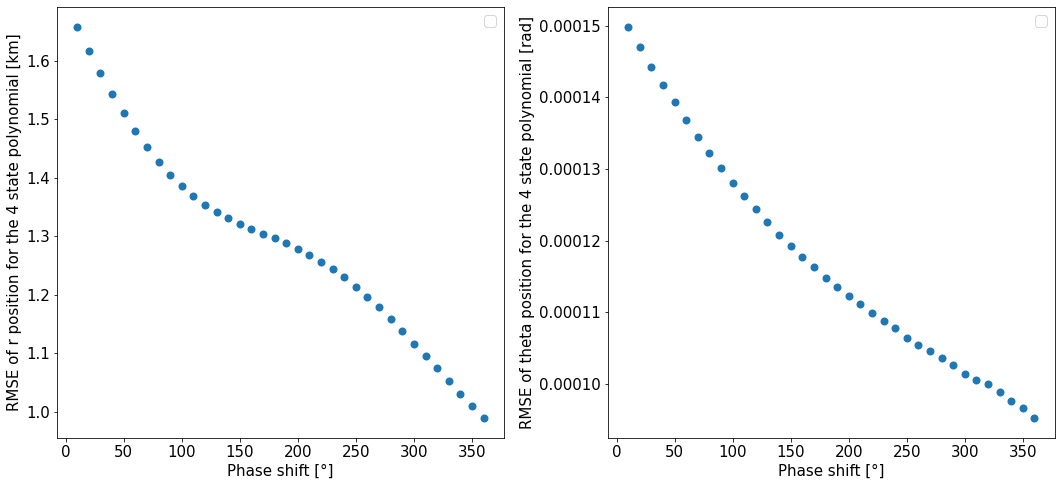

In [63]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 7))


ax1.scatter(theta_deg, RMSErpositiontheta[0][1:], linewidth=2)
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the 4 state polynomial [km]")
ax1.legend()


ax2.scatter(theta_deg, RMSEthetapositiontheta[0][1:], linewidth=2)
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the 4 state polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpred4statebasictheta.png", dpi=300)

# Display the plot
plt.show()

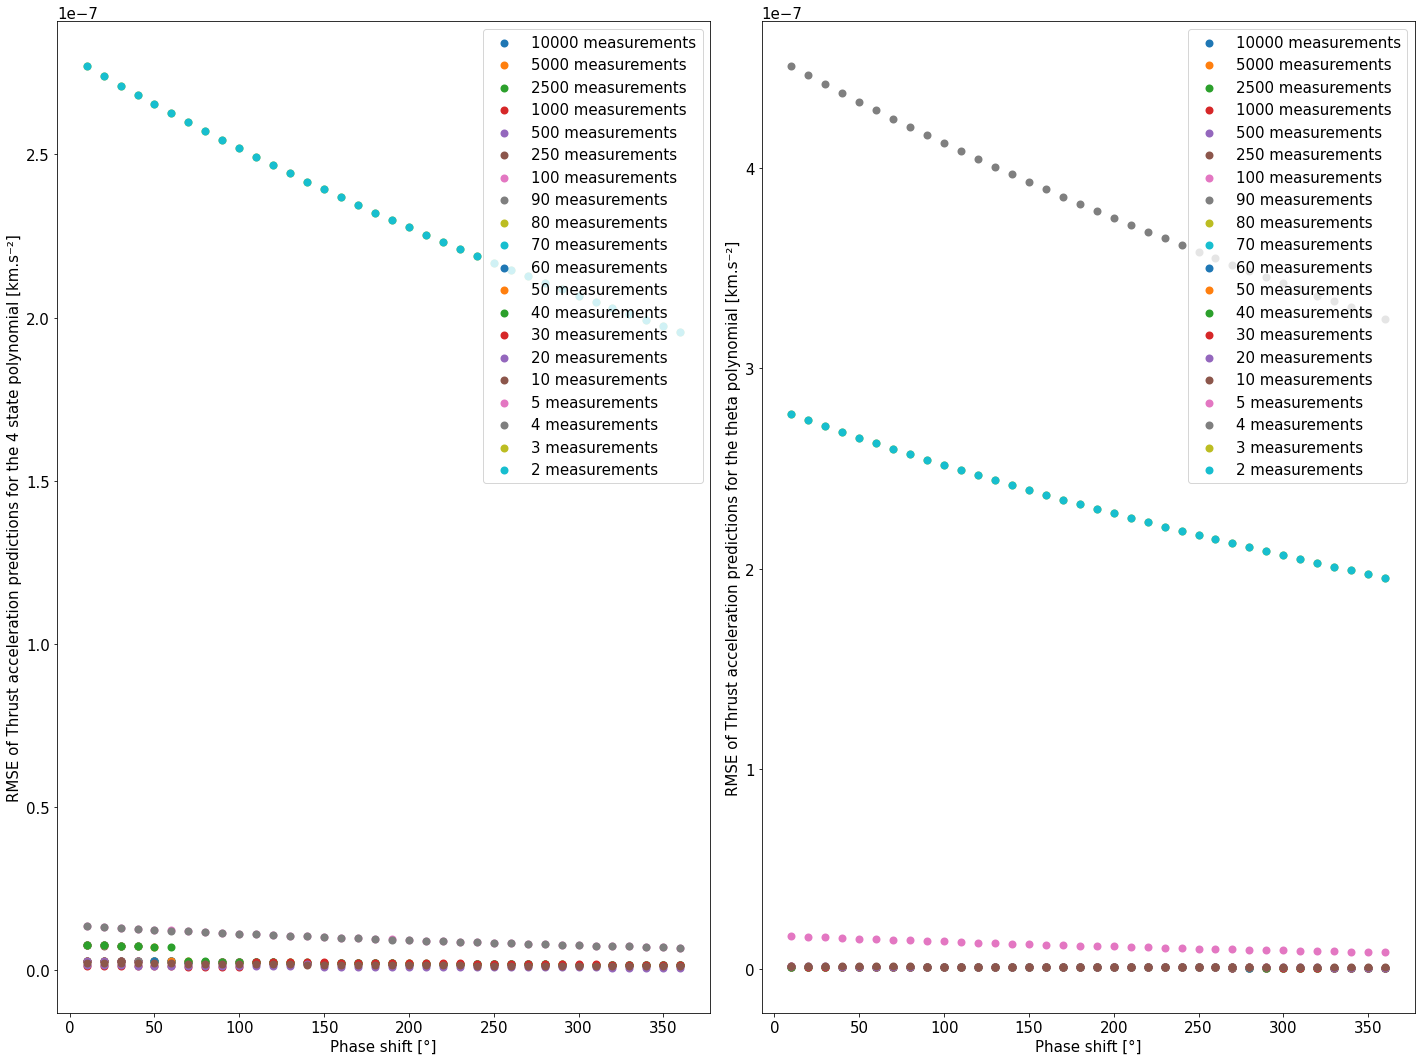

In [64]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 15))

for k in range(len(thetaBIG_tablearr)):
    ax1.scatter(theta_deg, RMSEThrust4state[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of Thrust acceleration predictions for the 4 state polynomial [km.s⁻²]")
ax1.legend(loc='upper right')

for k in range(len(thetaBIG_tablearr)):
    ax2.scatter(theta_deg, RMSEThrusttheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of Thrust acceleration predictions for the theta polynomial [km.s⁻²]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("comparisonofperformancewithmeasuremnts.png", dpi=300)

# Display the plot
plt.show()



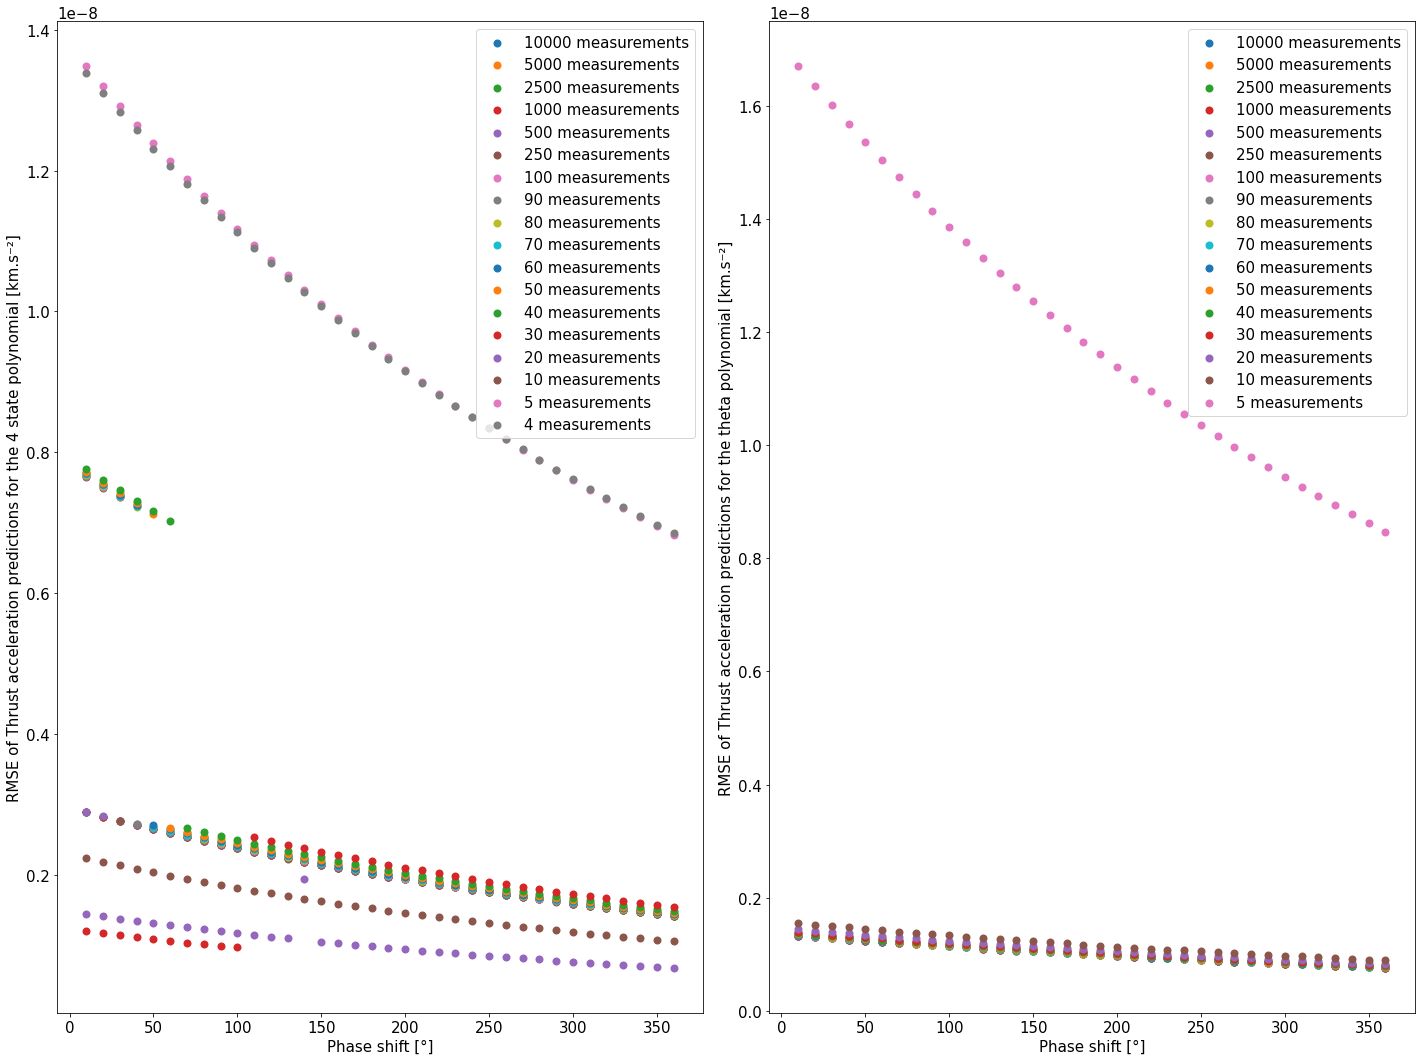

In [65]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 15))

for k in range(len(thetaBIG_tablearr)-2):
    ax1.scatter(theta_deg, RMSEThrust4state[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of Thrust acceleration predictions for the 4 state polynomial [km.s⁻²]")
ax1.legend()

for k in range(len(thetaBIG_tablearr)-3):
    ax2.scatter(theta_deg, RMSEThrusttheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of Thrust acceleration predictions for the theta polynomial [km.s⁻²]")
ax2.legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("focusedcomparisonofperformancewithmeasuremnts.png", dpi=300)

# Display the plot
plt.show()

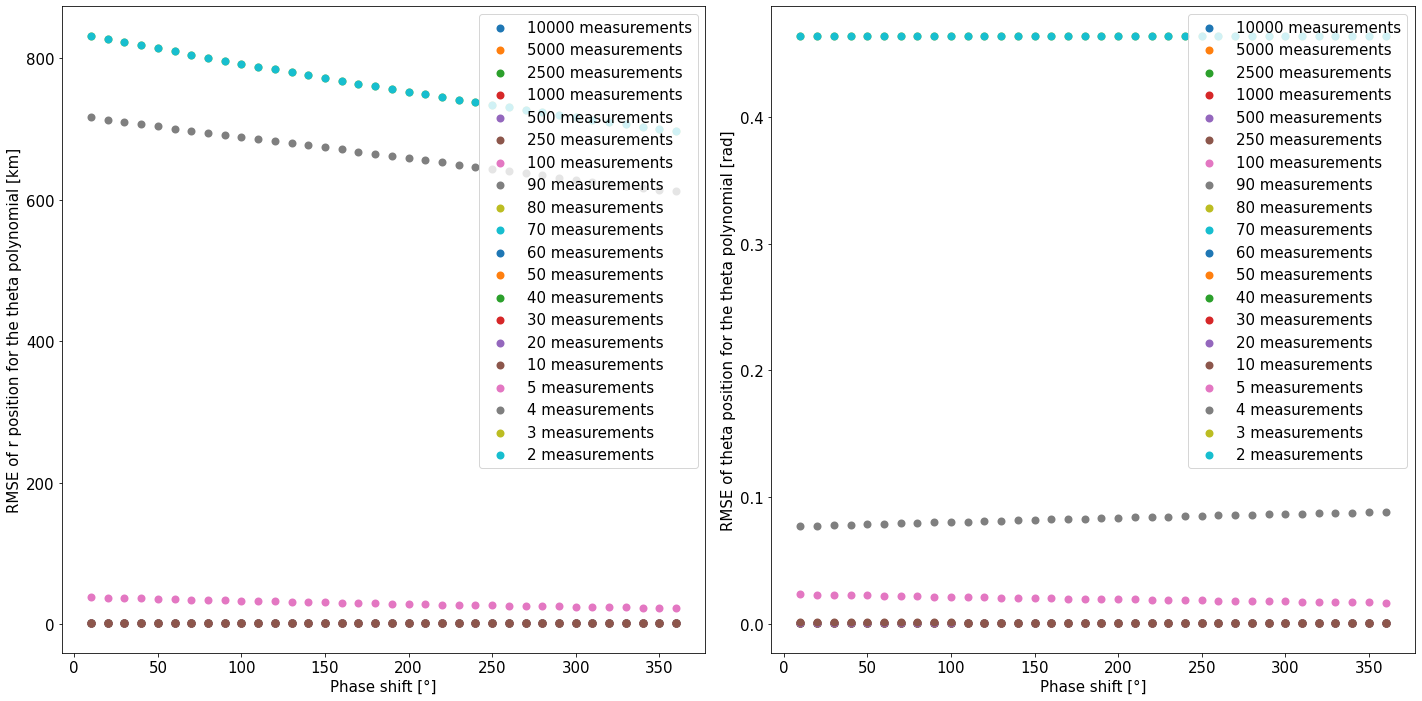

In [66]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))

for k in range(len(thetaBIG_tablearr)):
    ax1.scatter(theta_deg, RMSErpositiontheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the theta polynomial [km]")
ax1.legend(loc='upper right')

for k in range(len(thetaBIG_tablearr)):
    ax2.scatter(theta_deg, RMSEthetapositiontheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the theta polynomial [rad]")
ax2.legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacomptheta.png", dpi=300)

# Display the plot
plt.show()

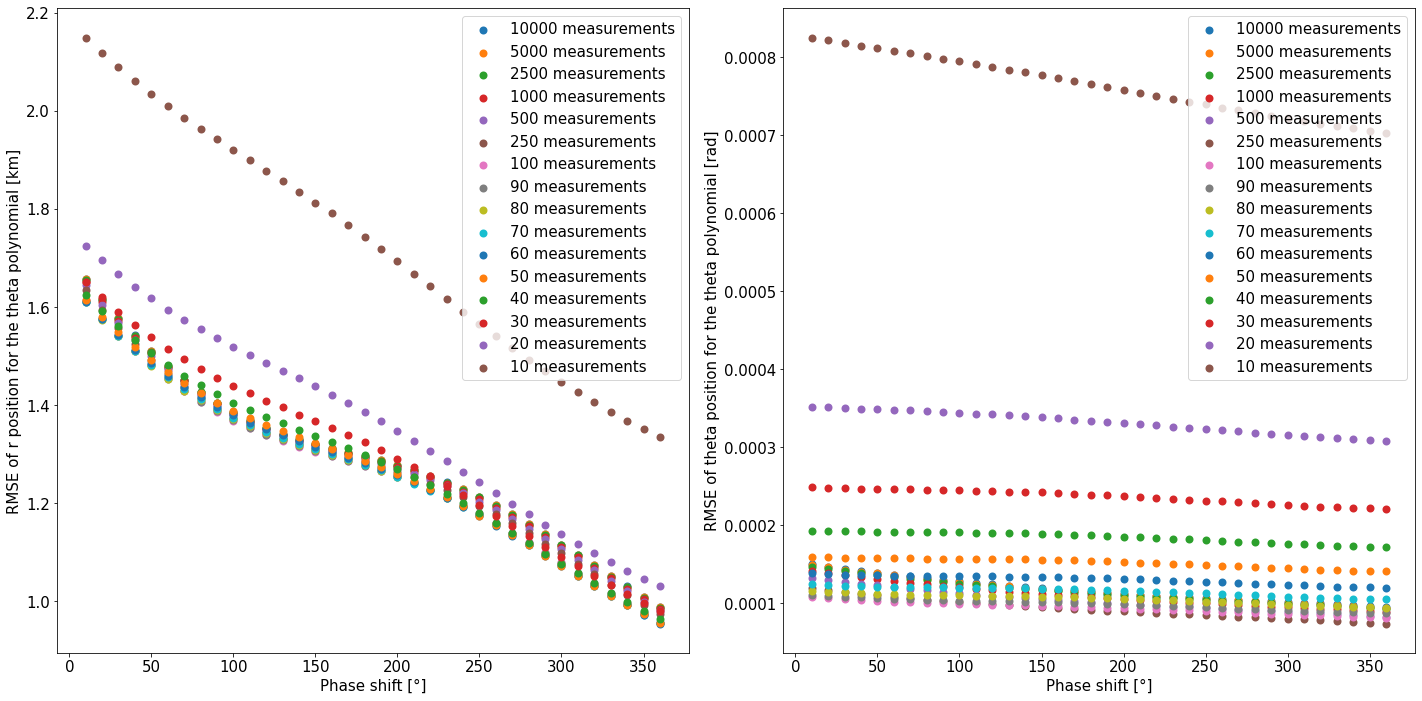

In [67]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))

for k in range(len(thetaBIG_tablearr)-4):
    ax1.scatter(theta_deg, RMSErpositiontheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the theta polynomial [km]")
ax1.legend(loc='upper right')

for k in range(len(thetaBIG_tablearr)-4):
    ax2.scatter(theta_deg, RMSEthetapositiontheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the theta polynomial [rad]")
ax2.legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("focusedpositionpred4thetacomptheta.png", dpi=300)

# Display the plot
plt.show()

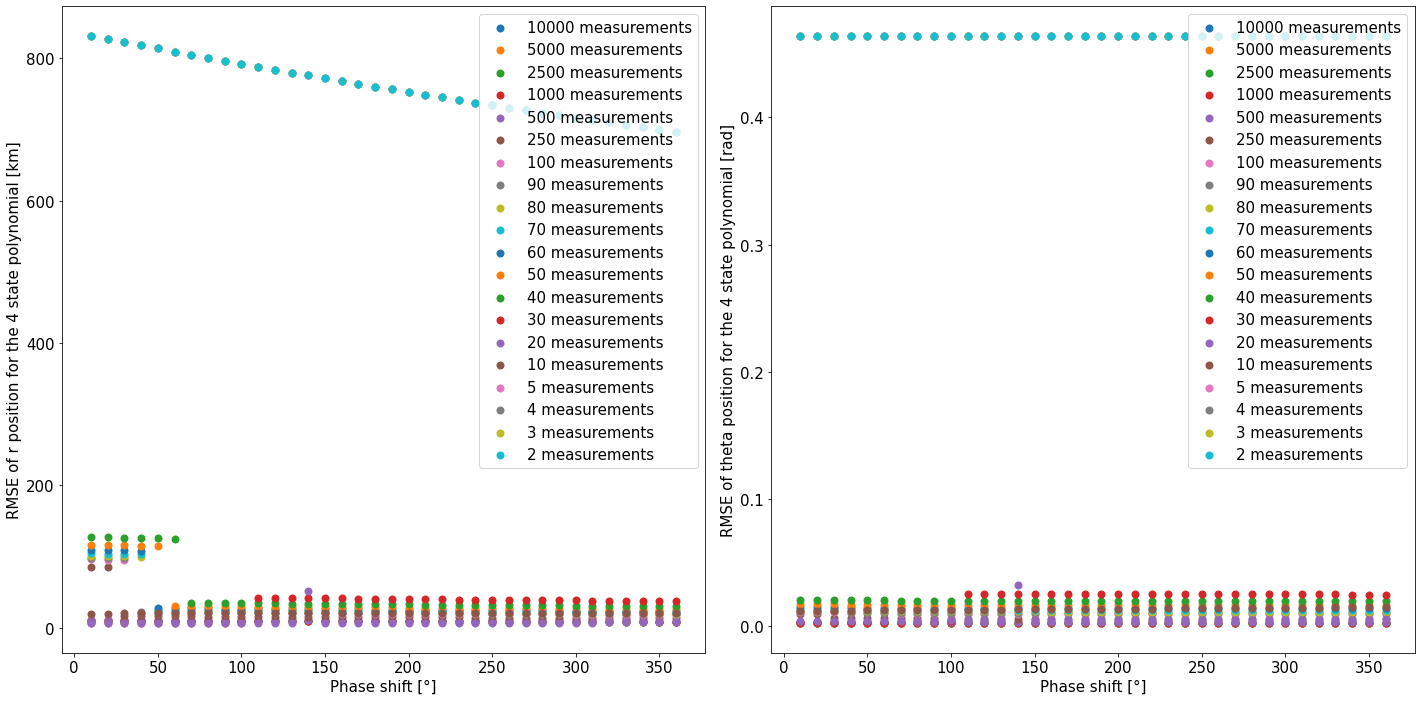

In [68]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))

for k in range(len(thetaBIG_tablearr)):
    ax1.scatter(theta_deg, RMSErposition[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the 4 state polynomial [km]")
ax1.legend(loc='upper right')

for k in range(len(thetaBIG_tablearr)):
    ax2.scatter(theta_deg, RMSEthetaposition[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the 4 state polynomial [rad]")
ax2.legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpred4statecomp.png", dpi=300)

# Display the plot
plt.show()

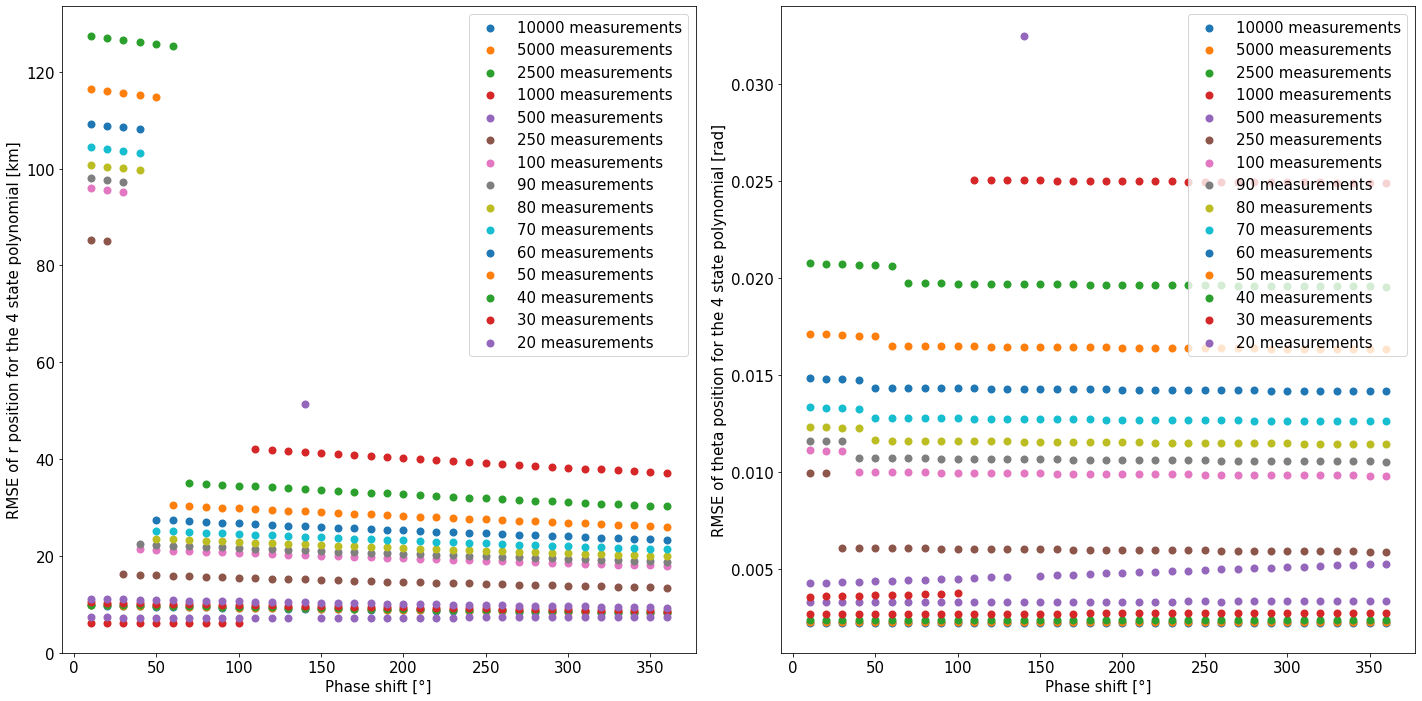

In [69]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))

for k in range(len(thetaBIG_tablearr)-5):
    ax1.scatter(theta_deg, RMSErposition[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the 4 state polynomial [km]")
ax1.legend(loc='upper right')

for k in range(len(thetaBIG_tablearr)-5):
    ax2.scatter(theta_deg, RMSEthetaposition[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the 4 state polynomial [rad]")
ax2.legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("focusedpositionpred4statecomp.png", dpi=300)

# Display the plot
plt.show()

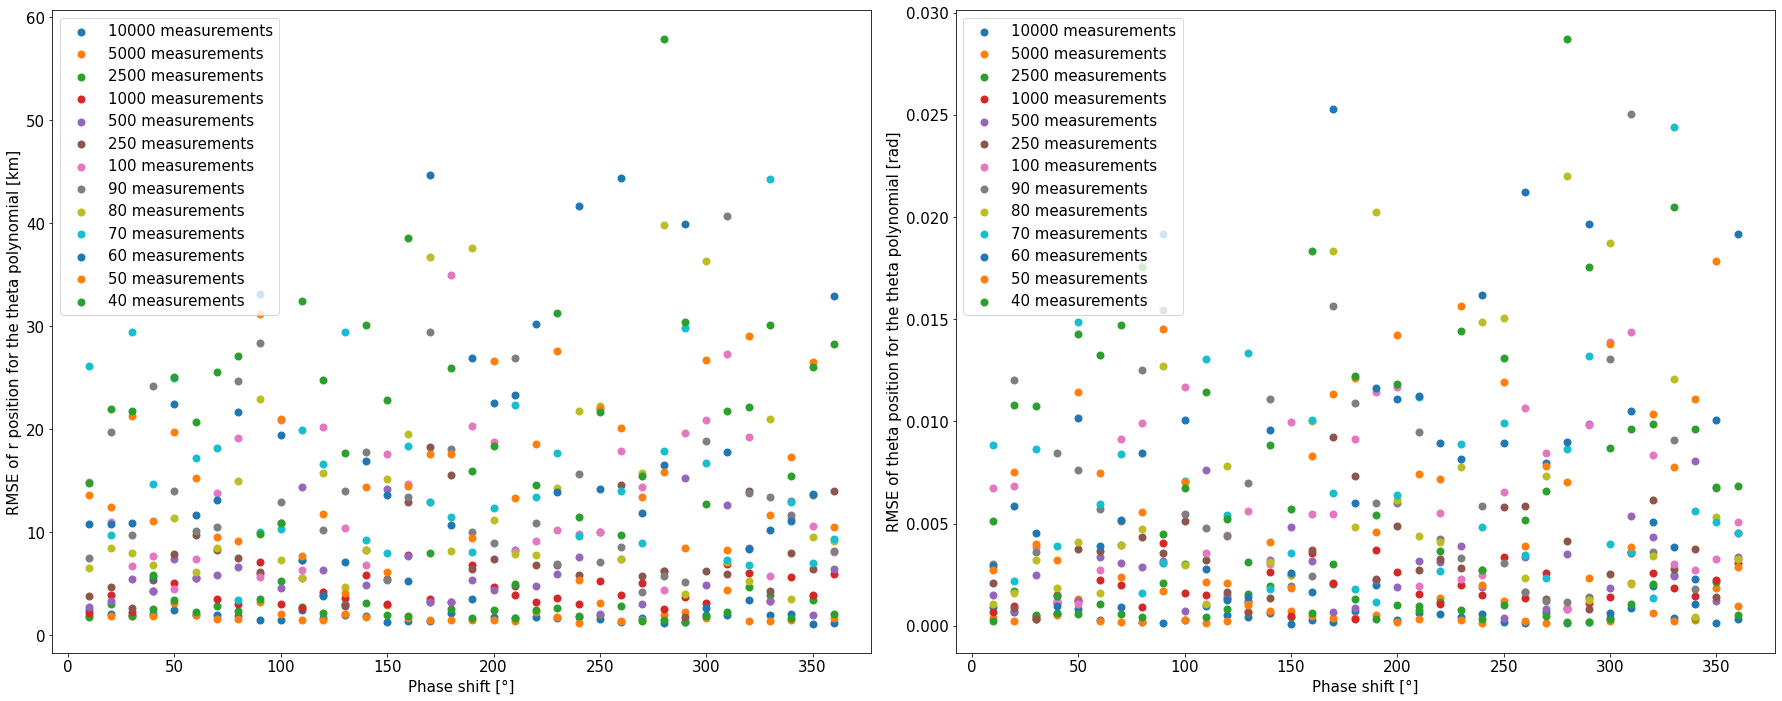

In [70]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(25, 10))

for k in range(len(thetaBIG_tablearr)-7):
    ax1.scatter(theta_deg, RMSErpositionnoisylowtheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the theta polynomial [km]")
ax1.legend(loc='upper left')

for k in range(len(thetaBIG_tablearr)-7):
    ax2.scatter(theta_deg, RMSEthetapositionnoisylowtheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the theta polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacompthetalownoise.png", dpi=300)

# Display the plot
plt.show()

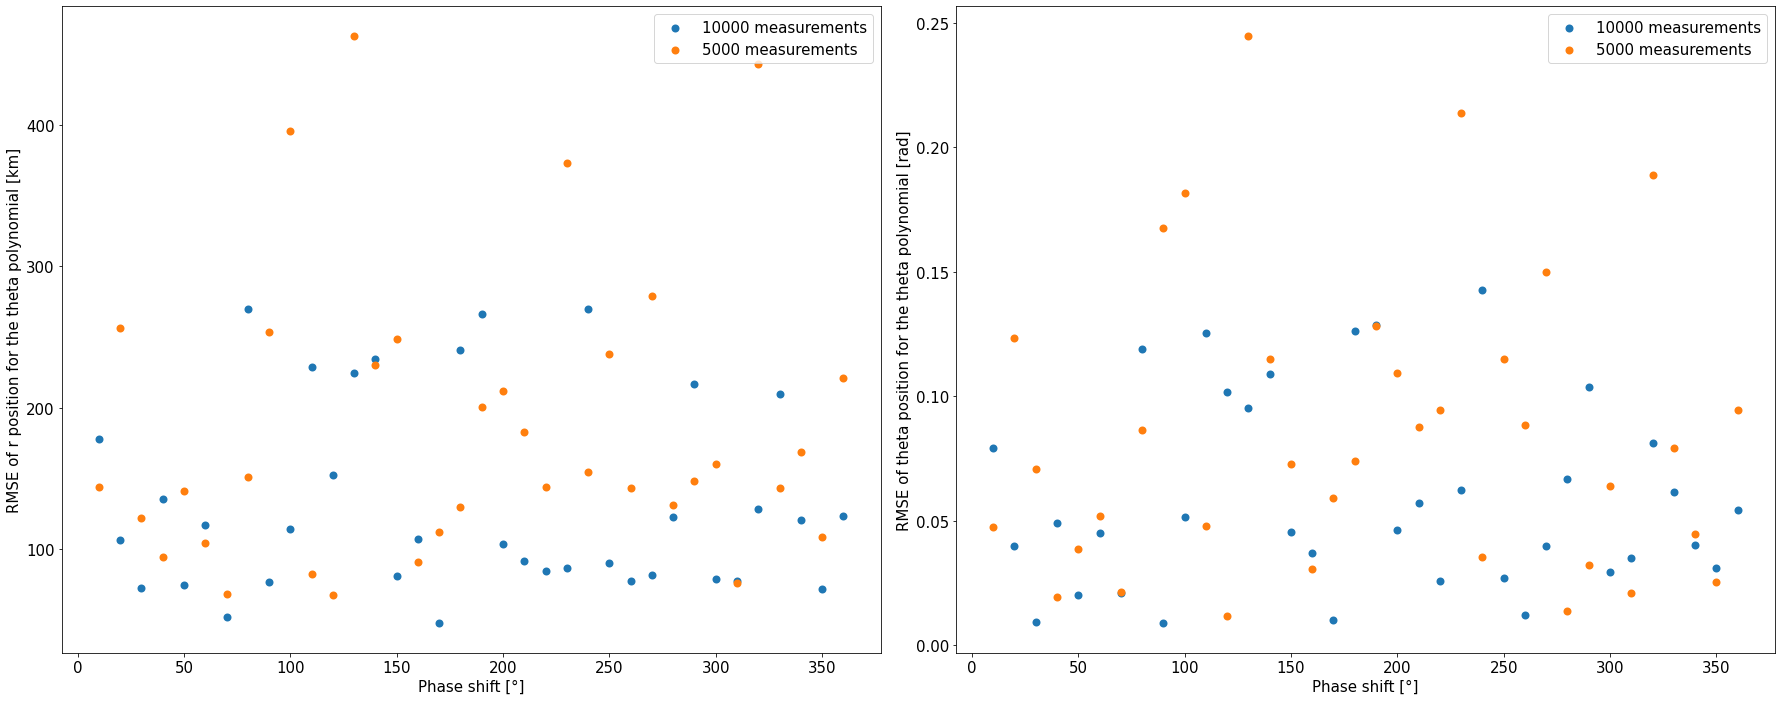

In [71]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(25, 10))

for k in range(len(thetaBIG_tablearr)-18):
    ax1.scatter(theta_deg, RMSErpositionnoisyhightheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the theta polynomial [km]")
ax1.legend()

for k in range(len(thetaBIG_tablearr)-18):
    ax2.scatter(theta_deg, RMSEthetapositionnoisyhightheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the theta polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacompthetahighnoise.png", dpi=300)

# Display the plot
plt.show()

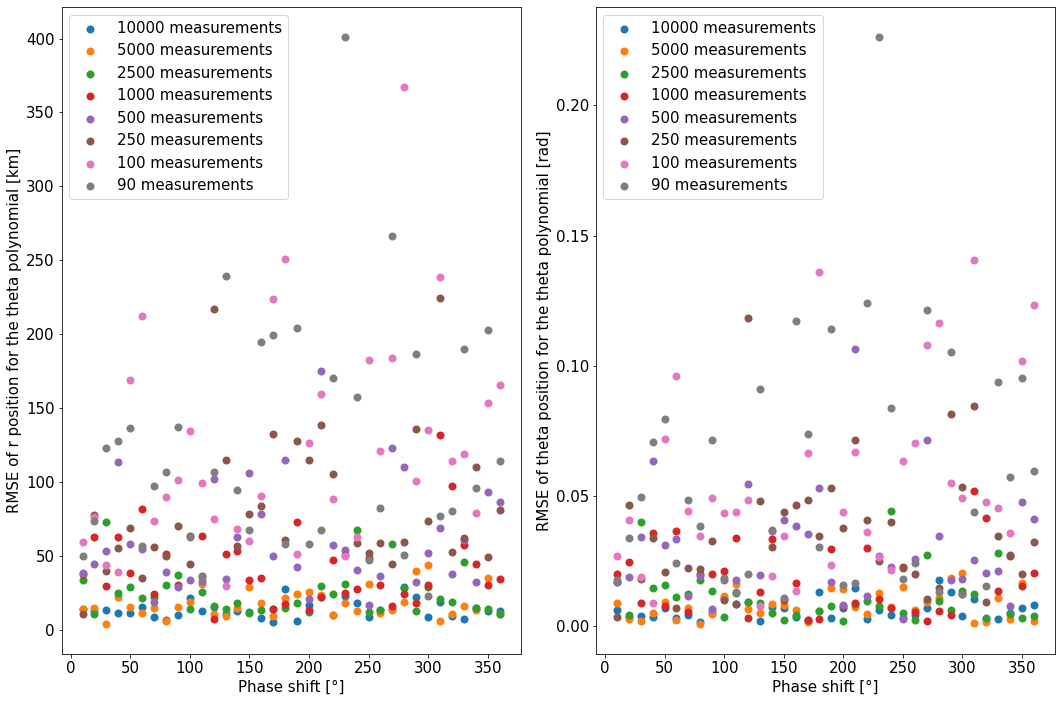

In [72]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 10))

for k in range(len(thetaBIG_tablearr)-12):
    ax1.scatter(theta_deg, RMSErpositionnoisymidtheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the theta polynomial [km]")
ax1.legend()

for k in range(len(thetaBIG_tablearr)-12):
    ax2.scatter(theta_deg, RMSEthetapositionnoisymidtheta[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the theta polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacompthetamidnoise.png", dpi=300)

# Display the plot
plt.show()

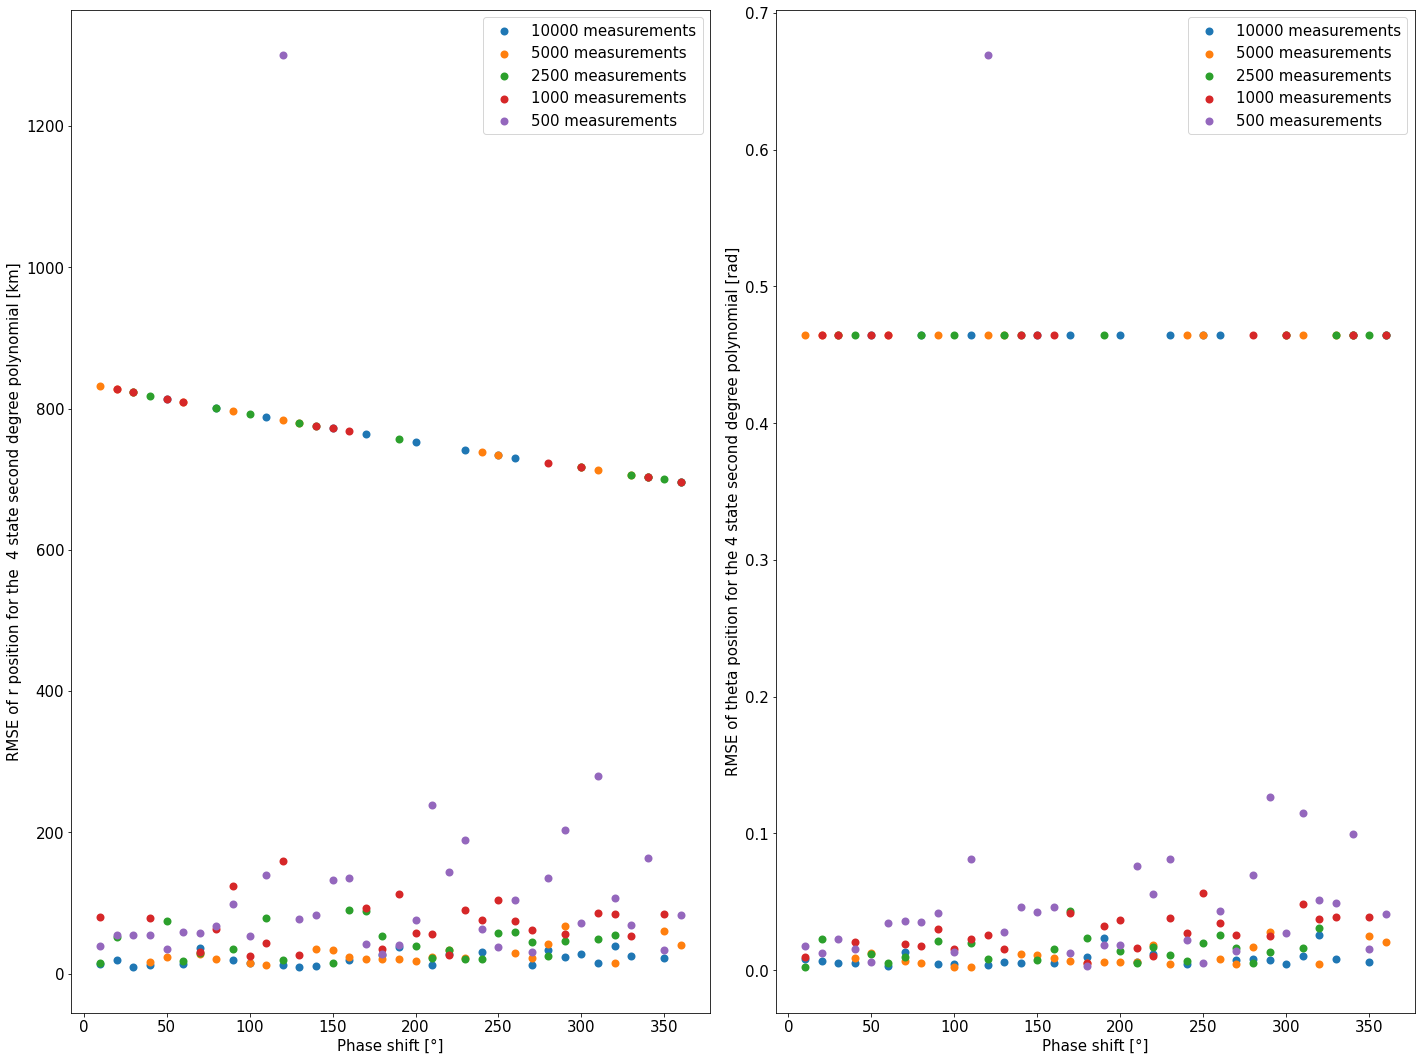

In [73]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,15))

for k in range(len(thetaBIG_tablearr)-15):
    ax1.scatter(theta_deg, RMSErpositionnoisylow[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the  4 state second degree polynomial [km]")
ax1.legend()

for k in range(len(thetaBIG_tablearr)-15):
    ax2.scatter(theta_deg, RMSEthetapositionnoisylow[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for the 4 state second degree polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacomp4statelownoise.png", dpi=300)

# Display the plot
plt.show()

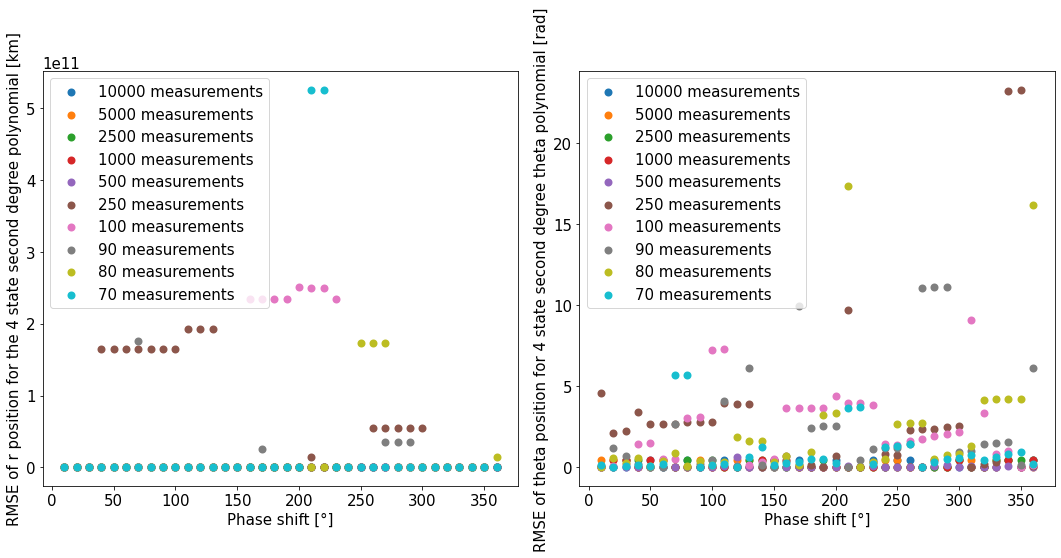

In [74]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 7))

for k in range(len(thetaBIG_tablearr)-10):
    ax1.scatter(theta_deg, RMSErpositionnoisylow[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position for the 4 state second degree polynomial [km]")
ax1.legend()

for k in range(len(thetaBIG_tablearr)-10):
    ax2.scatter(theta_deg, RMSEthetapositionnoisylow[k][1:], linewidth=2,label= str(len(thetaBIG_tablearr[k][:,3])) + " measurements")
ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position for 4 state second degree theta polynomial [rad]")
ax2.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("positionpredthetacomp4statelownoise.png", dpi=300)

# Display the plot
plt.show()

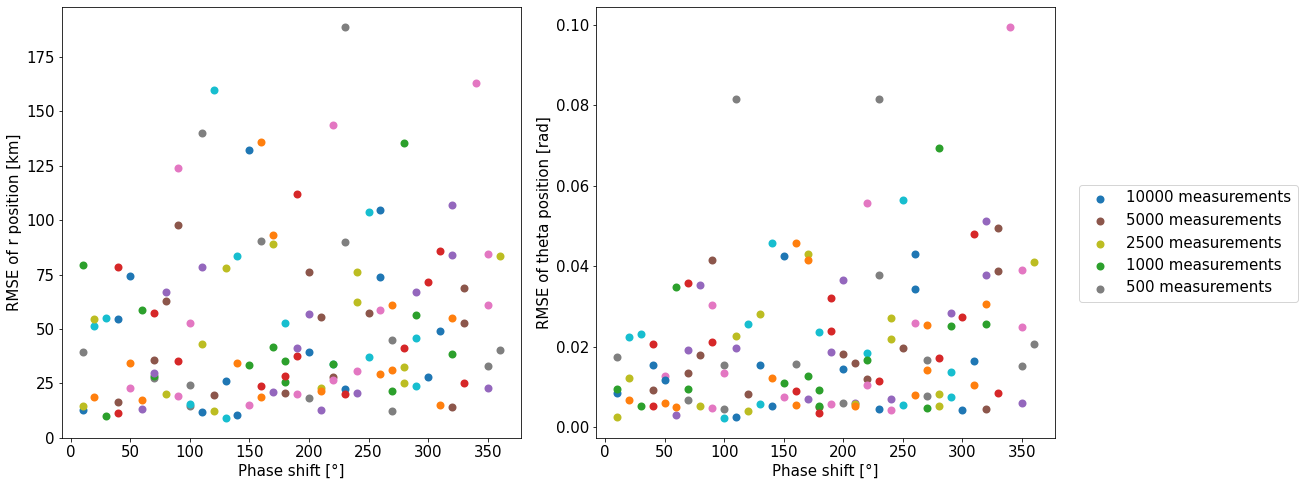

<Figure size 864x864 with 0 Axes>

In [75]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))


handles = []
labels = []

for k in range(len(thetaBIG_tablearr)-15):
    legend_added = False  # Initialize a flag to track if the legend has been added
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        # Extract RMSE values
        rmse_r = RMSErpositionnoisylow[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylow[k][1:][i]
        
        # Check if RMSErpositionnoisylow < 200 before plotting
        if rmse_r < 200:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = ax1.scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = ax2.scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)  # Collect handle for the legend
                labels.append(label)      # Collect label for the legend
                legend_added = True  # Set the flag to True after adding the legend
            else:
                ax1.scatter(theta_deg[i], rmse_r, linewidth=2)
                ax2.scatter(theta_deg[i], rmse_theta, linewidth=2)

ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position [km]")


ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position [rad]")


# Add a common legend on the side
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

# Save the figure
plt.savefig("positionpredcomp4statelownoisereport.png", dpi=300)

# Display the plot
plt.show()

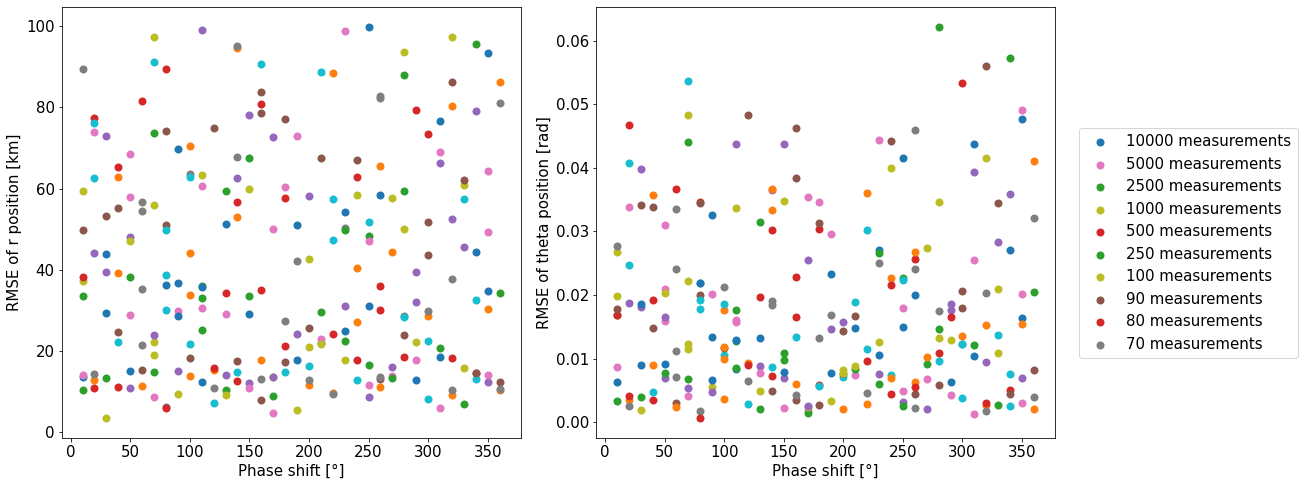

<Figure size 864x864 with 0 Axes>

In [76]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))


handles = []
labels = []

for k in range(len(thetaBIG_tablearr)-10):
    legend_added = False  # Initialize a flag to track if the legend has been added
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        # Extract RMSE values
        rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
        
        # Check if RMSErpositionnoisylow < 200 before plotting
        if rmse_r < 100:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = ax1.scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = ax2.scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)  # Collect handle for the legend
                labels.append(label)      # Collect label for the legend
                legend_added = True  # Set the flag to True after adding the legend
            else:
                ax1.scatter(theta_deg[i], rmse_r, linewidth=2)
                ax2.scatter(theta_deg[i], rmse_theta, linewidth=2)

ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position [km]")


ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position [rad]")


# Add a common legend on the side
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

# Save the figure
plt.savefig("positionpredcompmidnoisethetapolyreport.png", dpi=300)

# Display the plot
plt.show()

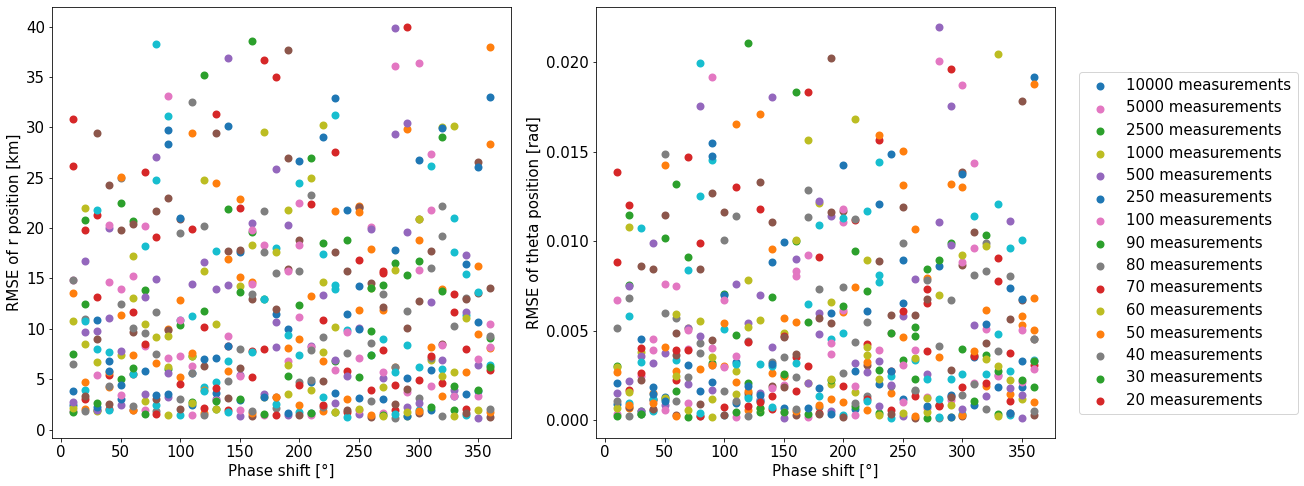

<Figure size 864x864 with 0 Axes>

In [77]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))


handles = []
labels = []

for k in range(len(thetaBIG_tablearr)-5):
    legend_added = False  # Initialize a flag to track if the legend has been added
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        # Extract RMSE values
        rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
        
        # Check if RMSErpositionnoisylow < 200 before plotting
        if rmse_r < 40:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = ax1.scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = ax2.scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)  # Collect handle for the legend
                labels.append(label)      # Collect label for the legend
                legend_added = True  # Set the flag to True after adding the legend
            else:
                ax1.scatter(theta_deg[i], rmse_r, linewidth=2)
                ax2.scatter(theta_deg[i], rmse_theta, linewidth=2)

ax1.set_xlabel("Phase shift [°]")
ax1.set_ylabel("RMSE of r position [km]")


ax2.set_xlabel("Phase shift [°]")
ax2.set_ylabel("RMSE of theta position [rad]")


# Add a common legend on the side
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

# Save the figure
plt.savefig("positionpredcomplownoisethetapolyreport.png", dpi=300)

# Display the plot
plt.show()

In [78]:
len(RMSErpositionnoisylow[k][1:])

36

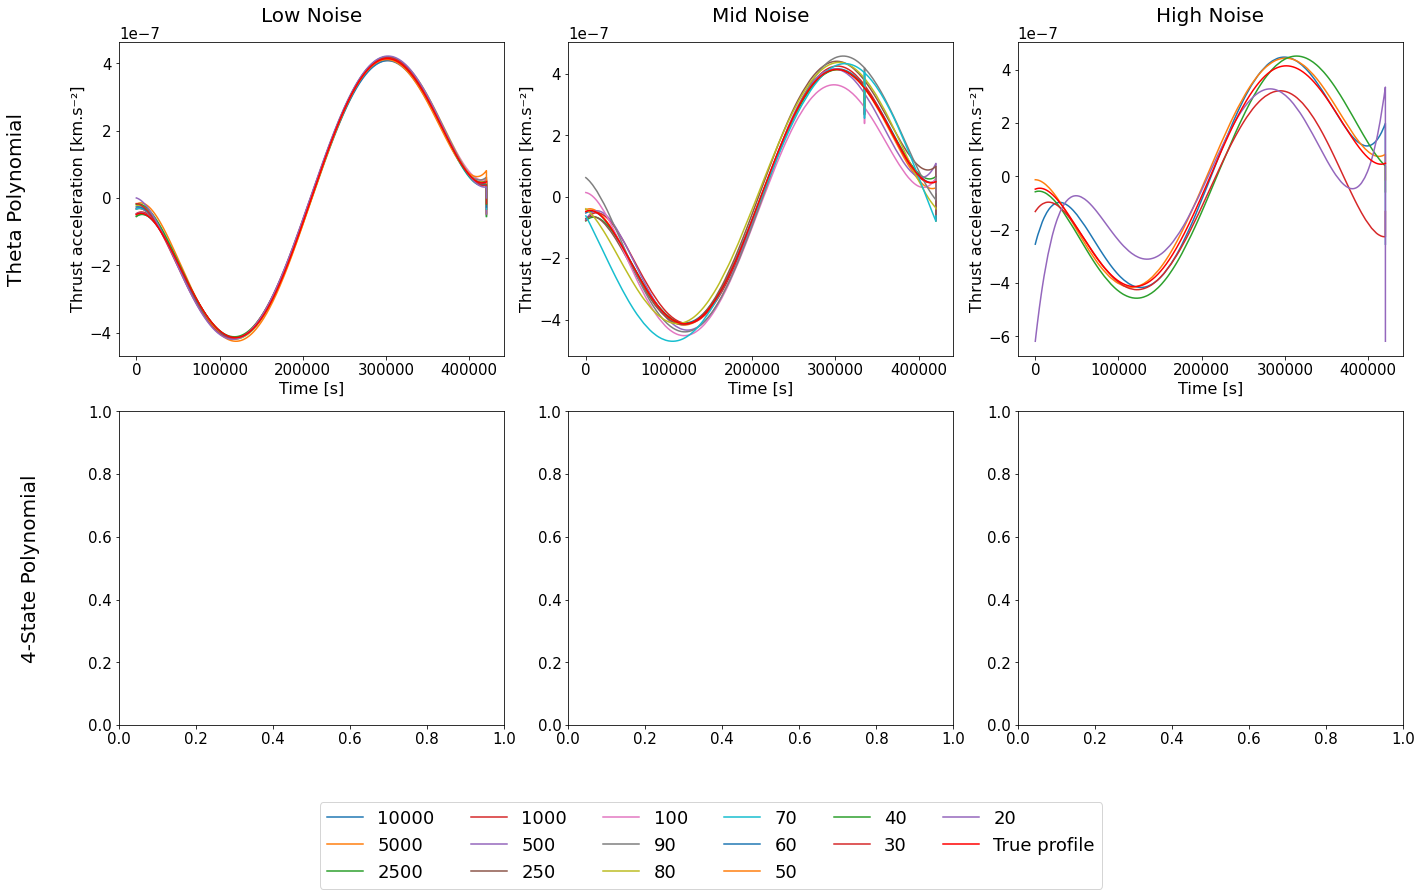

In [122]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(2, 3, figsize=(20, 12))  # Increase the figure size for larger plots

# Add column headers with larger font size
column_headers = ['Low Noise', 'Mid Noise', 'High Noise']
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=20, pad=20)  # Increase font size for column headers

# Add row headers with larger font size
row_headers = ['Theta Polynomial', '4-State Polynomial']
for ax, row in zip(axs[:, 0], row_headers):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),  # Increase offset for more space
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='center', va='center', rotation=90)  # Increase font size for row headers

# First row, first column (Theta polynomial, low noise)
for k in range(len(thetaBIG_tablearr) - 5):
    axs[0, 0].plot(time_table[:, 0], Thrustreproducedthetanoisylow[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 0].set_xlabel('Time [s]', fontsize=16)
axs[0, 0].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 0].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# First row, second column (Theta polynomial, mid noise)
for k in range(len(thetaBIG_tablearr) - 10):
    axs[0, 1].plot(time_table[:, 0], Thrustreproducedthetanoisymid[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 1].set_xlabel('Time [s]', fontsize=16)
axs[0, 1].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 1].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# First row, third column (Theta polynomial, high noise)
for k in range(len(thetaBIG_tablearr) - 15):
    axs[0, 2].plot(time_table[:, 0], Thrustreproducedthetanoisyhigh[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 2].set_xlabel('Time [s]', fontsize=16)
axs[0, 2].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 2].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# # Second row, first column (4-state polynomial, low noise)
# for k in range(len(thetaBIG_tablearr) - 5):
#     axs[1, 0].plot(time_table[:, 0], Thrustreproduced4statesnoisylow[k][:, 0],
#                    label=str(len(thetaBIG_tablearr[k][:, 3])))
# axs[1, 0].set_xlabel('Time [s]', fontsize=16)
# axs[1, 0].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
# axs[1, 0].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# # Second row, second column (4-state polynomial, mid noise)
# for k in range(len(thetaBIG_tablearr) - 10):
#     axs[1, 1].plot(time_table[:, 0], Thrustreproduced4statesnoisymid[k][:, 0],
#                    label=str(len(thetaBIG_tablearr[k][:, 3])))
# axs[1, 1].set_xlabel('Time [s]', fontsize=16)
# axs[1, 1].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
# axs[1, 1].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# # Second row, third column (4-state polynomial, high noise)
# for k in range(len(thetaBIG_tablearr) - 18):
#     axs[1, 2].plot(time_table[:, 0], Thrustreproduced4statesnoisyhigh[k][:, 0],
#                    label=str(len(thetaBIG_tablearr[k][:, 3])))
# axs[1, 2].set_xlabel('Time [s]', fontsize=16)
# axs[1, 2].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
# axs[1, 2].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# Adjust layout to make space for labels and legends
plt.tight_layout()

# Create a common horizontal legend below the plots with larger font size
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize='large', bbox_to_anchor=(0.5, -0.05))

# Adjust the layout so the legend does not overlap with the plots
plt.subplots_adjust(bottom=0.15)

# Display the plots
plt.savefig("thrustnoisylevelsall.pdf", bbox_inches='tight')
plt.show()


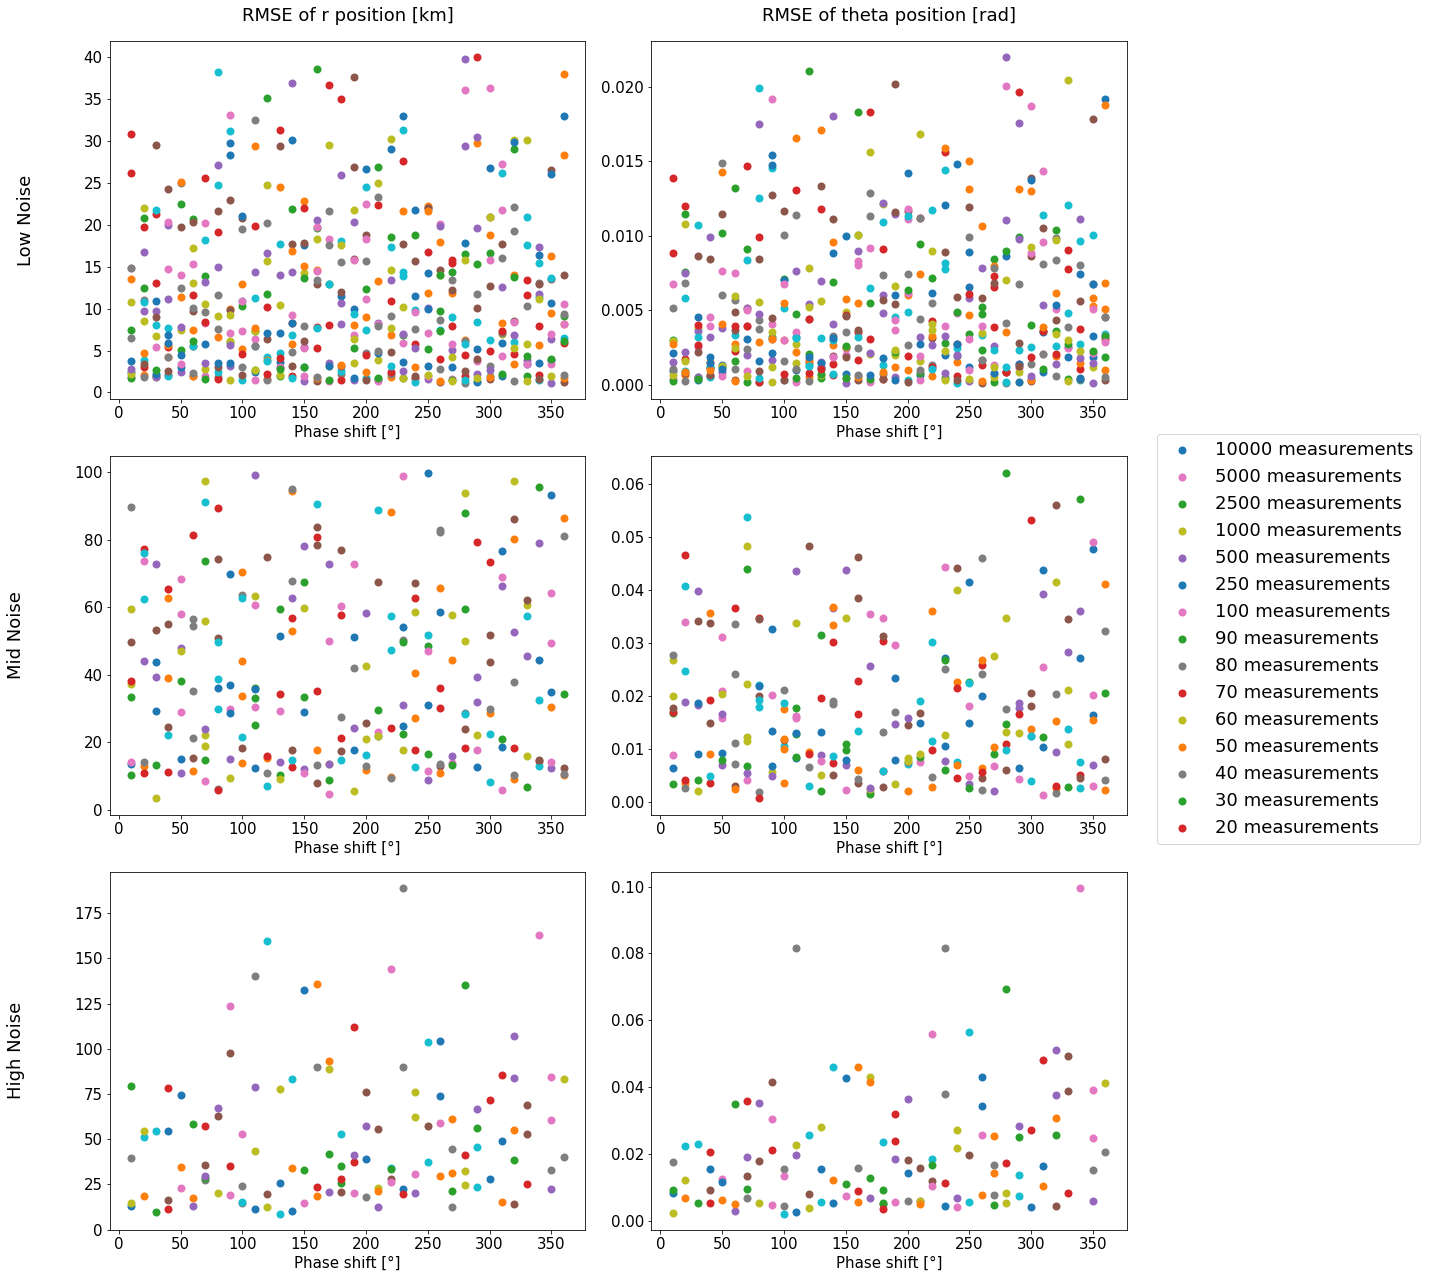

In [80]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(3, 2, figsize=(20, 18))  # 3 rows and 2 columns

# Define the column and row headers
column_headers = ['RMSE of r position [km]', 'RMSE of theta position [rad]']
row_headers = ['Low Noise', 'Mid Noise', 'High Noise']

# Assign the headers
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=18, pad=20)  # Increase font size for column headers

for ax, row in zip(axs[:, 0], row_headers):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=18, ha='center', va='center', rotation=90)  # Increase font size for row headers

# First row (Low Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 5):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
        if rmse_r < 40:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
                axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Second row (Mid Noise)
for k in range(len(thetaBIG_tablearr) - 10):
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
        if rmse_r < 100:
            axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
            axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Third row (High Noise)
for k in range(len(thetaBIG_tablearr) - 15):
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylow[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylow[k][1:][i]
        if rmse_r < 200:
            axs[2, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
            axs[2, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Set common x-label for all subplots
for ax in axs[:, :].flatten():
    ax.set_xlabel("Phase shift [°]", fontsize=15)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Create a common legend on the right side with larger font size, only for low noise
fig.legend(handles, labels, loc='center right', fontsize='large')

# Display the plots
plt.show()


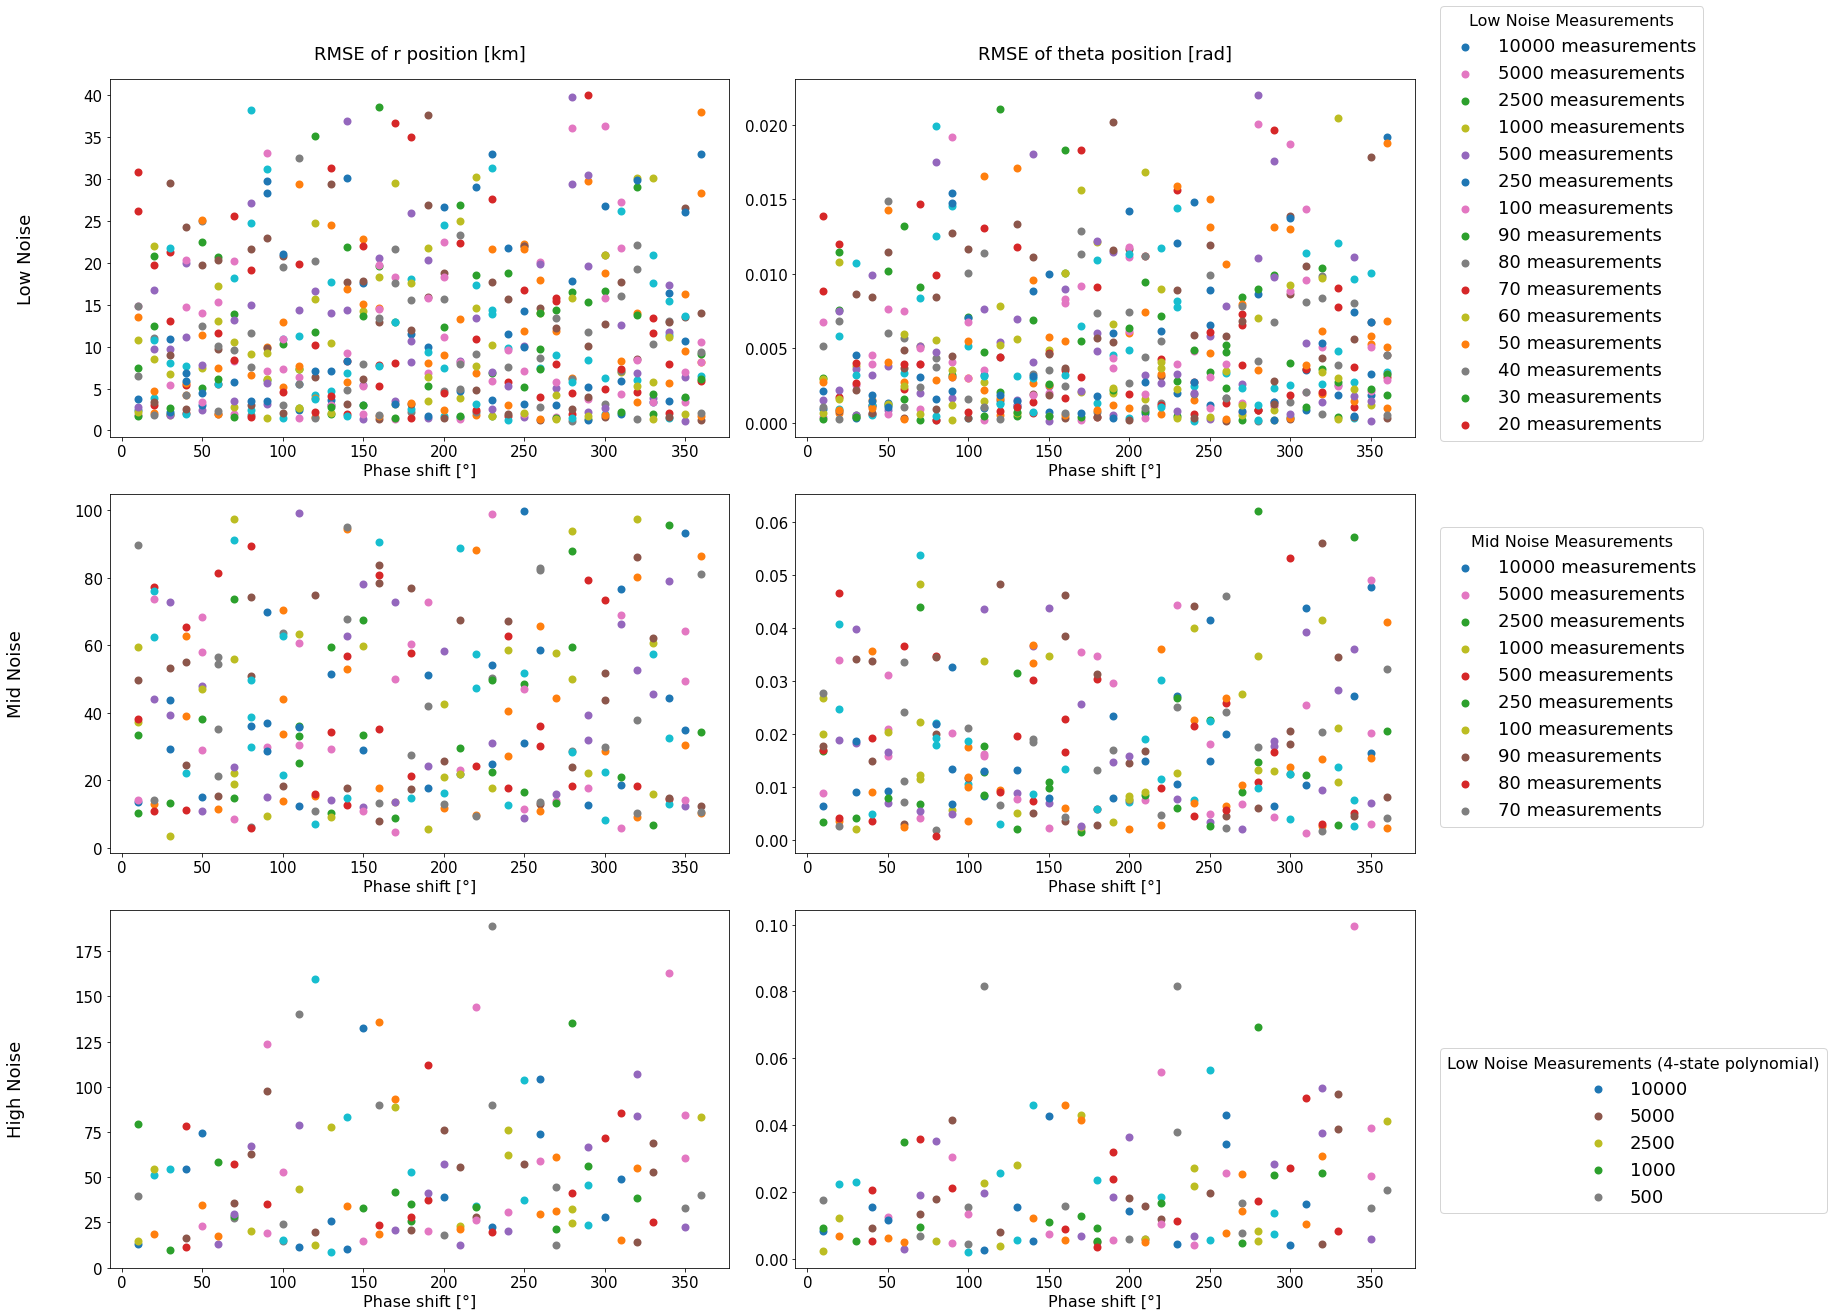

In [81]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(3, 2, figsize=(20, 18))  # 3 rows and 2 columns

# Define the column and row headers
column_headers = ['RMSE of r position [km]', 'RMSE of theta position [rad]']
row_headers = ['Low Noise', 'Mid Noise', 'High Noise']

# Assign the headers
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=18, pad=20)  # Increase font size for column headers

for ax, row in zip(axs[:, 0], row_headers):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=18, ha='center', va='center', rotation=90)  # Increase font size for row headers

# First row (Low Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 5):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
        if rmse_r < 40:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
                axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Add a legend to the first row
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.85), fontsize='large', title="Low Noise Measurements", title_fontsize='16')

# Second row (Mid Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 10):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
        if rmse_r < 100:
            label = str(len(thetaBIG_tablearr[k][:, 3])) + " measurements"
            if not legend_added:
                handle1 = axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
                axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Add a legend to the second row
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large', title="Mid Noise Measurements", title_fontsize='16')

# Third row (High Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 15):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylow[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylow[k][1:][i]
        if rmse_r < 200:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[2, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
                handle2 = axs[2, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[2, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
                axs[2, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# Add a legend to the third row
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.15), fontsize='large', title="Low Noise Measurements (4-state polynomial)", title_fontsize='16')

# Set common x-label for all subplots
for ax in axs[:, :].flatten():
    ax.set_xlabel("Phase shift [°]", fontsize=16)

# Adjust layout to make space for the legends
plt.tight_layout(rect=[0, 0, 1, 1])

# Display the plots
plt.show()


# Official plots in the report

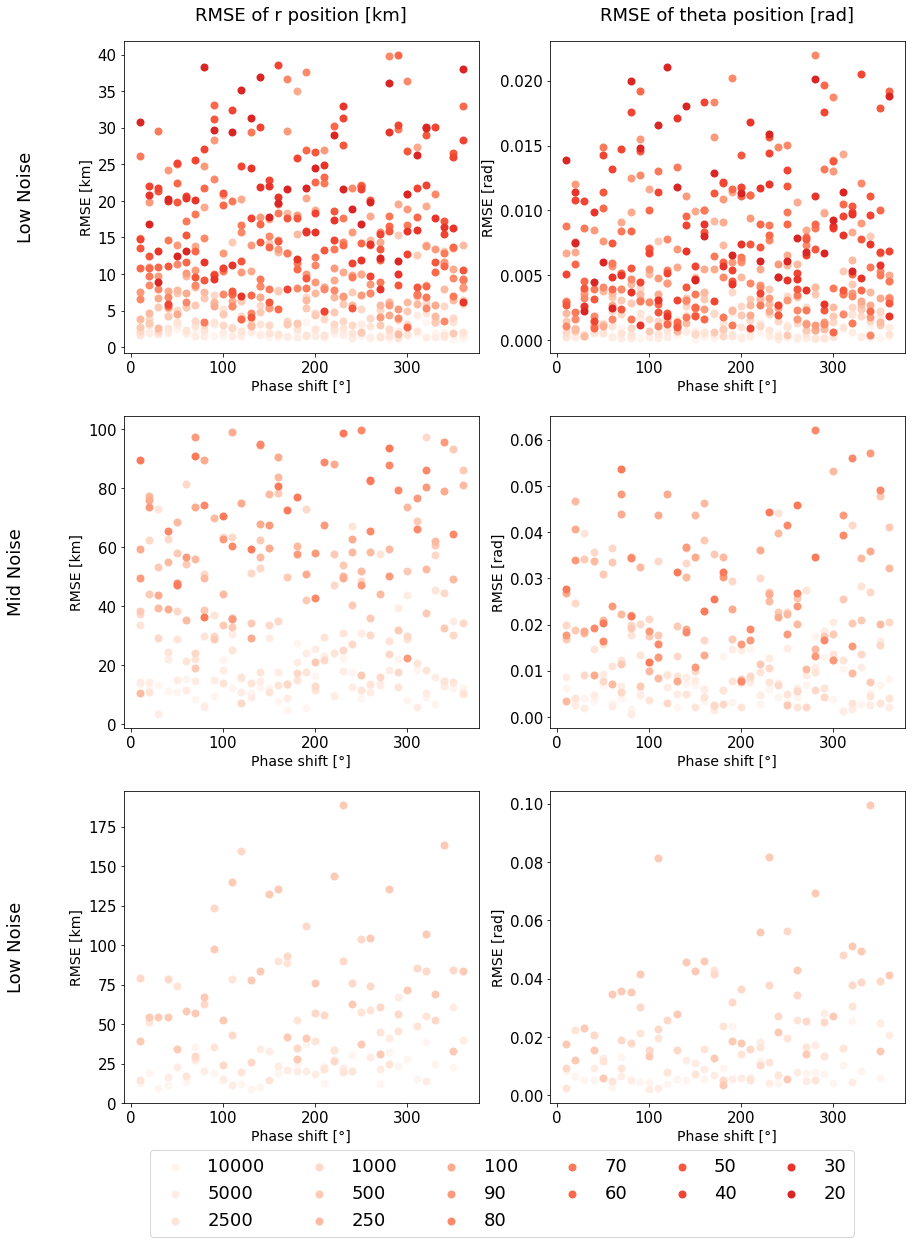

In [82]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with adjusted figure size
fig, axs = plt.subplots(3, 2, figsize=(14, 18))  # Adjust width to 14

# Define the column and row headers
column_headers = ['RMSE of r position [km]', 'RMSE of theta position [rad]']
row_headers = ['Low Noise', 'Mid Noise', 'Low Noise']
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 1, 21))
# Assign the headers
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=18, pad=20)  # Increase font size for column headers

for ax, row in zip(axs[:, 0], row_headers):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=18, ha='center', va='center', rotation=90)  # Increase font size for row headers

# First row (Low Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 5):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
        if rmse_r < 40:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label,color=colors[k])
                handle2 = axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label,color=colors[k])
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2,color=colors[k])
                axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2,color=colors[k])

# Add a legend to the first row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.85), fontsize='large', title="Low Noise (theta model)", title_fontsize='16')

# Second row (Mid Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 10):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
        if rmse_r < 100:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label,color=colors[k])
                handle2 = axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label,color=colors[k])
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2,color=colors[k])
                axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2,color=colors[k])

# Add a legend to the second row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large', title="Mid Noise (theta model)", title_fontsize='16')

# Third row (High Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 15):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylow[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylow[k][1:][i]
        if rmse_r < 200:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[2, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label,color=colors[k])
                handle2 = axs[2, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label,color=colors[k])
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[2, 0].scatter(theta_deg[i], rmse_r, linewidth=2,color=colors[k])
                axs[2, 1].scatter(theta_deg[i], rmse_theta, linewidth=2,color=colors[k])

# Add a legend to the third row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.15), fontsize='large', title="Low Noise (4-state model)", title_fontsize='16')


# Create a common horizontal legend below the plots with larger font size
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize='large', bbox_to_anchor=(0.5, -0.05))

# Adjust the layout so the legend does not overlap with the plots
plt.subplots_adjust(bottom=0.06)

# Display the plots
plt.savefig("noisypositionerrorall.pdf", bbox_inches='tight')



# Set common x-label and y-label for all subplots
for ax in axs.flat:
    ax.set_xlabel("Phase shift [°]", fontsize=14)
    ax.set_ylabel("RMSE [km]" if ax in axs[:, 0] else "RMSE [rad]", fontsize=14)


plt.show()



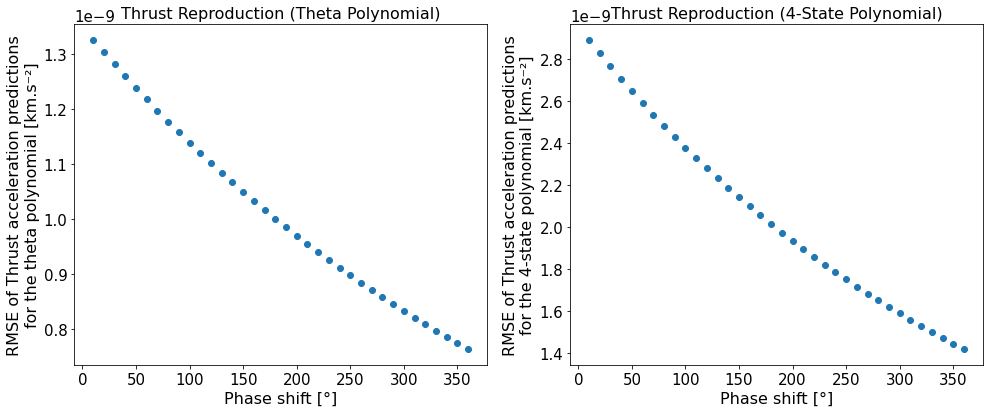

In [83]:

# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the figsize as needed

# First plot (Theta polynomial model)
axs[0].scatter(theta_deg, RMSEThrusttheta[0][1:])
axs[0].set_xlabel("Phase shift [°]", fontsize=16)  # Set x-axis label
axs[0].set_ylabel("RMSE of Thrust acceleration predictions\nfor the theta polynomial [km.s⁻²]", fontsize=16)  # Set y-axis label
axs[0].set_title("Thrust Reproduction (Theta Polynomial)", fontsize=16)  # Add a title


# Second plot (4-state polynomial model)
axs[1].scatter(theta_deg, RMSEThrust4state[0][1:])
axs[1].set_xlabel("Phase shift [°]", fontsize=16)  # Set x-axis label
axs[1].set_ylabel("RMSE of Thrust acceleration predictions\nfor the 4-state polynomial [km.s⁻²]", fontsize=16)  # Set y-axis label
axs[1].set_title("Thrust Reproduction (4-State Polynomial)", fontsize=16)  # Add a title


# Adjust layout to make sure labels/titles fit well
plt.tight_layout()

# Save the combined plot to a file
plt.savefig("thrust_reproduction_analysis_1x2.pdf", dpi=300,bbox_inches='tight')  # Save the plot with a specified DPI for better quality

# Display the plot
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


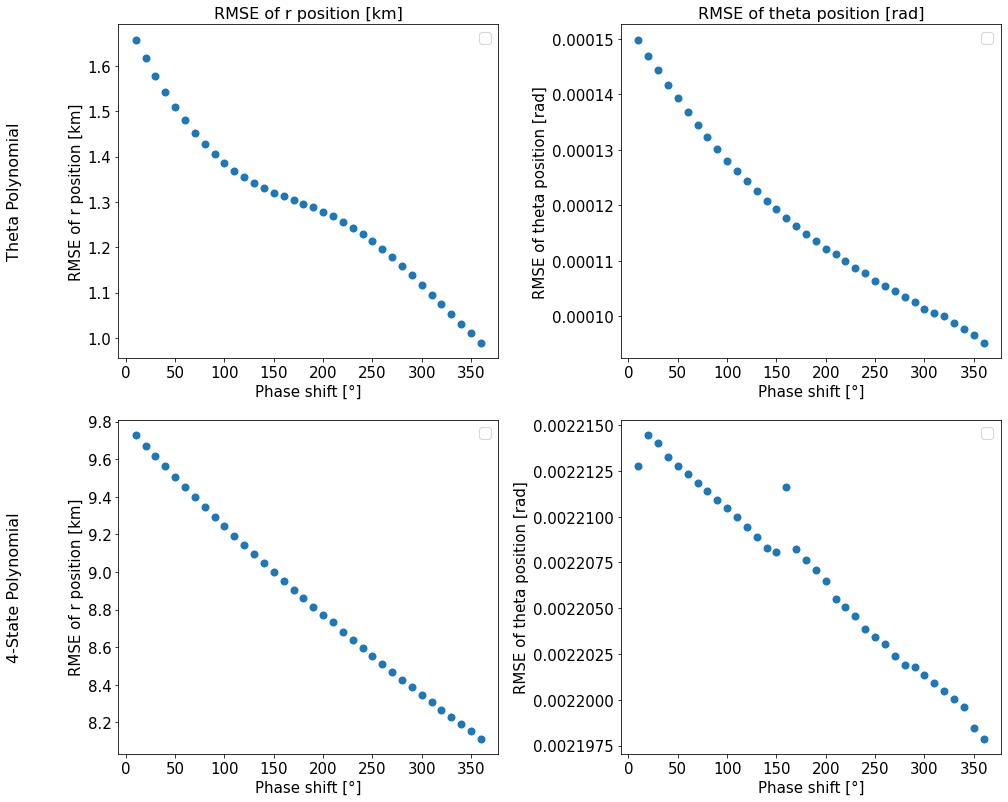

In [84]:
import matplotlib.pyplot as plt

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Define the row and column titles
row_titles = ['Theta Polynomial', '4-State Polynomial']
column_titles = ['RMSE of r position [km]', 'RMSE of theta position [rad]']

# First row (Theta Polynomial)
axs[0, 0].scatter(theta_deg, RMSErpositiontheta[0][1:], linewidth=2)
axs[0, 0].set_xlabel("Phase shift [°]")
axs[0, 0].set_ylabel("RMSE of r position [km]")
axs[0, 0].legend()

axs[0, 1].scatter(theta_deg, RMSEthetapositiontheta[0][1:], linewidth=2)
axs[0, 1].set_xlabel("Phase shift [°]")
axs[0, 1].set_ylabel("RMSE of theta position [rad]")
axs[0, 1].legend()

# Second row (4-State Polynomial)
axs[1, 0].scatter(theta_deg, RMSErposition[0][1:], linewidth=2)
axs[1, 0].set_xlabel("Phase shift [°]")
axs[1, 0].set_ylabel("RMSE of r position [km]")
axs[1, 0].legend()

axs[1, 1].scatter(theta_deg[::-1], RMSEthetaposition[0][1:], linewidth=2)
axs[1, 1].set_xlabel("Phase shift [°]")
axs[1, 1].set_ylabel("RMSE of theta position [rad]")
axs[1, 1].legend()

# Set the row titles
for ax, row_title in zip(axs[:, 0], row_titles):
    ax.annotate(row_title, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=16, ha='center', va='center', rotation=90)

# Set the column titles
for ax, col_title in zip(axs[0], column_titles):
    ax.set_title(col_title, size=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0, 1, 0.95])

# Save the combined figure
plt.savefig("combined_position_predictions_reordered.pdf", dpi=300,bbox_inches='tight')

# Display the combined plot
plt.show()


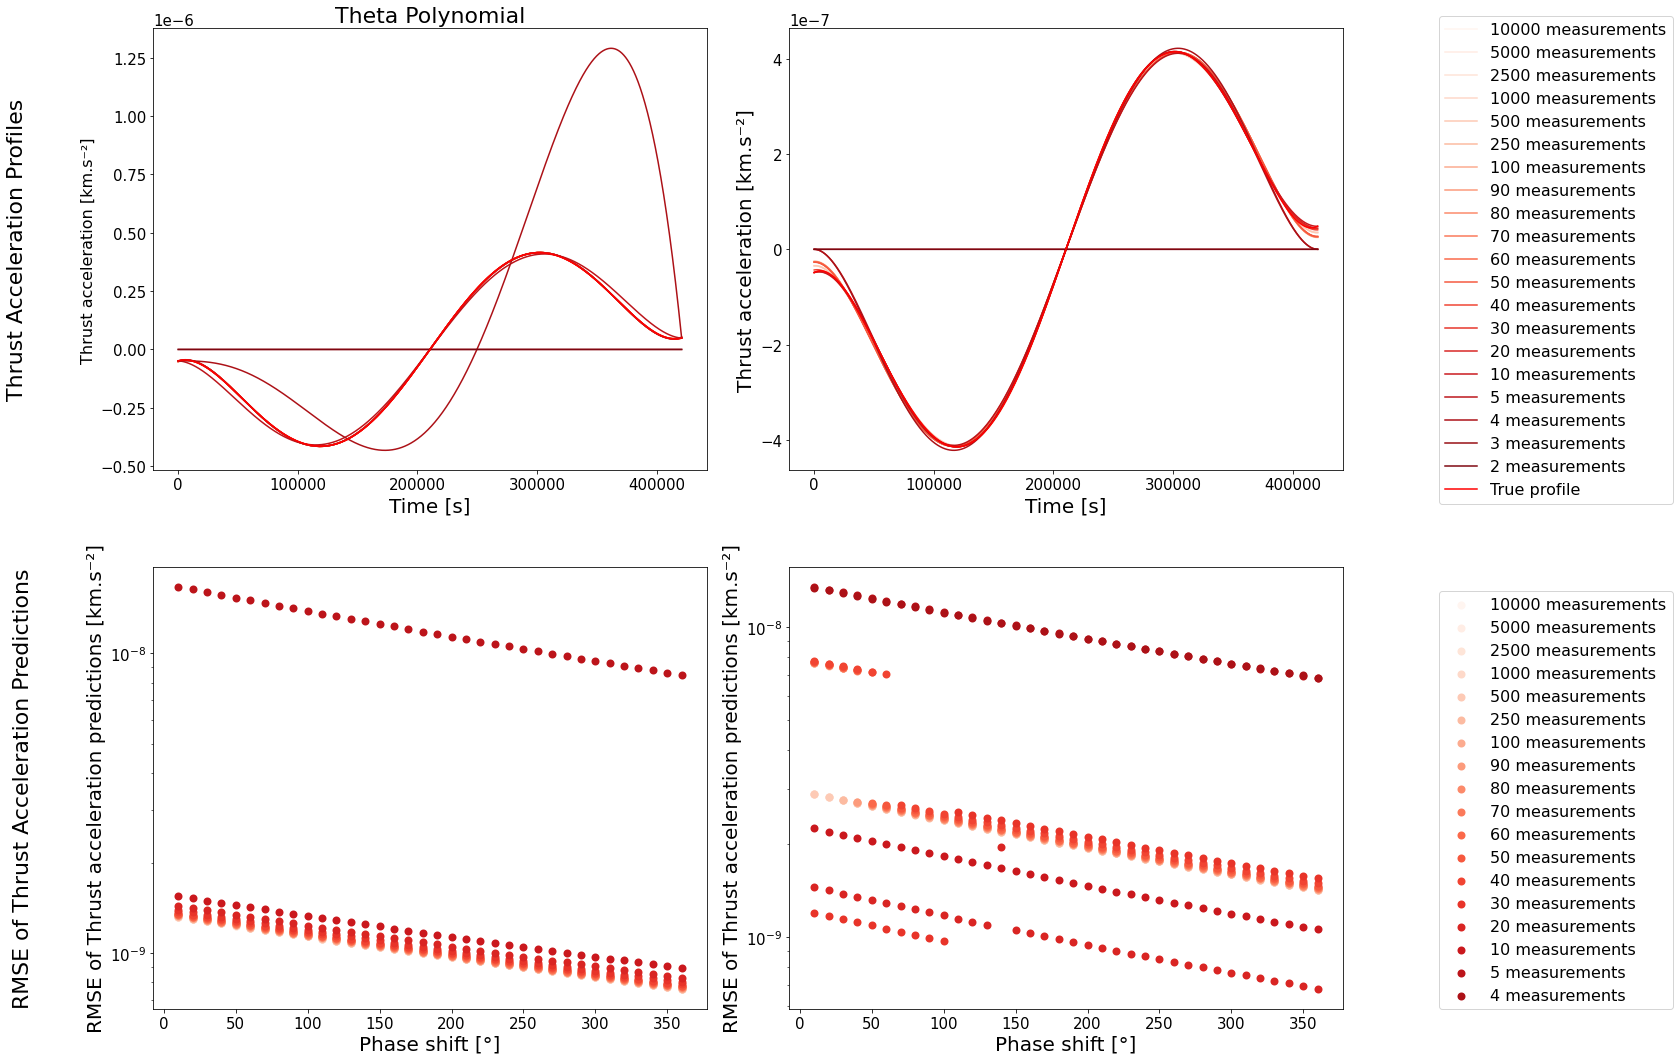

In [163]:
import matplotlib.pyplot as plt

# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Define the row and column titles
row_titles = ['Thrust Acceleration Profiles', 'RMSE of Thrust Acceleration Predictions']
column_titles = ['Theta Polynomial']

# Plot the thrust profiles in the top row
for k in range(len(thetaBIG_tablearr)):
    ax1.plot(time_table[:,0], Thrustreproducedtheta[k][:,0], label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax1.plot(time_table[:,0], Thrust_table[:,0], label="True profile", color="red")
ax1.set_xlabel('Time [s]', fontsize=20)
ax1.set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
#ax1.grid(True)

for k in range(len(thetaBIG_tablearr)):
    ax2.plot(time_table[:,0], Thrustreproduced4states[k][:,0], label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax2.plot(time_table[:,0], Thrust_table[:,0], label="True profile", color="red")
ax2.set_xlabel('Time [s]', fontsize=20)
ax2.set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=20)
#ax2.grid(True)

# Plot the RMSE data in the bottom row for theta-based predictions
for k in range(len(thetaBIG_tablearr)-3):
    ax3.scatter(theta_deg, RMSEThrusttheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements", color=colors[k])
ax3.set_xlabel("Phase shift [°]", fontsize=20)
ax3.set_ylabel("RMSE of Thrust acceleration predictions [km.s⁻²]", fontsize=20)
ax3.set_yscale('log')  # Set y-axis to log scale
#ax3.grid(True)

# Plot the RMSE data in the bottom row for 4-state predictions
for k in range(len(thetaBIG_tablearr)-2):
    ax4.scatter(theta_deg, RMSEThrust4state[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements", color=colors[k])
ax4.set_xlabel("Phase shift [°]", fontsize=20)
ax4.set_ylabel("RMSE of Thrust acceleration predictions [km.s⁻²]", fontsize=20)
ax4.set_yscale('log')  # Set y-axis to log scale
#ax4.grid(True)

# Collect legends for common legends
# For the top row (Thrust Acceleration Profiles)
lines_top, labels_top = ax2.get_legend_handles_labels()
# For the bottom row (RMSE Analysis)
lines_bottom, labels_bottom = ax4.get_legend_handles_labels()

# Remove legends from individual subplots
ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()
ax4.legend().remove()

# Create a common legend for the top row on the right side
fig.legend(handles=lines_top, labels=labels_top, loc='center left', bbox_to_anchor=(1.05, 0.75), fontsize=16)

# Create a common legend for the bottom row on the right side
fig.legend(handles=lines_bottom, labels=labels_bottom, loc='center left', bbox_to_anchor=(1.05, 0.25), fontsize=16)

# Add row titles
for ax, row_title in zip([ax1, ax3], row_titles):
    ax.annotate(row_title, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 60, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=22, ha='center', va='center', rotation=90)

# Add column titles
for ax, col_title in zip([ax1, ax2], column_titles):
    ax.set_title(col_title, size=22)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust rectangle to fit titles and legends

# Save the figure
plt.savefig("focused_comparison_with_time_series_and_rmse.pdf", dpi=300,bbox_inches='tight')

# Display the plot
plt.show()


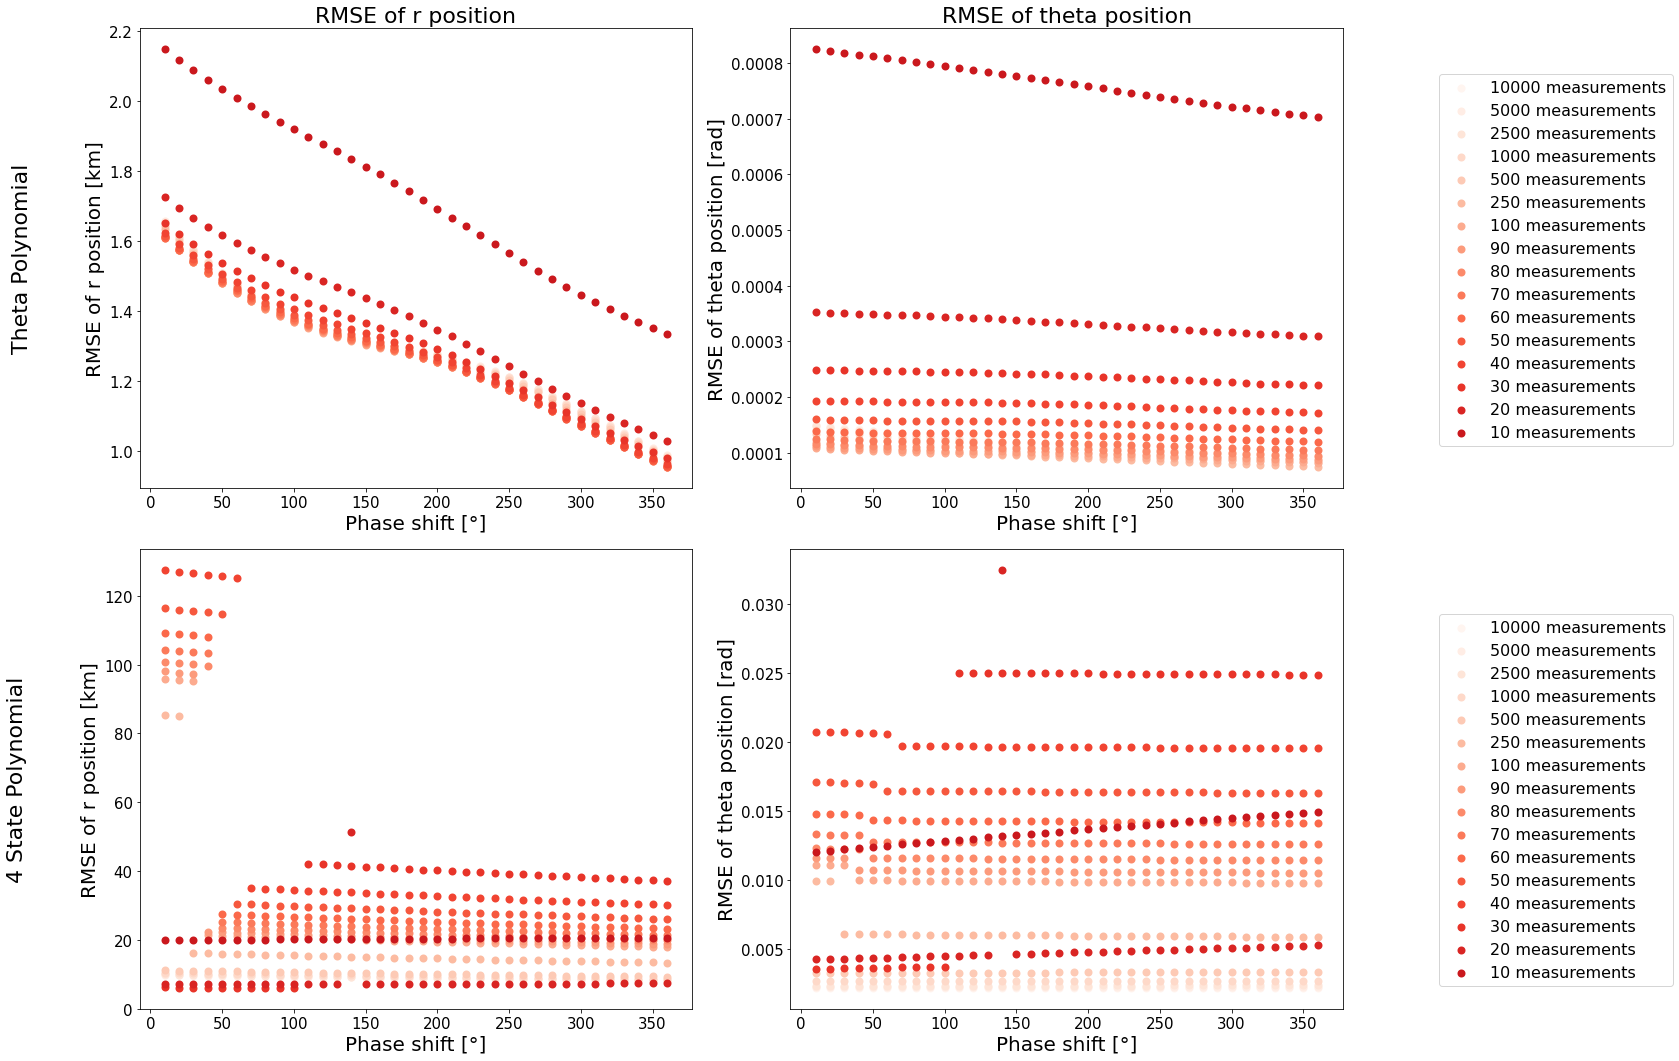

In [86]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Plot data for the first row (Theta Polynomial)
for k in range(len(thetaBIG_tablearr)-4):
    ax1.scatter(theta_deg, RMSErpositiontheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax1.set_xlabel("Phase shift [°]", fontsize=20)
ax1.set_ylabel("RMSE of r position [km]", fontsize=20)
#ax1.grid(True)

for k in range(len(thetaBIG_tablearr)-4):
    ax2.scatter(theta_deg, RMSEthetapositiontheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax2.set_xlabel("Phase shift [°]", fontsize=20)
ax2.set_ylabel("RMSE of theta position [rad]", fontsize=20)
#ax2.grid(True)

# Plot data for the second row (4 State Polynomial)
for k in range(len(thetaBIG_tablearr)-4):
    ax3.scatter(theta_deg, RMSErposition[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax3.set_xlabel("Phase shift [°]", fontsize=20)
ax3.set_ylabel("RMSE of r position [km]", fontsize=20)


for k in range(len(thetaBIG_tablearr)-4):
    ax4.scatter(theta_deg, RMSEthetaposition[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])) + " measurements",color=colors[k])
ax4.set_xlabel("Phase shift [°]", fontsize=20)
ax4.set_ylabel("RMSE of theta position [rad]", fontsize=20)


# Collect legends for common legends
# For the top row (Theta Polynomial)
lines_top, labels_top = ax2.get_legend_handles_labels()
# For the bottom row (4 State Polynomial)
lines_bottom, labels_bottom = ax4.get_legend_handles_labels()

# Remove legends from individual subplots
ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()
ax4.legend().remove()

# Create a common legend for the top row on the right side
fig.legend(handles=lines_top, labels=labels_top, loc='center left', bbox_to_anchor=(1.05, 0.75), fontsize=16)

# Create a common legend for the bottom row on the right side
fig.legend(handles=lines_bottom, labels=labels_bottom, loc='center left', bbox_to_anchor=(1.05, 0.25), fontsize=16)

# Add row titles
row_titles = ['Theta Polynomial', '4 State Polynomial']
for ax, row_title in zip([ax1, ax3], row_titles):
    ax.annotate(row_title, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 60, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=22, ha='center', va='center', rotation=90)

# Add column titles
column_titles = ['RMSE of r position', 'RMSE of theta position']
for ax, col_title in zip([ax1, ax2], column_titles):
    ax.set_title(col_title, size=22)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust rectangle to fit titles and legends

# Save the figure
plt.savefig("combined_rmse_analysis.pdf", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


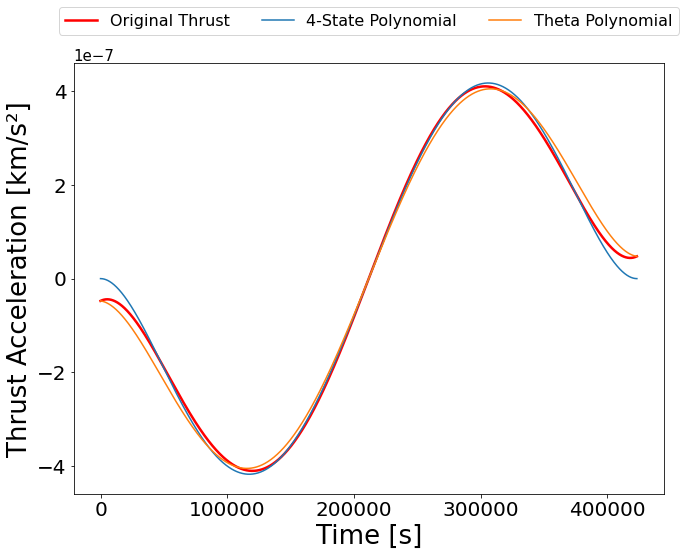

In [87]:
# Create a figure with adjusted height
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Plotting the data with specified color and line width for the original thrust
plt.plot(time_table[:, 1], ThrustBIG_tablearr[0][:, 1], label='Original Thrust', color='red', linewidth=2.5)
plt.plot(time_table[:, 1], Thrustreproduced4states[17][:, 1], label='4-State Polynomial')
plt.plot(time_table[:, 1], Thrustreproducedtheta[16][:, 1], label='Theta Polynomial')

# Adding axis labels
plt.xlabel('Time [s]', fontsize=26)
plt.ylabel('Thrust Acceleration [km/s²]', fontsize=26)

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=20)

# Adding a legend at the top
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=16, ncol=3)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for the legend

# Save the plot as a PDF
plt.savefig("thrust_profiles_of_approximations.pdf", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



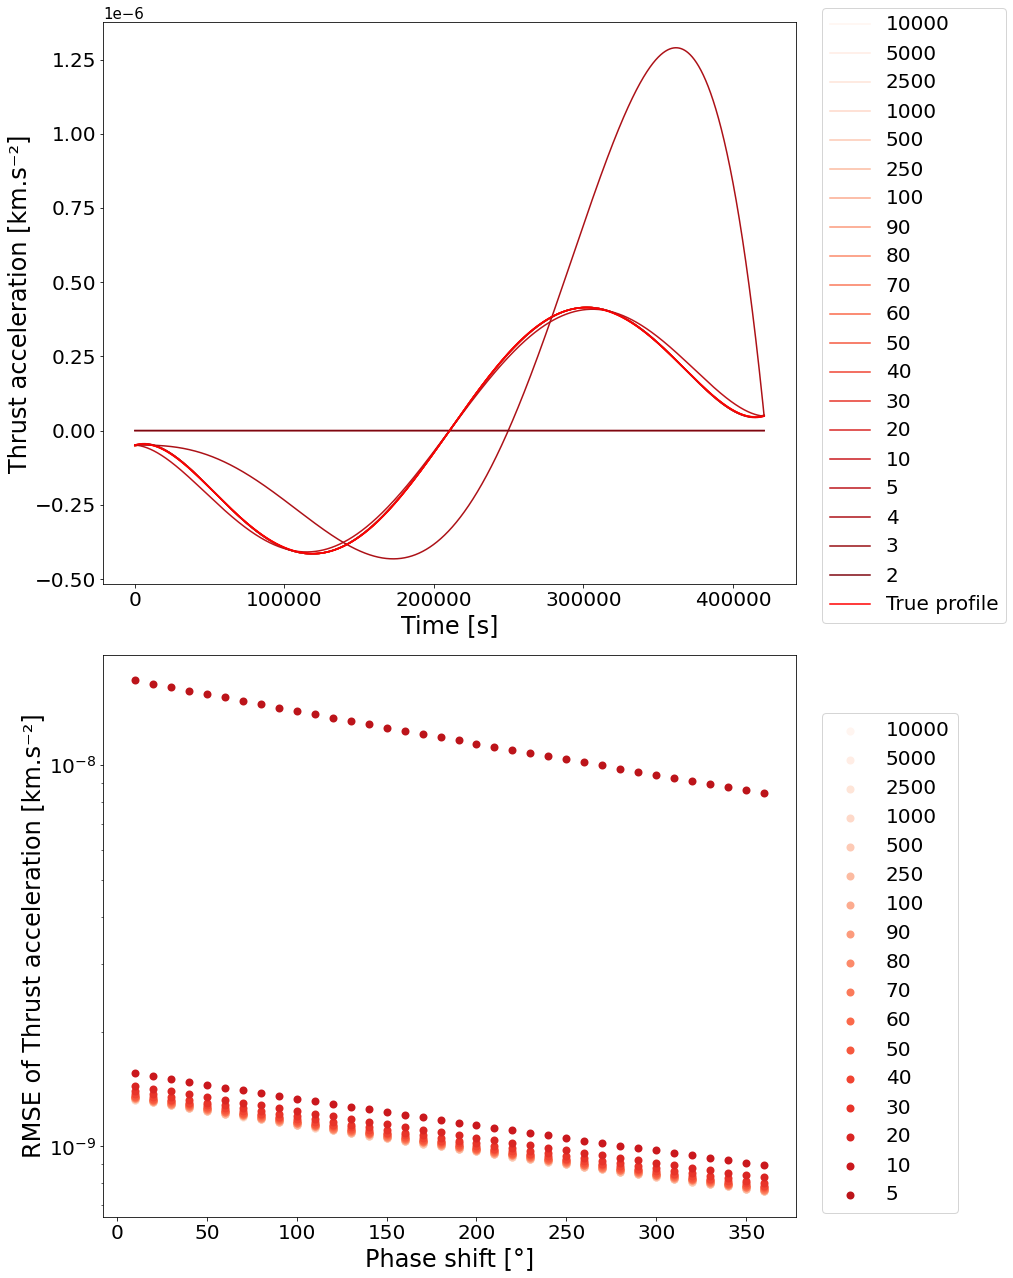

In [164]:
import matplotlib.pyplot as plt

# Create a figure with a 2x1 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 18))

# Plot the thrust profiles in the top row
for k in range(len(thetaBIG_tablearr)):
    ax1.plot(time_table[:, 0], Thrustreproducedtheta[k][:, 0], label=str(len(thetaBIG_tablearr[k][:, 3])), color=colors[k])
ax1.plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")
ax1.set_xlabel('Time [s]', fontsize=24)
ax1.set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=24)

# Increase tick size for the top plot
ax1.tick_params(axis='both', which='major', labelsize=20)

# Plot the RMSE data in the bottom row
for k in range(len(thetaBIG_tablearr) - 3):
    ax2.scatter(theta_deg, RMSEThrusttheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:, 3])), color=colors[k])
ax2.set_xlabel("Phase shift [°]", fontsize=24)
ax2.set_ylabel("RMSE of Thrust acceleration [km.s⁻²]", fontsize=24)
ax2.set_yscale('log')  # Set y-axis to log scale

# Increase tick size for the bottom plot
ax2.tick_params(axis='both', which='major', labelsize=20)

# Collect legends for common legends
# For the top row (Thrust Acceleration Profiles)
lines_top, labels_top = ax1.get_legend_handles_labels()

# For the bottom row (RMSE Analysis)
lines_bottom, labels_bottom = ax2.get_legend_handles_labels()

# Remove legends from individual subplots
ax1.legend().remove()
ax2.legend().remove()

# Create a common legend for the top row on the right side
fig.legend(handles=lines_top, labels=labels_top, loc='center left', bbox_to_anchor=(1, 0.75), fontsize=20)

# Create a common legend for the bottom row on the right side
fig.legend(handles=lines_bottom, labels=labels_bottom, loc='center left', bbox_to_anchor=(1, 0.25), fontsize=20)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust rectangle to fit titles and legends

# Save the figure
plt.savefig("focused_comparison_with_time_series_and_rmse.pdf", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


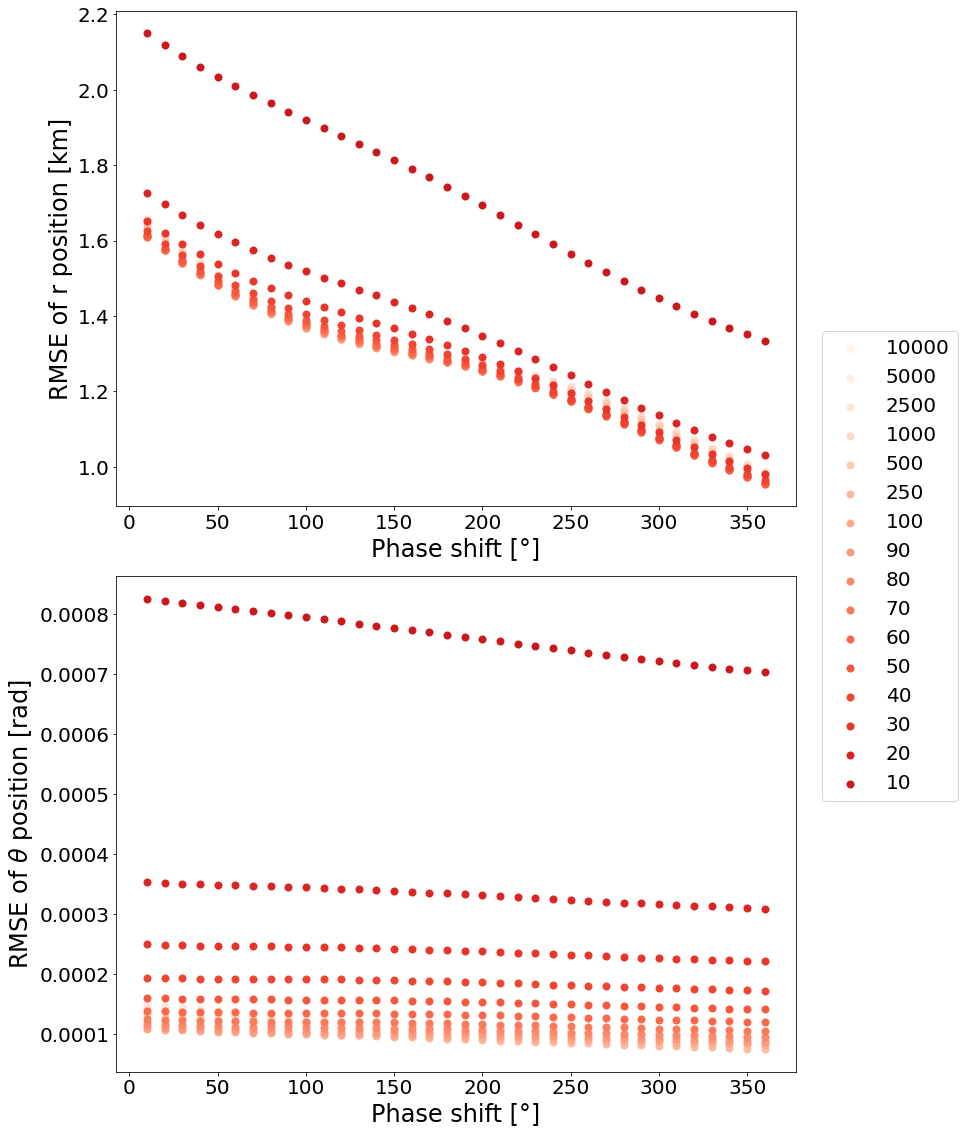

In [139]:

# Create a 2x2 grid of subplots
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 16))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
# Plot data for the first row (Theta Polynomial)
for k in range(len(thetaBIG_tablearr)-4):
    ax1.scatter(theta_deg, RMSErpositiontheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])),color=colors[k])
ax1.set_xlabel("Phase shift [°]", fontsize=24)
ax1.set_ylabel("RMSE of r position [km]", fontsize=24)
#ax1.grid(True)

for k in range(len(thetaBIG_tablearr)-4):
    ax2.scatter(theta_deg, RMSEthetapositiontheta[k][1:], linewidth=2, label=str(len(thetaBIG_tablearr[k][:,3])),color=colors[k])
ax2.set_xlabel("Phase shift [°]", fontsize=24)
ax2.set_ylabel(r"RMSE of $\theta$ position [rad]", fontsize=24)
#ax2.grid(True)


# Collect legends for common legends
# For the top row (Theta Polynomial)
lines_top, labels_top = ax2.get_legend_handles_labels()
# For the bottom row (4 State Polynomial)
lines_bottom, labels_bottom = ax4.get_legend_handles_labels()

# Remove legends from individual subplots
ax1.legend().remove()
ax2.legend().remove()


# Create a common legend for the top row on the right side
fig.legend(handles=lines_top, labels=labels_top, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)





# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust rectangle to fit titles and legends

# Save the figure
plt.savefig("combined_rmse_analysis.pdf", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

TypeError: 'AxesSubplot' object is not iterable

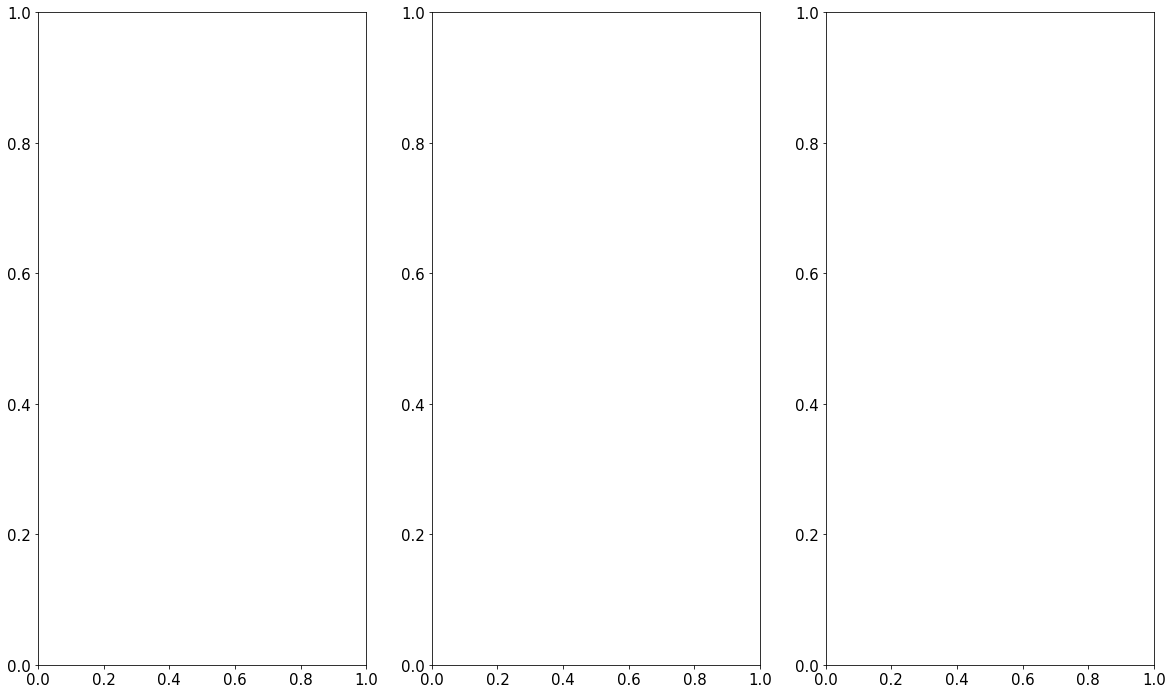

In [124]:
# Create a 1x3 grid of subplots with a larger figure size
fig, axs = plt.subplots(1, 3, figsize=(20, 12))  # Increase the figure size for larger plots

# Add column headers with larger font size
column_headers = ['Low Noise', 'Mid Noise', 'High Noise']
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=20, pad=20)  # Increase font size for column headers

# First row, first column (Theta polynomial, low noise)
for k in range(len(thetaBIG_tablearr) - 5):
    axs[0, 0].plot(time_table[:, 0], Thrustreproducedthetanoisylow[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 0].set_xlabel('Time [s]', fontsize=16)
axs[0, 0].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 0].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# First row, second column (Theta polynomial, mid noise)
for k in range(len(thetaBIG_tablearr) - 10):
    axs[0, 1].plot(time_table[:, 0], Thrustreproducedthetanoisymid[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 1].set_xlabel('Time [s]', fontsize=16)
axs[0, 1].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 1].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# First row, third column (Theta polynomial, high noise)
for k in range(len(thetaBIG_tablearr) - 15):
    axs[0, 2].plot(time_table[:, 0], Thrustreproducedthetanoisyhigh[k][:, 0],
                   label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0, 2].set_xlabel('Time [s]', fontsize=16)
axs[0, 2].set_ylabel('Thrust acceleration [km.s⁻²]', fontsize=16)
axs[0, 2].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# Adjust layout to make space for labels and legends
plt.tight_layout()

# Create a common horizontal legend below the plots with larger font size
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize='large', bbox_to_anchor=(0.5, -0.05))

# Adjust the layout so the legend does not overlap with the plots
plt.subplots_adjust(bottom=0.15)

# Display the plots
plt.savefig("thrustnoisylevelsall.pdf", bbox_inches='tight')
plt.show()


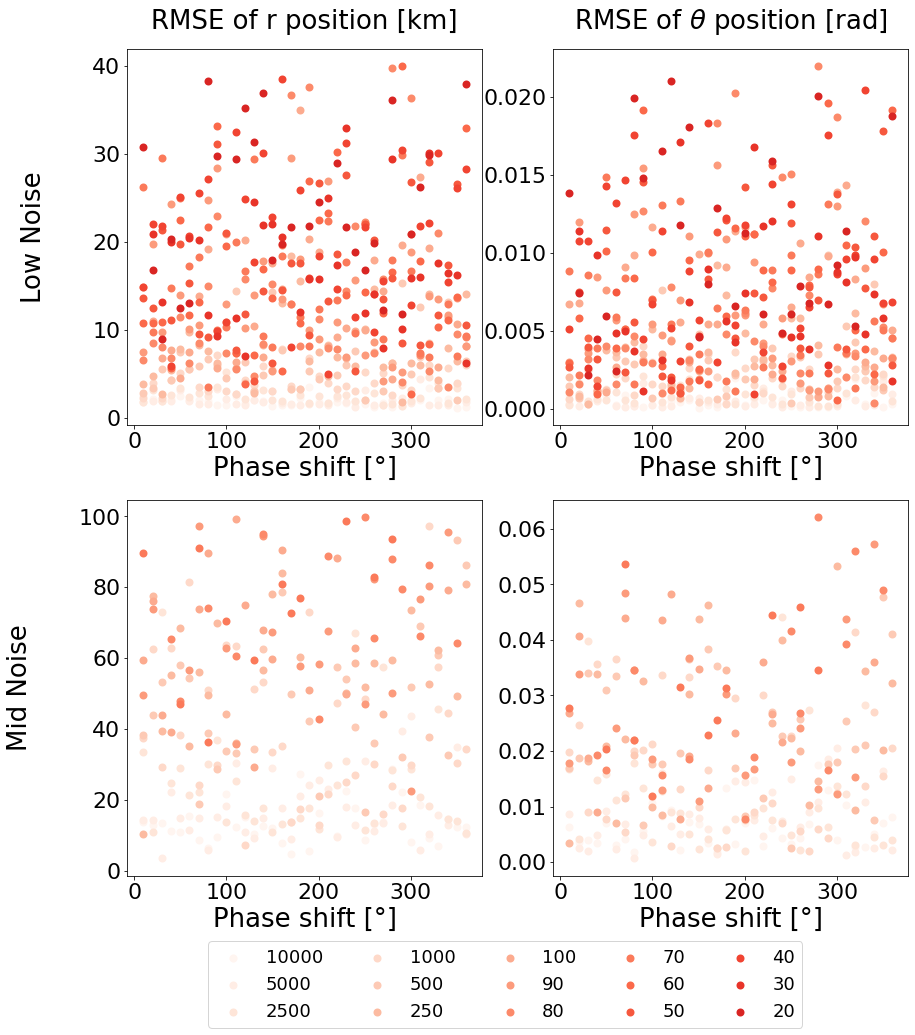

In [162]:
# import matplotlib.pyplot as plt

# # Create a 3x2 grid of subplots with a larger figure size
# fig, axs = plt.subplots(2, 2, figsize=(20, 18))  # 3 rows and 2 columns

# # Define the column and row headers
# column_headers = ['RMSE of r position [km]', r'RMSE of $\theta$ position [rad]']
# row_headers = ['Low Noise', 'Mid Noise']

# # Assign the headers
# for ax, col in zip(axs[0], column_headers):
#     ax.set_title(col, fontsize=30, pad=20)  # Increase font size for column headers

# for ax, row in zip(axs[:, 0], row_headers):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0), 
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size=30, ha='center', va='center', rotation=90)  # Increase font size for row headers

# # First row (Low Noise)
# handles = []
# labels = []

# for k in range(len(thetaBIG_tablearr) - 5):
#     legend_added = False
#     for i in range(len(RMSErpositionnoisylow[k][1:])):
#         rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
#         rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
#         if rmse_r < 40:
#             label = str(len(thetaBIG_tablearr[k][:, 3]))
#             if not legend_added:
#                 handle1 = axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label)
#                 handle2 = axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label)
#                 handles.append(handle1)
#                 labels.append(label)
#                 legend_added = True
#             else:
#                 axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
#                 axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# # Second row (Mid Noise)
# for k in range(len(thetaBIG_tablearr) - 10):
#     for i in range(len(RMSErpositionnoisylow[k][1:])):
#         rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
#         rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
#         if rmse_r < 100:
#             axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2)
#             axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2)

# # Set common x-label for all subplots
# for ax in axs[:, :].flatten():
#     ax.set_xlabel("Phase shift [°]", fontsize=26)
    
# axs[0,0].tick_params(axis='both', which='major', labelsize=30)
# axs[0,1].tick_params(axis='both', which='major', labelsize=30)
# axs[1,0].tick_params(axis='both', which='major', labelsize=30)
# axs[1,1].tick_params(axis='both', which='major', labelsize=30)

# # Adjust layout to make space for the legend
# plt.tight_layout(rect=[0, 0, 0.85, 1])

# # Create a common legend on the right side with larger font size, only for low noise
# fig.legend(handles, labels, loc='center right', fontsize=24)

# # Display the plots
# plt.show()

# Create a 3x2 grid of subplots with adjusted figure size
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Adjust width to 14

# Define the column and row headers
column_headers = ['RMSE of r position [km]', r'RMSE of $\theta$ position [rad]']
row_headers = ['Low Noise', 'Mid Noise']
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 1, 21))
# Assign the headers
for ax, col in zip(axs[0], column_headers):
    ax.set_title(col, fontsize=26, pad=20)  # Increase font size for column headers

for ax, row in zip(axs[:, 0], row_headers):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=26, ha='center', va='center', rotation=90)  # Increase font size for row headers

# First row (Low Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 5):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisylowtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisylowtheta[k][1:][i]
        if rmse_r < 40:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label,color=colors[k])
                handle2 = axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label,color=colors[k])
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[0, 0].scatter(theta_deg[i], rmse_r, linewidth=2,color=colors[k])
                axs[0, 1].scatter(theta_deg[i], rmse_theta, linewidth=2,color=colors[k])

# Add a legend to the first row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.85), fontsize='large', title="Low Noise (theta model)", title_fontsize='16')

# Second row (Mid Noise)
handles = []
labels = []

for k in range(len(thetaBIG_tablearr) - 10):
    legend_added = False
    for i in range(len(RMSErpositionnoisylow[k][1:])):
        rmse_r = RMSErpositionnoisymidtheta[k][1:][i]
        rmse_theta = RMSEthetapositionnoisymidtheta[k][1:][i]
        if rmse_r < 100:
            label = str(len(thetaBIG_tablearr[k][:, 3])) #+ " measurements"
            if not legend_added:
                handle1 = axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2, label=label,color=colors[k])
                handle2 = axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2, label=label,color=colors[k])
                handles.append(handle1)
                labels.append(label)
                legend_added = True
            else:
                axs[1, 0].scatter(theta_deg[i], rmse_r, linewidth=2,color=colors[k])
                axs[1, 1].scatter(theta_deg[i], rmse_theta, linewidth=2,color=colors[k])

# Add a legend to the second row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large', title="Mid Noise (theta model)", title_fontsize='16')

# Add a legend to the third row
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.15), fontsize='large', title="Low Noise (4-state model)", title_fontsize='16')


# Create a common horizontal legend below the plots with larger font size
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize='large', bbox_to_anchor=(0.5, -0.1))

# Adjust the layout so the legend does not overlap with the plots
plt.subplots_adjust(bottom=0.06)

# Display the plots
plt.savefig("noisypositionerrorall.pdf", bbox_inches='tight')
axs[0,0].tick_params(axis='both', which='major', labelsize=22)
axs[0,1].tick_params(axis='both', which='major', labelsize=22)
axs[1,0].tick_params(axis='both', which='major', labelsize=22)
axs[1,1].tick_params(axis='both', which='major', labelsize=22)


# Set common x-label and y-label for all subplots
for ax in axs.flat:
    ax.set_xlabel("Phase shift [°]", fontsize=26)
#    ax.set_ylabel("RMSE [km]" if ax in axs[:, 0] else "RMSE [rad]", fontsize=24)


plt.show()



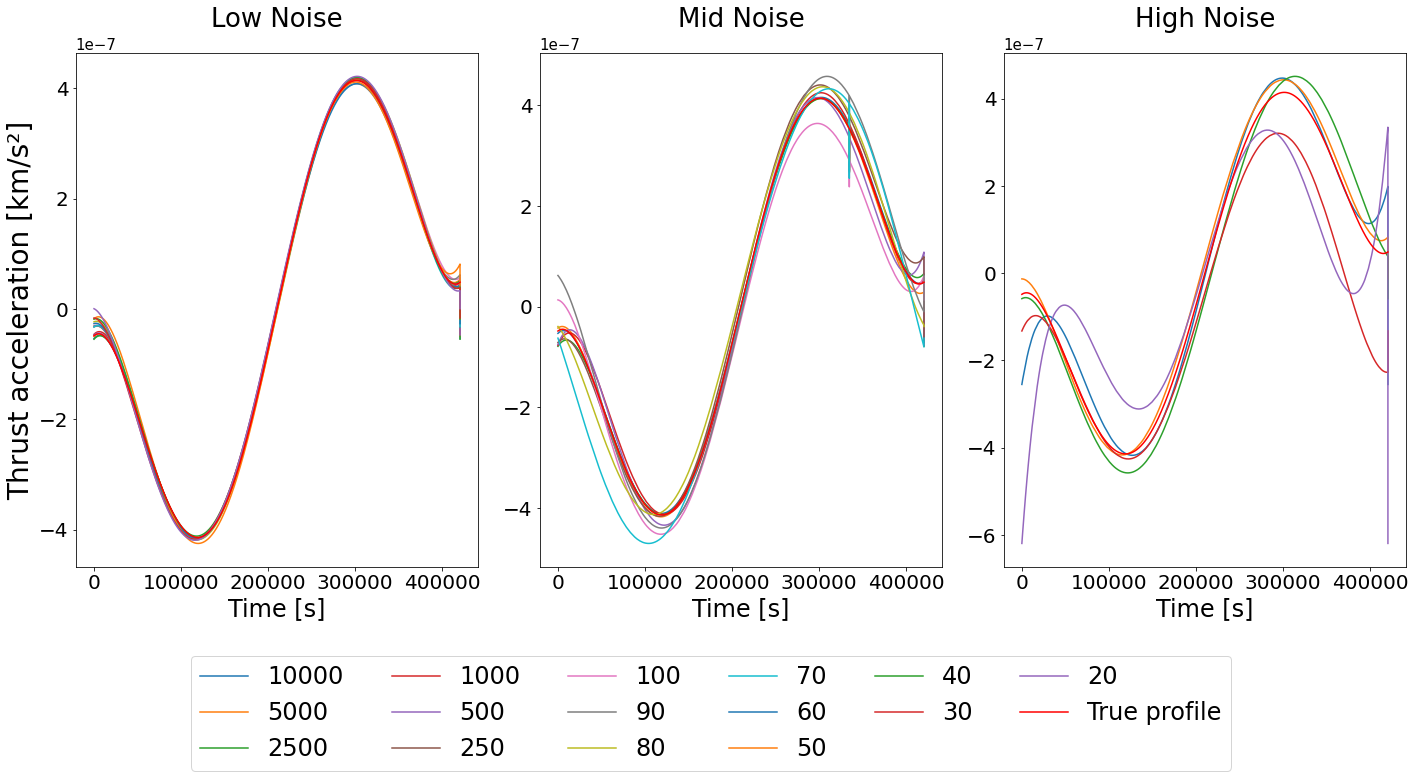

In [150]:
import matplotlib.pyplot as plt

# Create a 1x3 grid of subplots with a larger figure size
fig, axs = plt.subplots(1, 3, figsize=(20, 10))  # Increase the figure size for larger plots
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)
# Add column headers with larger font size
column_headers = ['Low Noise', 'Mid Noise', 'High Noise']
for ax, col in zip(axs, column_headers):  # Loop through axs as it's a 1D array
    ax.set_title(col, fontsize=26, pad=26)  # Increase font size for column headers

# First column (Theta polynomial, low noise)
for k in range(len(thetaBIG_tablearr) - 5):
    axs[0].plot(time_table[:, 0], Thrustreproducedthetanoisylow[k][:, 0],
                label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[0].set_xlabel('Time [s]', fontsize=24)
axs[0].set_ylabel('Thrust acceleration [km/s²]', fontsize=28)
axs[0].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# Second column (Theta polynomial, mid noise)
for k in range(len(thetaBIG_tablearr) - 10):
    axs[1].plot(time_table[:, 0], Thrustreproducedthetanoisymid[k][:, 0],
                label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[1].set_xlabel('Time [s]', fontsize=24)
#axs[1].set_ylabel('Thrust acceleration [km/s²]', fontsize=24)
axs[1].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# Third column (Theta polynomial, high noise)
for k in range(len(thetaBIG_tablearr) - 15):
    axs[2].plot(time_table[:, 0], Thrustreproducedthetanoisyhigh[k][:, 0],
                label=str(len(thetaBIG_tablearr[k][:, 3])))
axs[2].set_xlabel('Time [s]', fontsize=24)
#axs[2].set_ylabel('Thrust acceleration [km/s²]', fontsize=24)
axs[2].plot(time_table[:, 0], Thrust_table[:, 0], label="True profile", color="red")

# Adjust layout to make space for labels and legends
plt.tight_layout()

# Create a common horizontal legend below the plots with larger font size
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=24, bbox_to_anchor=(0.5, -0.1))

# Adjust the layout so the legend does not overlap with the plots
plt.subplots_adjust(bottom=0.2)

# Save the plot as a PDF
plt.savefig("thrustnoisylevelsall.pdf", bbox_inches='tight')

# Display the plots
plt.show()
